## **Step 1 - Install & Import Dependencies**

In [0]:
!pip install tsfresh
#to access kaggle datasets
!pip install kaggle
!pip install eli5
!pip install catboost
  

In [0]:
import pandas as pd
from pandas import DataFrame
from scipy import stats
import numpy as np
import math
import time
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout, LSTM
from sklearn.ensemble import RandomForestRegressor
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import mean_squared_error 
from math import sqrt
import matplotlib.pyplot as plt
from sklearn.svm import NuSVR
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from catboost import CatBoostRegressor, Pool 
from sklearn.model_selection import KFold


## **Step 2 - Import kaggle dataset**

In [0]:
# Ipload local file (kaggle.json)
from google.colab import files
uploaded = files.upload()
  
# The kaggle.json needs to be moved into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [0]:
#download earthquake data
!kaggle competitions download -c LANL-Earthquake-Prediction

  0% 0.00/33.3k [00:00<?, ?B/s]
100% 33.3k/33.3k [00:00<00:00, 27.5MB/s]
 97% 235M/242M [00:03<00:00, 76.8MB/s]
100% 242M/242M [00:03<00:00, 73.0MB/s]
100% 2.02G/2.03G [00:32<00:00, 84.1MB/s]
100% 2.03G/2.03G [00:32<00:00, 67.4MB/s]


In [0]:
#unzip training data
!unzip train.csv.zip

Archive:  train.csv.zip
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [0]:
!mkdir test

In [0]:
!unzip test.zip -d test/

## **Step 3 - Explorartory Analysis **

In [0]:
#Extract a part of the training data 500 sequence of the full data to plot the data  
data = pd.read_csv('train.csv', nrows=150000*500, dtype={'acoustic_data': np.int16, 'time_to_failure': np.float32})

In [0]:
data.head()

acoustic_data  time_to_failure
0             12           1.4691
1              6           1.4691
2              8           1.4691
3              5           1.4691
4              8           1.4691

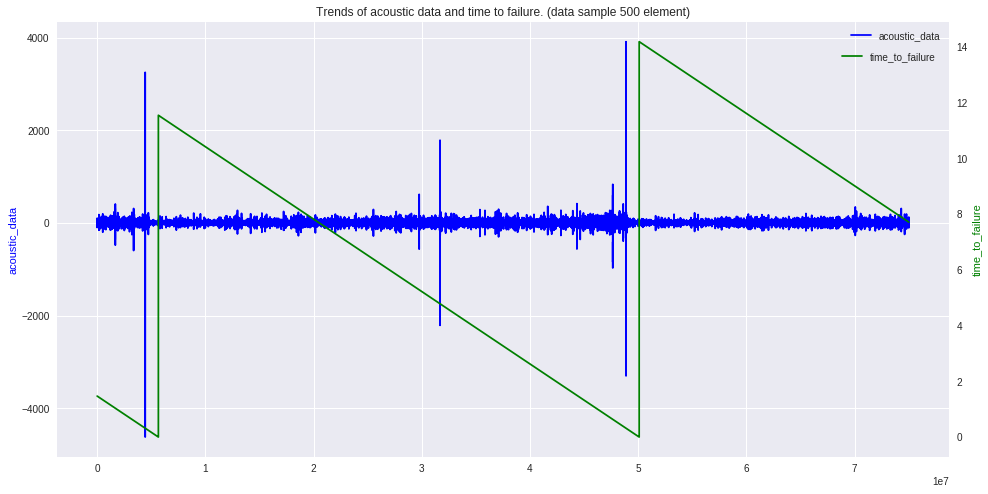

In [0]:
acoustic_data_sample = data['acoustic_data'].values
time_to_failure_sample = data['time_to_failure'].values
figure, axis_1 = plt.subplots(figsize=(16, 8))
plt.title("Trends of acoustic data and time to failure. (data sample 500 element)")
plt.plot(acoustic_data_sample, color='b')
axis_1.set_ylabel('acoustic_data', color='b')
plt.legend(['acoustic_data'])
axis_2 = axis_1.twinx()
plt.plot(time_to_failure_sample, color='g')
axis_2.set_ylabel('time_to_failure', color='g')
plt.legend(['time_to_failure'], loc=(0.875, 0.9))
plt.grid(False)


In [0]:
#delete the data used for poltting to liberate RAM memory 
del acoustic_data_sample
del time_to_failure_sample
del data

## **Step 4 - Feature extraction and selection**

In [0]:
#Extract a part of the training data 220 sequence for feature extraction  
data = pd.read_csv('train.csv', nrows=150000*220, dtype={'acoustic_data': np.int16, 'time_to_failure': np.float32})

In [0]:
#extract the dependent and independent variables
def series_to_supervised(data, seq_length=150000, shift=150000):
    k=0
    N=len(data)-(seq_length+shift)
    X, Y = [], []
    for seg in data:
        X.append(seg)
        Y.append(seg[1])

    X_reshaped = []
    Y_reshaped = []
    print(X_reshaped)

    for i in tqdm(range(0,N,shift)):    
        X_reshaped+=[(x, y, c) for (x, y), c in zip(X[i:seq_length+i],150000*[k])]
        Y_reshaped.append(Y[seq_length+i+1])
        k+=1
    return X_reshaped, Y_reshaped

In [0]:
#The set of features below have been extracted from the tsfresh package developed at the MIT

Feature_to_extract={'maximum': None,
 'mean': None,
 'median': None,
 'minimum': None,
 'standard_deviation': None,
 'sum_values': None,
 'variance': None,'abs_energy': None,
 'absolute_sum_of_changes': None, 'agg_autocorrelation': [{'f_agg': 'mean', 'maxlag': 40}],'agg_linear_trend': [{'attr': 'rvalue', 'chunk_len': 5, 'f_agg': 'max'},
  {'attr': 'rvalue', 'chunk_len': 5, 'f_agg': 'min'},
  {'attr': 'rvalue', 'chunk_len': 5, 'f_agg': 'mean'},
  {'attr': 'rvalue', 'chunk_len': 5, 'f_agg': 'var'}],
 'ar_coefficient': [{'coeff': 0, 'k': 10}],'binned_entropy': [{'max_bins': 10}],
 'count_above_mean': None,
 'count_below_mean': None, 'energy_ratio_by_chunks': [{'num_segments': 10, 'segment_focus': 0},
  {'num_segments': 10, 'segment_focus': 1},
  {'num_segments': 10, 'segment_focus': 2},
  {'num_segments': 10, 'segment_focus': 3},
  {'num_segments': 10, 'segment_focus': 4},
  {'num_segments': 10, 'segment_focus': 5},
  {'num_segments': 10, 'segment_focus': 6},
  {'num_segments': 10, 'segment_focus': 7},
  {'num_segments': 10, 'segment_focus': 8},
  {'num_segments': 10, 'segment_focus': 9}],
 'fft_aggregated': [{'aggtype': 'centroid'},
  {'aggtype': 'variance'},
  {'aggtype': 'skew'},
  {'aggtype': 'kurtosis'}], 'fft_coefficient': [{'attr': 'real', 'coeff': 0},
  {'attr': 'real', 'coeff': 1},
  {'attr': 'real', 'coeff': 2},
  {'attr': 'real', 'coeff': 3},
  {'attr': 'real', 'coeff': 4},
  {'attr': 'real', 'coeff': 5},
  {'attr': 'real', 'coeff': 6},
  {'attr': 'real', 'coeff': 7},
  {'attr': 'real', 'coeff': 8},
  {'attr': 'real', 'coeff': 9},
  {'attr': 'real', 'coeff': 10},
  {'attr': 'real', 'coeff': 11},
  {'attr': 'real', 'coeff': 12},
  {'attr': 'real', 'coeff': 13},
  {'attr': 'real', 'coeff': 14},
  {'attr': 'real', 'coeff': 15},
  {'attr': 'real', 'coeff': 16},
  {'attr': 'real', 'coeff': 17},
  {'attr': 'real', 'coeff': 18},
  {'attr': 'real', 'coeff': 19},
  {'attr': 'real', 'coeff': 20},
  {'attr': 'real', 'coeff': 21},
  {'attr': 'real', 'coeff': 22},
  {'attr': 'real', 'coeff': 23},
  {'attr': 'real', 'coeff': 24},
  {'attr': 'real', 'coeff': 25},
  {'attr': 'real', 'coeff': 26},
  {'attr': 'real', 'coeff': 27},
  {'attr': 'real', 'coeff': 28},
  {'attr': 'real', 'coeff': 29},
  {'attr': 'real', 'coeff': 30},
  {'attr': 'real', 'coeff': 31},
  {'attr': 'real', 'coeff': 32},
  {'attr': 'real', 'coeff': 33},
  {'attr': 'real', 'coeff': 34},
  {'attr': 'real', 'coeff': 35},
  {'attr': 'real', 'coeff': 36},
  {'attr': 'real', 'coeff': 37},
  {'attr': 'real', 'coeff': 38},
  {'attr': 'real', 'coeff': 39},
  {'attr': 'real', 'coeff': 40},
  {'attr': 'real', 'coeff': 41},
  {'attr': 'real', 'coeff': 42},
  {'attr': 'real', 'coeff': 43},
  {'attr': 'real', 'coeff': 44},
  {'attr': 'real', 'coeff': 45},
  {'attr': 'real', 'coeff': 46},
  {'attr': 'real', 'coeff': 47},
  {'attr': 'real', 'coeff': 48},
  {'attr': 'real', 'coeff': 49},
  {'attr': 'real', 'coeff': 50},
  {'attr': 'real', 'coeff': 51},
  {'attr': 'real', 'coeff': 52},
  {'attr': 'real', 'coeff': 53},
  {'attr': 'real', 'coeff': 54},
  {'attr': 'real', 'coeff': 55},
  {'attr': 'real', 'coeff': 56},
  {'attr': 'real', 'coeff': 57},
  {'attr': 'real', 'coeff': 58},
  {'attr': 'real', 'coeff': 59},
  {'attr': 'real', 'coeff': 60},
  {'attr': 'real', 'coeff': 61},
  {'attr': 'real', 'coeff': 62},
  {'attr': 'real', 'coeff': 63},
  {'attr': 'real', 'coeff': 64},
  {'attr': 'real', 'coeff': 65},
  {'attr': 'real', 'coeff': 66},
  {'attr': 'real', 'coeff': 67},
  {'attr': 'real', 'coeff': 68},
  {'attr': 'real', 'coeff': 69},
  {'attr': 'real', 'coeff': 70},
  {'attr': 'real', 'coeff': 71},
  {'attr': 'real', 'coeff': 72},
  {'attr': 'real', 'coeff': 73},
  {'attr': 'real', 'coeff': 74},
  {'attr': 'real', 'coeff': 75},
  {'attr': 'real', 'coeff': 76},
  {'attr': 'real', 'coeff': 77},
  {'attr': 'real', 'coeff': 78},
  {'attr': 'real', 'coeff': 79},
  {'attr': 'real', 'coeff': 80},
  {'attr': 'real', 'coeff': 81},
  {'attr': 'real', 'coeff': 82},
  {'attr': 'real', 'coeff': 83},
  {'attr': 'real', 'coeff': 84},
  {'attr': 'real', 'coeff': 85},
  {'attr': 'real', 'coeff': 86},
  {'attr': 'real', 'coeff': 87},
  {'attr': 'real', 'coeff': 88},
  {'attr': 'real', 'coeff': 89},
  {'attr': 'real', 'coeff': 90},
  {'attr': 'real', 'coeff': 91},
  {'attr': 'real', 'coeff': 92},
  {'attr': 'real', 'coeff': 93},
  {'attr': 'real', 'coeff': 94},
  {'attr': 'real', 'coeff': 95},
  {'attr': 'real', 'coeff': 96},
  {'attr': 'real', 'coeff': 97},
  {'attr': 'real', 'coeff': 98},
  {'attr': 'real', 'coeff': 99},
  {'attr': 'imag', 'coeff': 0},
  {'attr': 'imag', 'coeff': 1},
  {'attr': 'imag', 'coeff': 2},
  {'attr': 'imag', 'coeff': 3},
  {'attr': 'imag', 'coeff': 4},
  {'attr': 'imag', 'coeff': 5},
  {'attr': 'imag', 'coeff': 6},
  {'attr': 'imag', 'coeff': 7},
  {'attr': 'imag', 'coeff': 8},
  {'attr': 'imag', 'coeff': 9},
  {'attr': 'imag', 'coeff': 10},
  {'attr': 'imag', 'coeff': 11},
  {'attr': 'imag', 'coeff': 12},
  {'attr': 'imag', 'coeff': 13},
  {'attr': 'imag', 'coeff': 14},
  {'attr': 'imag', 'coeff': 15},
  {'attr': 'imag', 'coeff': 16},
  {'attr': 'imag', 'coeff': 17},
  {'attr': 'imag', 'coeff': 18},
  {'attr': 'imag', 'coeff': 19},
  {'attr': 'imag', 'coeff': 20},
  {'attr': 'imag', 'coeff': 21},
  {'attr': 'imag', 'coeff': 22},
  {'attr': 'imag', 'coeff': 23},
  {'attr': 'imag', 'coeff': 24},
  {'attr': 'imag', 'coeff': 25},
  {'attr': 'imag', 'coeff': 26},
  {'attr': 'imag', 'coeff': 27},
  {'attr': 'imag', 'coeff': 28},
  {'attr': 'imag', 'coeff': 29},
  {'attr': 'imag', 'coeff': 30},
  {'attr': 'imag', 'coeff': 31},
  {'attr': 'imag', 'coeff': 32},
  {'attr': 'imag', 'coeff': 33},
  {'attr': 'imag', 'coeff': 34},
  {'attr': 'imag', 'coeff': 35},
  {'attr': 'imag', 'coeff': 36},
  {'attr': 'imag', 'coeff': 37},
  {'attr': 'imag', 'coeff': 38},
  {'attr': 'imag', 'coeff': 39},
  {'attr': 'imag', 'coeff': 40},
  {'attr': 'imag', 'coeff': 41},
  {'attr': 'imag', 'coeff': 42},
  {'attr': 'imag', 'coeff': 43},
  {'attr': 'imag', 'coeff': 44},
  {'attr': 'imag', 'coeff': 45},
  {'attr': 'imag', 'coeff': 46},
  {'attr': 'imag', 'coeff': 47},
  {'attr': 'imag', 'coeff': 48},
  {'attr': 'imag', 'coeff': 49},
  {'attr': 'imag', 'coeff': 50},
  {'attr': 'imag', 'coeff': 51},
  {'attr': 'imag', 'coeff': 52},
  {'attr': 'imag', 'coeff': 53},
  {'attr': 'imag', 'coeff': 54},
  {'attr': 'imag', 'coeff': 55},
  {'attr': 'imag', 'coeff': 56},
  {'attr': 'imag', 'coeff': 57},
  {'attr': 'imag', 'coeff': 58},
  {'attr': 'imag', 'coeff': 59},
  {'attr': 'imag', 'coeff': 60},
  {'attr': 'imag', 'coeff': 61},
  {'attr': 'imag', 'coeff': 62},
  {'attr': 'imag', 'coeff': 63},
  {'attr': 'imag', 'coeff': 64},
  {'attr': 'imag', 'coeff': 65},
  {'attr': 'imag', 'coeff': 66},
  {'attr': 'imag', 'coeff': 67},
  {'attr': 'imag', 'coeff': 68},
  {'attr': 'imag', 'coeff': 69},
  {'attr': 'imag', 'coeff': 70},
  {'attr': 'imag', 'coeff': 71},
  {'attr': 'imag', 'coeff': 72},
  {'attr': 'imag', 'coeff': 73},
  {'attr': 'imag', 'coeff': 74},
  {'attr': 'imag', 'coeff': 75},
  {'attr': 'imag', 'coeff': 76},
  {'attr': 'imag', 'coeff': 77},
  {'attr': 'imag', 'coeff': 78},
  {'attr': 'imag', 'coeff': 79},
  {'attr': 'imag', 'coeff': 80},
  {'attr': 'imag', 'coeff': 81},
  {'attr': 'imag', 'coeff': 82},
  {'attr': 'imag', 'coeff': 83},
  {'attr': 'imag', 'coeff': 84},
  {'attr': 'imag', 'coeff': 85},
  {'attr': 'imag', 'coeff': 86},
  {'attr': 'imag', 'coeff': 87},
  {'attr': 'imag', 'coeff': 88},
  {'attr': 'imag', 'coeff': 89},
  {'attr': 'imag', 'coeff': 90},
  {'attr': 'imag', 'coeff': 91},
  {'attr': 'imag', 'coeff': 92},
  {'attr': 'imag', 'coeff': 93},
  {'attr': 'imag', 'coeff': 94},
  {'attr': 'imag', 'coeff': 95},
  {'attr': 'imag', 'coeff': 96},
  {'attr': 'imag', 'coeff': 97},
  {'attr': 'imag', 'coeff': 98},
  {'attr': 'imag', 'coeff': 99},
  {'attr': 'abs', 'coeff': 0},
  {'attr': 'abs', 'coeff': 1},
  {'attr': 'abs', 'coeff': 2},
  {'attr': 'abs', 'coeff': 3},
  {'attr': 'abs', 'coeff': 4},
  {'attr': 'abs', 'coeff': 5},
  {'attr': 'abs', 'coeff': 6},
  {'attr': 'abs', 'coeff': 7},
  {'attr': 'abs', 'coeff': 8},
  {'attr': 'abs', 'coeff': 9},
  {'attr': 'abs', 'coeff': 10},
  {'attr': 'abs', 'coeff': 11},
  {'attr': 'abs', 'coeff': 12},
  {'attr': 'abs', 'coeff': 13},
  {'attr': 'abs', 'coeff': 14},
  {'attr': 'abs', 'coeff': 15},
  {'attr': 'abs', 'coeff': 16},
  {'attr': 'abs', 'coeff': 17},
  {'attr': 'abs', 'coeff': 18},
  {'attr': 'abs', 'coeff': 19},
  {'attr': 'abs', 'coeff': 20},
  {'attr': 'abs', 'coeff': 21},
  {'attr': 'abs', 'coeff': 22},
  {'attr': 'abs', 'coeff': 23},
  {'attr': 'abs', 'coeff': 24},
  {'attr': 'abs', 'coeff': 25},
  {'attr': 'abs', 'coeff': 26},
  {'attr': 'abs', 'coeff': 27},
  {'attr': 'abs', 'coeff': 28},
  {'attr': 'abs', 'coeff': 29},
  {'attr': 'abs', 'coeff': 30},
  {'attr': 'abs', 'coeff': 31},
  {'attr': 'abs', 'coeff': 32},
  {'attr': 'abs', 'coeff': 33},
  {'attr': 'abs', 'coeff': 34},
  {'attr': 'abs', 'coeff': 35},
  {'attr': 'abs', 'coeff': 36},
  {'attr': 'abs', 'coeff': 37},
  {'attr': 'abs', 'coeff': 38},
  {'attr': 'abs', 'coeff': 39},
  {'attr': 'abs', 'coeff': 40},
  {'attr': 'abs', 'coeff': 41},
  {'attr': 'abs', 'coeff': 42},
  {'attr': 'abs', 'coeff': 43},
  {'attr': 'abs', 'coeff': 44},
  {'attr': 'abs', 'coeff': 45},
  {'attr': 'abs', 'coeff': 46},
  {'attr': 'abs', 'coeff': 47},
  {'attr': 'abs', 'coeff': 48},
  {'attr': 'abs', 'coeff': 49},
  {'attr': 'abs', 'coeff': 50},
  {'attr': 'abs', 'coeff': 51},
  {'attr': 'abs', 'coeff': 52},
  {'attr': 'abs', 'coeff': 53},
  {'attr': 'abs', 'coeff': 54},
  {'attr': 'abs', 'coeff': 55},
  {'attr': 'abs', 'coeff': 56},
  {'attr': 'abs', 'coeff': 57},
  {'attr': 'abs', 'coeff': 58},
  {'attr': 'abs', 'coeff': 59},
  {'attr': 'abs', 'coeff': 60},
  {'attr': 'abs', 'coeff': 61},
  {'attr': 'abs', 'coeff': 62},
  {'attr': 'abs', 'coeff': 63},
  {'attr': 'abs', 'coeff': 64},
  {'attr': 'abs', 'coeff': 65},
  {'attr': 'abs', 'coeff': 66},
  {'attr': 'abs', 'coeff': 67},
  {'attr': 'abs', 'coeff': 68},
  {'attr': 'abs', 'coeff': 69},
  {'attr': 'abs', 'coeff': 70},
  {'attr': 'abs', 'coeff': 71},
  {'attr': 'abs', 'coeff': 72},
  {'attr': 'abs', 'coeff': 73},
  {'attr': 'abs', 'coeff': 74},
  {'attr': 'abs', 'coeff': 75},
  {'attr': 'abs', 'coeff': 76},
  {'attr': 'abs', 'coeff': 77},
  {'attr': 'abs', 'coeff': 78},
  {'attr': 'abs', 'coeff': 79},
  {'attr': 'abs', 'coeff': 80},
  {'attr': 'abs', 'coeff': 81},
  {'attr': 'abs', 'coeff': 82},
  {'attr': 'abs', 'coeff': 83},
  {'attr': 'abs', 'coeff': 84},
  {'attr': 'abs', 'coeff': 85},
  {'attr': 'abs', 'coeff': 86},
  {'attr': 'abs', 'coeff': 87},
  {'attr': 'abs', 'coeff': 88},
  {'attr': 'abs', 'coeff': 89},
  {'attr': 'abs', 'coeff': 90},
  {'attr': 'abs', 'coeff': 91},
  {'attr': 'abs', 'coeff': 92},
  {'attr': 'abs', 'coeff': 93},
  {'attr': 'abs', 'coeff': 94},
  {'attr': 'abs', 'coeff': 95},
  {'attr': 'abs', 'coeff': 96},
  {'attr': 'abs', 'coeff': 97},
  {'attr': 'abs', 'coeff': 98},
  {'attr': 'abs', 'coeff': 99},
  {'attr': 'angle', 'coeff': 0},
  {'attr': 'angle', 'coeff': 1},
  {'attr': 'angle', 'coeff': 2},
  {'attr': 'angle', 'coeff': 3},
  {'attr': 'angle', 'coeff': 4},
  {'attr': 'angle', 'coeff': 5},
  {'attr': 'angle', 'coeff': 6},
  {'attr': 'angle', 'coeff': 7},
  {'attr': 'angle', 'coeff': 8},
  {'attr': 'angle', 'coeff': 9},
  {'attr': 'angle', 'coeff': 10},
  {'attr': 'angle', 'coeff': 11},
  {'attr': 'angle', 'coeff': 12},
  {'attr': 'angle', 'coeff': 13},
  {'attr': 'angle', 'coeff': 14},
  {'attr': 'angle', 'coeff': 15},
  {'attr': 'angle', 'coeff': 16},
  {'attr': 'angle', 'coeff': 17},
  {'attr': 'angle', 'coeff': 18},
  {'attr': 'angle', 'coeff': 19},
  {'attr': 'angle', 'coeff': 20},
  {'attr': 'angle', 'coeff': 21},
  {'attr': 'angle', 'coeff': 22},
  {'attr': 'angle', 'coeff': 23},
  {'attr': 'angle', 'coeff': 24},
  {'attr': 'angle', 'coeff': 25},
  {'attr': 'angle', 'coeff': 26},
  {'attr': 'angle', 'coeff': 27},
  {'attr': 'angle', 'coeff': 28},
  {'attr': 'angle', 'coeff': 29},
  {'attr': 'angle', 'coeff': 30},
  {'attr': 'angle', 'coeff': 31},
  {'attr': 'angle', 'coeff': 32},
  {'attr': 'angle', 'coeff': 33},
  {'attr': 'angle', 'coeff': 34},
  {'attr': 'angle', 'coeff': 35},
  {'attr': 'angle', 'coeff': 36},
  {'attr': 'angle', 'coeff': 37},
  {'attr': 'angle', 'coeff': 38},
  {'attr': 'angle', 'coeff': 39},
  {'attr': 'angle', 'coeff': 40},
  {'attr': 'angle', 'coeff': 41},
  {'attr': 'angle', 'coeff': 42},
  {'attr': 'angle', 'coeff': 43},
  {'attr': 'angle', 'coeff': 44},
  {'attr': 'angle', 'coeff': 45},
  {'attr': 'angle', 'coeff': 46},
  {'attr': 'angle', 'coeff': 47},
  {'attr': 'angle', 'coeff': 48},
  {'attr': 'angle', 'coeff': 49},
  {'attr': 'angle', 'coeff': 50},
  {'attr': 'angle', 'coeff': 51},
  {'attr': 'angle', 'coeff': 52},
  {'attr': 'angle', 'coeff': 53},
  {'attr': 'angle', 'coeff': 54},
  {'attr': 'angle', 'coeff': 55},
  {'attr': 'angle', 'coeff': 56},
  {'attr': 'angle', 'coeff': 57},
  {'attr': 'angle', 'coeff': 58},
  {'attr': 'angle', 'coeff': 59},
  {'attr': 'angle', 'coeff': 60},
  {'attr': 'angle', 'coeff': 61},
  {'attr': 'angle', 'coeff': 62},
  {'attr': 'angle', 'coeff': 63},
  {'attr': 'angle', 'coeff': 64},
  {'attr': 'angle', 'coeff': 65},
  {'attr': 'angle', 'coeff': 66},
  {'attr': 'angle', 'coeff': 67},
  {'attr': 'angle', 'coeff': 68},
  {'attr': 'angle', 'coeff': 69},
  {'attr': 'angle', 'coeff': 70},
  {'attr': 'angle', 'coeff': 71},
  {'attr': 'angle', 'coeff': 72},
  {'attr': 'angle', 'coeff': 73},
  {'attr': 'angle', 'coeff': 74},
  {'attr': 'angle', 'coeff': 75},
  {'attr': 'angle', 'coeff': 76},
  {'attr': 'angle', 'coeff': 77},
  {'attr': 'angle', 'coeff': 78},
  {'attr': 'angle', 'coeff': 79},
  {'attr': 'angle', 'coeff': 80},
  {'attr': 'angle', 'coeff': 81},
  {'attr': 'angle', 'coeff': 82},
  {'attr': 'angle', 'coeff': 83},
  {'attr': 'angle', 'coeff': 84},
  {'attr': 'angle', 'coeff': 85},
  {'attr': 'angle', 'coeff': 86},
  {'attr': 'angle', 'coeff': 87},
  {'attr': 'angle', 'coeff': 88},
  {'attr': 'angle', 'coeff': 89},
  {'attr': 'angle', 'coeff': 90},
  {'attr': 'angle', 'coeff': 91},
  {'attr': 'angle', 'coeff': 92},
  {'attr': 'angle', 'coeff': 93},
  {'attr': 'angle', 'coeff': 94},
  {'attr': 'angle', 'coeff': 95},
  {'attr': 'angle', 'coeff': 96},
  {'attr': 'angle', 'coeff': 97},
  {'attr': 'angle', 'coeff': 98},
  {'attr': 'angle', 'coeff': 99}],'first_location_of_maximum': None,
 'first_location_of_minimum': None,
 'friedrich_coefficients': [{'coeff': 0, 'm': 3, 'r': 30},
  {'coeff': 1, 'm': 3, 'r': 30},
  {'coeff': 2, 'm': 3, 'r': 30},
  {'coeff': 3, 'm': 3, 'r': 30}],
 'has_duplicate': None,
 'has_duplicate_max': None,
 'has_duplicate_min': None,
 'index_mass_quantile': [{'q': 0.1},
  {'q': 0.2},
  {'q': 0.3},
  {'q': 0.4},
  {'q': 0.6},
  {'q': 0.7},
  {'q': 0.8},
  {'q': 0.9}],
 'kurtosis': None,'large_standard_deviation': [{'r': 0.05},
  {'r': 0.1},
  {'r': 0.15000000000000002},
  {'r': 0.2},
  {'r': 0.25},
  {'r': 0.30000000000000004},
  {'r': 0.35000000000000003},
  {'r': 0.4},
  {'r': 0.45},
  {'r': 0.5},
  {'r': 0.55},
  {'r': 0.6000000000000001},
  {'r': 0.65},
  {'r': 0.7000000000000001},
  {'r': 0.75},
  {'r': 0.8},
  {'r': 0.8500000000000001},
  {'r': 0.9},
  {'r': 0.9500000000000001}],'last_location_of_maximum': None,
 'last_location_of_minimum': None,
 'length': None,
 'linear_trend': [{'attr': 'pvalue'},
  {'attr': 'rvalue'},
  {'attr': 'intercept'},
  {'attr': 'slope'},
  {'attr': 'stderr'}],'max_langevin_fixed_point': [{'m': 3, 'r': 30}],
 'mean_abs_change': None,
 'mean_change': None,
 'mean_second_derivative_central': None, 'number_crossing_m': [{'m': 0}, {'m': -1}, 
 {'m': 1}],'number_peaks': [{'n': 1}, {'n': 3}, {'n': 5}, {'n': 10}, {'n': 50}],
 'percentage_of_reoccurring_datapoints_to_all_datapoints': None,
 'percentage_of_reoccurring_values_to_all_values': None,
   'quantile': [{'q': 0.1},
  {'q': 0.2},
  {'q': 0.3},
  {'q': 0.4},
  {'q': 0.6},
  {'q': 0.7},
  {'q': 0.8},
  {'q': 0.9}],
 'range_count': [{'max': 1, 'min': -1},
  {'max': 0, 'min': 1000000000000.0},
  {'max': 1000000000000.0, 'min': 0}], 'ratio_beyond_r_sigma': [{'r': 0.5},
  {'r': 1},
  {'r': 1.5},
  {'r': 2},
  {'r': 2.5},
  {'r': 3},
  {'r': 5},
  {'r': 6},
  {'r': 7},
  {'r': 10}],
 'ratio_value_number_to_time_series_length': None,
 'skewness': None,
 'spkt_welch_density': [{'coeff': 2}, {'coeff': 5}, {'coeff': 8}],
 'standard_deviation': None,
 'sum_of_reoccurring_data_points': None,
 'sum_of_reoccurring_values': None,
 'sum_values': None, 'symmetry_looking': [{'r': 0.0},
  {'r': 0.05},
  {'r': 0.1},
  {'r': 0.15000000000000002},
  {'r': 0.2},
  {'r': 0.25},
  {'r': 0.30000000000000004},
  {'r': 0.35000000000000003},
  {'r': 0.4},
  {'r': 0.45},
  {'r': 0.5},
  {'r': 0.55},
  {'r': 0.6000000000000001},
  {'r': 0.65},
  {'r': 0.7000000000000001},
  {'r': 0.75},
  {'r': 0.8},
  {'r': 0.8500000000000001},
  {'r': 0.9},
  {'r': 0.9500000000000001}],
 'time_reversal_asymmetry_statistic': [{'lag': 1}, {'lag': 2}, {'lag': 3}],
 'variance': None,
 'variance_larger_than_standard_deviation': None}

In [0]:
#Extract the sequences to compute features 
X_data, Y_data=series_to_supervised(data.values,150000,150000) 
X_dataD=pd.DataFrame(X_data, columns = ["acoustic_data", "time_to_failure","index"])
Y_tr=pd.Series(Y_data)

#Using the tsfresh library we will extract the featrues listed in the prior dictionnary 
from tsfresh import extract_features, feature_extraction, feature_selection
X_dataD_extracted_features = extract_features(X_dataD, column_id='index', column_sort=None, column_value='acoustic_data', 
show_warnings=False, default_fc_parameters=Feature_to_extract)

  0%|          | 0/218 [00:00<?, ?it/s]

[]


100%|██████████| 218/218 [00:35<00:00,  6.49it/s]
/usr/local/lib/python3.6/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
Feature Extraction: 100%|██████████| 5/5 [05:32<00:00, 65.93s/it]


In [0]:
#return the total number of extracted features
len(X_dataD_extracted_features.columns)



543

In [0]:
del X_data
del Y_data
del X_dataD


In [0]:
#using the Kendalltau test of independency we select the most relevant features for alpha=0.01
test_result=[]
for column in X_dataD_extracted_features:
    tau, p_value = stats.kendalltau(X_dataD_extracted_features[column], Y_tr, "asymptotic")
    test_result.append('{}:{}'.format(column,p_value))
    if p_value>0.01 or math.isnan(p_value):
      del X_dataD_extracted_features[column]    
#return the total number of selected features based on kendall
len(X_dataD_extracted_features.columns)

# Extract and keep the selected features from the kendalltau test
from tsfresh import feature_extraction, feature_selection
Final_selected_parameters = feature_extraction.settings.from_columns(X_dataD_extracted_features)

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:3525: UserWarning: "initial_lexsort" is gone!
  warnings.warn('"initial_lexsort" is gone!')


In [0]:
test_result

['acoustic_data__abs_energy:1.1339923110152292e-29',
 'acoustic_data__absolute_sum_of_changes:2.0901957224403388e-43',
 'acoustic_data__agg_autocorrelation__f_agg_"mean"__maxlag_40:1.1249909681456018e-12',
 'acoustic_data__agg_linear_trend__f_agg_"max"__chunk_len_5__attr_"rvalue":0.02476177844129425',
 'acoustic_data__agg_linear_trend__f_agg_"mean"__chunk_len_5__attr_"rvalue":0.9622161101334175',
 'acoustic_data__agg_linear_trend__f_agg_"min"__chunk_len_5__attr_"rvalue":0.23263107336528688',
 'acoustic_data__agg_linear_trend__f_agg_"var"__chunk_len_5__attr_"rvalue":0.025364206093471505',
 'acoustic_data__ar_coefficient__k_10__coeff_0:1.2042459953707586e-24',
 'acoustic_data__binned_entropy__max_bins_10:0.4681735570274924',
 'acoustic_data__count_above_mean:0.42330911249849523',
 'acoustic_data__count_below_mean:0.42330911249849523',
 'acoustic_data__energy_ratio_by_chunks__num_segments_10__segment_focus_0:0.3563323749969465',
 'acoustic_data__energy_ratio_by_chunks__num_segments_10__se

In [0]:
#we can further reduce data dimentionality using importance permutation
# deviding into training and test 
train_size = int(len(X_dataD_extracted_features) * 0.70)
test_size = len(X_dataD_extracted_features) - train_size
train, test = X_dataD_extracted_features.iloc[0:train_size], X_dataD_extracted_features[train_size:len(X_dataD_extracted_features)]
y_train, y_test = Y_tr.iloc[0:train_size], Y_tr[train_size:len(X_dataD_extracted_features)]
print(len(train), len(test))

#use randomforst for feature selection
My_model = RandomForestRegressor(random_state=0).fit(train, y_train)
from sklearn.feature_selection import SelectFromModel
perm = PermutationImportance(My_model, random_state=1).fit(test, y_test)

#select relevant features with threshhold above 0
selected = SelectFromModel(perm, threshold=0, prefit=True,max_features=25)

#plot 
eli5.show_weights(perm, feature_names= X_dataD_extracted_features.columns.tolist(),top=100)

152 66


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [0]:
#Use the further reduced features as generated by the scikitlearn module, we get 25 feature in total 
X_trans_tr = selected.transform(train)
X_trans_test = selected.transform(test)
X_trans_tr.shape, X_trans_test.shape

((152, 25), (66, 25))

## **Step 5 - Training phase: Results**

In [0]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
# using the kendall result for feature selection 
x_train_scaled = scaler.fit_transform(train)
x_train = pd.DataFrame(x_train_scaled)

x_test_scaled = scaler.fit_transform(test)
x_test = pd.DataFrame(x_test_scaled)

# after further dimentionality reduction
x_train_scaled_t = scaler.fit_transform(X_trans_tr)
x_train_t = pd.DataFrame(x_train_scaled_t)

x_test_scaled_t = scaler.fit_transform(X_trans_test)
x_test_t = pd.DataFrame(x_test_scaled_t)

In [0]:
#function for submission of data
#extract the dependent and independent variables
def series_to_sup(data, seq_length=150000, shift=150000):
    k=0
    N=len(data)-(seq_length+shift)
    X= []
    for seg in data:
        X.append(seg)
    X_reshaped = []
    print(X_reshaped)
    for i in tqdm(range(0,N,shift)):    
        X_reshaped+=[(x, y, c) for (x, y), c in zip(X[i:seq_length+i],150000*[k])]
        k+=1
    return X_reshaped 
  


def train_create(x):
  #Given that tsfresh starts from 2nd sequence we can do the following
  det=pd.read_csv('train.csv', nrows=150000*2, dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})
  dd=det.append(x) 
  X_dat=series_to_sup(dd.values,150000,150000)

  X_datD=pd.DataFrame(X_dat, columns = ["acoustic_data","time_to_failure","index"])
  #Using the tsfresh library we will extract the featrues listed in the prior dictionnary 
  from tsfresh import extract_features, feature_extraction, feature_selection
  X_dat_extracted_features = extract_features(X_datD, column_id='index', column_sort=None, column_value='acoustic_data', 
  show_warnings=False, kind_to_fc_parameters=Final_selected_parameters,chunksize=5)
  return X_dat_extracted_features

## ***Train SVM model using 50 features as selected by kendall***

In [0]:
svm = NuSVR()
parameters = {'nu':(0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1), 'kernel':('linear', 'rbf'), 'C':(0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1),'gamma': (1,3,'auto')}           
SVM_model = GridSearchCV(estimator= svm,param_grid= parameters, n_jobs=-1)
SVM_model.fit(x_train,y_train)
best_accuracy = SVM_model.best_params_
best_accuracy


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'C': 0.1, 'gamma': 1, 'kernel': 'linear', 'nu': 0.95}

In [0]:
SVM_model = NuSVR(C=0.1, gamma=1, kernel='linear', nu=0.95)
SVM_model.fit(x_train, y_train)

# make predictions
trainPredict = SVM_model.predict(x_train)
testPredict = SVM_model.predict(x_test)

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train, trainPredict))
print('Train Score: %.4f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test, testPredict))
print('Test Score: %.4f RMSE' % (testScore))

Train Score: 2.6486 RMSE
Test Score: 2.3872 RMSE


In [0]:
# Load submission file
submission = pd.read_csv('sample_submission.csv', index_col='seg_id', dtype={"time_to_failure": np.float32})

for i, seg_id in enumerate(tqdm(submission.index)):
  #  print(i)
    seg = pd.read_csv('test/' + seg_id + '.csv',dtype=np.float32)
    
    seg['time_to_failure']=0

    submission.time_to_failure[i] = SVM_model.predict(train_create(seg))
submission.head()





Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]


  9%|▉         | 248/2624 [06:49<1:08:47,  1.74s/it]

  0%|          | 0/1 [00:00<?, ?it/s]



[]


100%|██████████| 1/1 [00:00<00:00,  5.19it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


  9%|▉         | 249/2624 [06:50<1:08:19,  1.73s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.32it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


 10%|▉         | 250/2624 [06:52<1:07:46,  1.71s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.81it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.28it/s]


 10%|▉         | 251/2624 [06:54<1:08:32,  1.73s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.30it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


 10%|▉         | 252/2624 [06:56<1:07:51,  1.72s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.14it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.31it/s]


 10%|▉         | 253/2624 [06:57<1:08:38,  1.74s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.30it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


 10%|▉         | 254/2624 [06:59<1:08:06,  1.72s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.16it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


 10%|▉         | 255/2624 [07:01<1:08:23,  1.73s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.25it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]


 10%|▉         | 256/2624 [07:03<1:08:33,  1.74s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.75it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.25it/s]


 10%|▉         | 257/2624 [07:04<1:09:11,  1.75s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.48it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.31it/s]


 10%|▉         | 258/2624 [07:06<1:09:03,  1.75s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.92it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


 10%|▉         | 259/2624 [07:08<1:08:24,  1.74s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.88it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


 10%|▉         | 260/2624 [07:10<1:08:14,  1.73s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.08it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.26it/s]


 10%|▉         | 261/2624 [07:11<1:08:12,  1.73s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.20it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]


 10%|▉         | 262/2624 [07:13<1:07:19,  1.71s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.29it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


 10%|█         | 263/2624 [07:15<1:07:27,  1.71s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.93it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.28it/s]


 10%|█         | 264/2624 [07:16<1:07:45,  1.72s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  5.06it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


 10%|█         | 265/2624 [07:18<1:07:28,  1.72s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.43it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


 10%|█         | 266/2624 [07:20<1:06:49,  1.70s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.26it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.26it/s]


 10%|█         | 267/2624 [07:21<1:07:18,  1.71s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.86it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


 10%|█         | 268/2624 [07:23<1:07:25,  1.72s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.07it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.22it/s]


 10%|█         | 269/2624 [07:25<1:07:17,  1.71s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  5.19it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 10%|█         | 270/2624 [07:27<1:07:08,  1.71s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.93it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.27it/s]


 10%|█         | 271/2624 [07:28<1:07:32,  1.72s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.59it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 10%|█         | 272/2624 [07:30<1:07:45,  1.73s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.31it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]


 10%|█         | 273/2624 [07:32<1:07:19,  1.72s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.49it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 10%|█         | 274/2624 [07:34<1:07:11,  1.72s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.98it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


 10%|█         | 275/2624 [07:35<1:07:22,  1.72s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.55it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


 11%|█         | 276/2624 [07:37<1:07:42,  1.73s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.99it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


 11%|█         | 277/2624 [07:39<1:08:01,  1.74s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.82it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


 11%|█         | 278/2624 [07:41<1:08:08,  1.74s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.88it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.28it/s]


 11%|█         | 279/2624 [07:42<1:08:14,  1.75s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.06it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


 11%|█         | 280/2624 [07:44<1:07:25,  1.73s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.86it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 11%|█         | 281/2624 [07:46<1:07:25,  1.73s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.43it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.22it/s]


 11%|█         | 282/2624 [07:47<1:07:15,  1.72s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.63it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.53it/s]


 11%|█         | 283/2624 [07:49<1:07:29,  1.73s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  5.00it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


 11%|█         | 284/2624 [07:51<1:08:16,  1.75s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.89it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.25it/s]


 11%|█         | 285/2624 [07:53<1:07:49,  1.74s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.14it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.52it/s]


 11%|█         | 286/2624 [07:54<1:07:41,  1.74s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.97it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]


 11%|█         | 287/2624 [07:56<1:08:38,  1.76s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.96it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.22it/s]


 11%|█         | 288/2624 [07:58<1:07:55,  1.74s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.54it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


 11%|█         | 289/2624 [08:00<1:07:34,  1.74s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.89it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


 11%|█         | 290/2624 [08:01<1:07:28,  1.73s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.91it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


 11%|█         | 291/2624 [08:03<1:08:29,  1.76s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.89it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


 11%|█         | 292/2624 [08:05<1:07:56,  1.75s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.80it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 11%|█         | 293/2624 [08:07<1:07:41,  1.74s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.60it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


 11%|█         | 294/2624 [08:08<1:07:34,  1.74s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.79it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


 11%|█         | 295/2624 [08:10<1:07:09,  1.73s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.55it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 11%|█▏        | 296/2624 [08:12<1:07:28,  1.74s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.67it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.22it/s]


 11%|█▏        | 297/2624 [08:14<1:07:15,  1.73s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.17it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]


 11%|█▏        | 298/2624 [08:15<1:07:22,  1.74s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.89it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


 11%|█▏        | 299/2624 [08:17<1:07:17,  1.74s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.74it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.27it/s]


 11%|█▏        | 300/2624 [08:19<1:07:25,  1.74s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.99it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.29it/s]


 11%|█▏        | 301/2624 [08:20<1:07:11,  1.74s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.38it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


 12%|█▏        | 302/2624 [08:22<1:05:33,  1.69s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.25it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 12%|█▏        | 303/2624 [08:24<1:06:07,  1.71s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.91it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


 12%|█▏        | 304/2624 [08:26<1:06:06,  1.71s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.99it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 12%|█▏        | 305/2624 [08:27<1:05:48,  1.70s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.57it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


 12%|█▏        | 306/2624 [08:29<1:06:13,  1.71s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.04it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]


 12%|█▏        | 307/2624 [08:31<1:06:26,  1.72s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.86it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.28it/s]


 12%|█▏        | 308/2624 [08:32<1:06:22,  1.72s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.32it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


 12%|█▏        | 309/2624 [08:34<1:06:45,  1.73s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.84it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]


 12%|█▏        | 310/2624 [08:36<1:07:28,  1.75s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.90it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s]


 12%|█▏        | 311/2624 [08:38<1:06:59,  1.74s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.69it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


 12%|█▏        | 312/2624 [08:39<1:07:08,  1.74s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  5.23it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.28it/s]


 12%|█▏        | 313/2624 [08:41<1:07:34,  1.75s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.29it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.23it/s]


 12%|█▏        | 314/2624 [08:43<1:06:57,  1.74s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.39it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


 12%|█▏        | 315/2624 [08:45<1:07:07,  1.74s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.66it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.26it/s]


 12%|█▏        | 316/2624 [08:46<1:07:36,  1.76s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.91it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.23it/s]


 12%|█▏        | 317/2624 [08:48<1:06:59,  1.74s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.46it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 12%|█▏        | 318/2624 [08:50<1:06:49,  1.74s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.77it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.25it/s]


 12%|█▏        | 319/2624 [08:52<1:07:23,  1.75s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.84it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


 12%|█▏        | 320/2624 [08:53<1:06:59,  1.74s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.85it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


 12%|█▏        | 321/2624 [08:55<1:06:41,  1.74s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.89it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]


 12%|█▏        | 322/2624 [08:57<1:07:00,  1.75s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.71it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s]


 12%|█▏        | 323/2624 [08:59<1:06:35,  1.74s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.88it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.31it/s]


 12%|█▏        | 324/2624 [09:00<1:06:59,  1.75s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.65it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 12%|█▏        | 325/2624 [09:02<1:07:12,  1.75s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.17it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.23it/s]


 12%|█▏        | 326/2624 [09:04<1:07:01,  1.75s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.77it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.26it/s]


 12%|█▏        | 327/2624 [09:06<1:07:01,  1.75s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.42it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


 12%|█▎        | 328/2624 [09:07<1:07:15,  1.76s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.60it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.23it/s]


 13%|█▎        | 329/2624 [09:09<1:07:13,  1.76s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.83it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]


 13%|█▎        | 330/2624 [09:11<1:07:05,  1.75s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.91it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


 13%|█▎        | 331/2624 [09:13<1:07:00,  1.75s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.57it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.27it/s]


 13%|█▎        | 332/2624 [09:14<1:07:10,  1.76s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.19it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.25it/s]


 13%|█▎        | 333/2624 [09:16<1:06:39,  1.75s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.74it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


 13%|█▎        | 334/2624 [09:18<1:06:53,  1.75s/it]

  0%|          | 0/1 [00:00<?, ?it/s]



[]


100%|██████████| 1/1 [00:00<00:00,  5.30it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.26it/s]


 13%|█▎        | 335/2624 [09:20<1:07:25,  1.77s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.95it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.25it/s]


 13%|█▎        | 336/2624 [09:21<1:07:07,  1.76s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.53it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


 13%|█▎        | 337/2624 [09:23<1:07:41,  1.78s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.37it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.27it/s]


 13%|█▎        | 338/2624 [09:25<1:07:41,  1.78s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.76it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.24it/s]


 13%|█▎        | 339/2624 [09:27<1:07:30,  1.77s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.36it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


 13%|█▎        | 340/2624 [09:29<1:07:59,  1.79s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.91it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]


 13%|█▎        | 341/2624 [09:30<1:07:59,  1.79s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.93it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.31it/s]


 13%|█▎        | 342/2624 [09:32<1:08:14,  1.79s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.06it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


 13%|█▎        | 343/2624 [09:34<1:08:25,  1.80s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.22it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.25it/s]


 13%|█▎        | 344/2624 [09:36<1:08:07,  1.79s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.89it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 13%|█▎        | 345/2624 [09:38<1:07:26,  1.78s/it]

  0%|          | 0/1 [00:00<?, ?it/s]



[]


100%|██████████| 1/1 [00:00<00:00,  5.30it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 13%|█▎        | 346/2624 [09:39<1:07:38,  1.78s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.64it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s]


 13%|█▎        | 347/2624 [09:41<1:07:44,  1.78s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.05it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.29it/s]


 13%|█▎        | 348/2624 [09:43<1:07:43,  1.79s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.36it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 13%|█▎        | 349/2624 [09:45<1:07:42,  1.79s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.22it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.28it/s]


 13%|█▎        | 350/2624 [09:47<1:07:42,  1.79s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.01it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


 13%|█▎        | 351/2624 [09:48<1:07:15,  1.78s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.72it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 13%|█▎        | 352/2624 [09:50<1:07:31,  1.78s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.17it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


 13%|█▎        | 353/2624 [09:52<1:07:18,  1.78s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.61it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


 13%|█▎        | 354/2624 [09:54<1:07:12,  1.78s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.77it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 14%|█▎        | 355/2624 [09:55<1:07:20,  1.78s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.08it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]


 14%|█▎        | 356/2624 [09:57<1:08:33,  1.81s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.83it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


 14%|█▎        | 357/2624 [09:59<1:08:31,  1.81s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.39it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.31it/s]


 14%|█▎        | 358/2624 [10:01<1:08:32,  1.82s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  3.12it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


 14%|█▎        | 359/2624 [10:03<1:08:41,  1.82s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.59it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


 14%|█▎        | 360/2624 [10:05<1:08:23,  1.81s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.08it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]


 14%|█▍        | 361/2624 [10:06<1:07:32,  1.79s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.68it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


 14%|█▍        | 362/2624 [10:08<1:06:38,  1.77s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.50it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


 14%|█▍        | 363/2624 [10:10<1:06:57,  1.78s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  5.15it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.25it/s]


 14%|█▍        | 364/2624 [10:12<1:06:58,  1.78s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.86it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]


 14%|█▍        | 365/2624 [10:13<1:06:43,  1.77s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  5.19it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.52it/s]


 14%|█▍        | 366/2624 [10:15<1:06:37,  1.77s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  5.03it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 14%|█▍        | 367/2624 [10:17<1:05:57,  1.75s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.87it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s]


 14%|█▍        | 368/2624 [10:19<1:05:24,  1.74s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.33it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 14%|█▍        | 369/2624 [10:20<1:05:46,  1.75s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.76it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


 14%|█▍        | 370/2624 [10:22<1:05:49,  1.75s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.75it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


 14%|█▍        | 371/2624 [10:24<1:05:54,  1.76s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.38it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


 14%|█▍        | 372/2624 [10:26<1:05:44,  1.75s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.77it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


 14%|█▍        | 373/2624 [10:27<1:05:47,  1.75s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.85it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.23it/s]


 14%|█▍        | 374/2624 [10:29<1:05:18,  1.74s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.48it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 14%|█▍        | 375/2624 [10:31<1:04:53,  1.73s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.64it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


 14%|█▍        | 376/2624 [10:33<1:05:16,  1.74s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.91it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.23it/s]


 14%|█▍        | 377/2624 [10:34<1:04:56,  1.73s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.76it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]


 14%|█▍        | 378/2624 [10:36<1:05:16,  1.74s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.24it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


 14%|█▍        | 379/2624 [10:38<1:05:35,  1.75s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.96it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


 14%|█▍        | 380/2624 [10:40<1:05:19,  1.75s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.81it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


 15%|█▍        | 381/2624 [10:41<1:05:00,  1.74s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.77it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


 15%|█▍        | 382/2624 [10:43<1:05:01,  1.74s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.94it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.29it/s]


 15%|█▍        | 383/2624 [10:45<1:04:55,  1.74s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.90it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


 15%|█▍        | 384/2624 [10:46<1:04:21,  1.72s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.71it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


 15%|█▍        | 385/2624 [10:48<1:04:44,  1.73s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.56it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.31it/s]


 15%|█▍        | 386/2624 [10:50<1:04:48,  1.74s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.76it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.22it/s]


 15%|█▍        | 387/2624 [10:52<1:04:23,  1.73s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.54it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


 15%|█▍        | 388/2624 [10:53<1:04:54,  1.74s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.86it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


 15%|█▍        | 389/2624 [10:55<1:04:21,  1.73s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.07it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


 15%|█▍        | 390/2624 [10:57<1:04:06,  1.72s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.91it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 15%|█▍        | 391/2624 [10:58<1:03:58,  1.72s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.53it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 15%|█▍        | 392/2624 [11:00<1:04:01,  1.72s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.15it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


 15%|█▍        | 393/2624 [11:02<1:03:53,  1.72s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.82it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]


 15%|█▌        | 394/2624 [11:04<1:04:21,  1.73s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.73it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 15%|█▌        | 395/2624 [11:05<1:04:26,  1.73s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.79it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


 15%|█▌        | 396/2624 [11:07<1:04:48,  1.75s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.70it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.29it/s]


 15%|█▌        | 397/2624 [11:09<1:04:36,  1.74s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.64it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


 15%|█▌        | 398/2624 [11:11<1:05:10,  1.76s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.69it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.24it/s]


 15%|█▌        | 399/2624 [11:12<1:05:05,  1.76s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.94it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.29it/s]


 15%|█▌        | 400/2624 [11:14<1:05:06,  1.76s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.94it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.52it/s]


 15%|█▌        | 401/2624 [11:16<1:03:48,  1.72s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.72it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


 15%|█▌        | 402/2624 [11:18<1:03:55,  1.73s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.60it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


 15%|█▌        | 403/2624 [11:19<1:04:06,  1.73s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.65it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 15%|█▌        | 404/2624 [11:21<1:04:21,  1.74s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.91it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


 15%|█▌        | 405/2624 [11:23<1:04:27,  1.74s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.61it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]


 15%|█▌        | 406/2624 [11:25<1:04:46,  1.75s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.66it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 16%|█▌        | 407/2624 [11:26<1:04:21,  1.74s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.71it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


 16%|█▌        | 408/2624 [11:28<1:04:23,  1.74s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.78it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.24it/s]


 16%|█▌        | 409/2624 [11:30<1:04:33,  1.75s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.46it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.25it/s]


 16%|█▌        | 410/2624 [11:32<1:04:10,  1.74s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.18it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


 16%|█▌        | 411/2624 [11:33<1:04:31,  1.75s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.84it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.23it/s]


 16%|█▌        | 412/2624 [11:35<1:04:28,  1.75s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.90it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.28it/s]


 16%|█▌        | 413/2624 [11:37<1:04:23,  1.75s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.57it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


 16%|█▌        | 414/2624 [11:39<1:04:48,  1.76s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.54it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.31it/s]


 16%|█▌        | 415/2624 [11:40<1:04:55,  1.76s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.94it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.25it/s]


 16%|█▌        | 416/2624 [11:42<1:04:48,  1.76s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.40it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


 16%|█▌        | 417/2624 [11:44<1:05:06,  1.77s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.91it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.24it/s]


 16%|█▌        | 418/2624 [11:46<1:05:01,  1.77s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.70it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.28it/s]


 16%|█▌        | 419/2624 [11:47<1:04:52,  1.77s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.71it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


 16%|█▌        | 420/2624 [11:49<1:05:24,  1.78s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.98it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


 16%|█▌        | 421/2624 [11:51<1:05:49,  1.79s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.86it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]


 16%|█▌        | 422/2624 [11:53<1:06:18,  1.81s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.93it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 16%|█▌        | 423/2624 [11:55<1:06:04,  1.80s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.85it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


 16%|█▌        | 424/2624 [11:57<1:07:00,  1.83s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.72it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 16%|█▌        | 425/2624 [11:58<1:06:26,  1.81s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.84it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 16%|█▌        | 426/2624 [12:00<1:06:20,  1.81s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.94it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]


 16%|█▋        | 427/2624 [12:02<1:06:55,  1.83s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.57it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


 16%|█▋        | 428/2624 [12:04<1:06:56,  1.83s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.78it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.25it/s]


 16%|█▋        | 429/2624 [12:06<1:06:55,  1.83s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.74it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.29it/s]


 16%|█▋        | 430/2624 [12:08<1:06:39,  1.82s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.93it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


 16%|█▋        | 431/2624 [12:09<1:06:22,  1.82s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.22it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.23it/s]


 16%|█▋        | 432/2624 [12:11<1:05:51,  1.80s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.48it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 17%|█▋        | 433/2624 [12:13<1:05:36,  1.80s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.70it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 17%|█▋        | 434/2624 [12:15<1:05:31,  1.80s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.69it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


 17%|█▋        | 435/2624 [12:16<1:05:08,  1.79s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.78it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


 17%|█▋        | 436/2624 [12:18<1:05:22,  1.79s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.62it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.31it/s]


 17%|█▋        | 437/2624 [12:20<1:05:44,  1.80s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.73it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.26it/s]


 17%|█▋        | 438/2624 [12:22<1:05:24,  1.80s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.16it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 17%|█▋        | 439/2624 [12:24<1:05:37,  1.80s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.81it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


 17%|█▋        | 440/2624 [12:26<1:05:35,  1.80s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.96it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


 17%|█▋        | 441/2624 [12:27<1:04:44,  1.78s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.46it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


 17%|█▋        | 442/2624 [12:29<1:04:56,  1.79s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.00it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


 17%|█▋        | 443/2624 [12:31<1:04:38,  1.78s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.75it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 17%|█▋        | 444/2624 [12:33<1:04:18,  1.77s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  5.02it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 17%|█▋        | 445/2624 [12:34<1:04:13,  1.77s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.92it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


 17%|█▋        | 446/2624 [12:36<1:04:03,  1.76s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.65it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 17%|█▋        | 447/2624 [12:38<1:04:21,  1.77s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.23it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


 17%|█▋        | 448/2624 [12:40<1:04:41,  1.78s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.71it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s]


 17%|█▋        | 449/2624 [12:41<1:04:23,  1.78s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.95it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 17%|█▋        | 450/2624 [12:43<1:04:30,  1.78s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.85it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


 17%|█▋        | 451/2624 [12:45<1:04:52,  1.79s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.93it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.24it/s]


 17%|█▋        | 452/2624 [12:47<1:04:14,  1.77s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.53it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


 17%|█▋        | 453/2624 [12:49<1:04:31,  1.78s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  5.22it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.29it/s]


 17%|█▋        | 454/2624 [12:50<1:04:48,  1.79s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.77it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.29it/s]


 17%|█▋        | 455/2624 [12:52<1:04:27,  1.78s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.47it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


 17%|█▋        | 456/2624 [12:54<1:04:55,  1.80s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.85it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s]


 17%|█▋        | 457/2624 [12:56<1:04:40,  1.79s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.90it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.24it/s]


 17%|█▋        | 458/2624 [12:58<1:04:30,  1.79s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.08it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 17%|█▋        | 459/2624 [12:59<1:04:48,  1.80s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.73it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


 18%|█▊        | 460/2624 [13:01<1:04:49,  1.80s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.69it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 18%|█▊        | 461/2624 [13:03<1:04:23,  1.79s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.23it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 18%|█▊        | 462/2624 [13:05<1:04:36,  1.79s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.45it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s]


 18%|█▊        | 463/2624 [13:07<1:04:44,  1.80s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  5.13it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 18%|█▊        | 464/2624 [13:08<1:04:36,  1.79s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.22it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


 18%|█▊        | 465/2624 [13:10<1:04:41,  1.80s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.81it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.25it/s]


 18%|█▊        | 466/2624 [13:12<1:04:27,  1.79s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.75it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


 18%|█▊        | 467/2624 [13:14<1:04:44,  1.80s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  5.18it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 18%|█▊        | 468/2624 [13:16<1:04:33,  1.80s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.92it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


 18%|█▊        | 469/2624 [13:17<1:04:12,  1.79s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.74it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 18%|█▊        | 470/2624 [13:19<1:03:54,  1.78s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.43it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 18%|█▊        | 471/2624 [13:21<1:03:54,  1.78s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.08it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


 18%|█▊        | 472/2624 [13:23<1:03:33,  1.77s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.86it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 18%|█▊        | 473/2624 [13:24<1:03:14,  1.76s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.06it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


 18%|█▊        | 474/2624 [13:26<1:03:38,  1.78s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.79it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.28it/s]


 18%|█▊        | 475/2624 [13:28<1:03:27,  1.77s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.00it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 18%|█▊        | 476/2624 [13:30<1:02:52,  1.76s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.89it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.53it/s]


 18%|█▊        | 477/2624 [13:31<1:03:22,  1.77s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.91it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.23it/s]


 18%|█▊        | 478/2624 [13:33<1:03:32,  1.78s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.72it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


 18%|█▊        | 479/2624 [13:35<1:03:01,  1.76s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.94it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


 18%|█▊        | 480/2624 [13:37<1:03:31,  1.78s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.35it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.22it/s]


 18%|█▊        | 481/2624 [13:39<1:03:50,  1.79s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.62it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.27it/s]


 18%|█▊        | 482/2624 [13:40<1:04:09,  1.80s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.24it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


 18%|█▊        | 483/2624 [13:42<1:04:34,  1.81s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.17it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.23it/s]


 18%|█▊        | 484/2624 [13:44<1:03:55,  1.79s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.63it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


 18%|█▊        | 485/2624 [13:46<1:03:25,  1.78s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.94it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


 19%|█▊        | 486/2624 [13:48<1:03:38,  1.79s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.01it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.28it/s]


 19%|█▊        | 487/2624 [13:49<1:03:24,  1.78s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.35it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


 19%|█▊        | 488/2624 [13:51<1:02:43,  1.76s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  5.00it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


 19%|█▊        | 489/2624 [13:53<1:03:15,  1.78s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.77it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.25it/s]


 19%|█▊        | 490/2624 [13:55<1:03:24,  1.78s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.87it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.31it/s]


 19%|█▊        | 491/2624 [13:56<1:03:28,  1.79s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.82it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


 19%|█▉        | 492/2624 [13:58<1:03:40,  1.79s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.94it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.25it/s]


 19%|█▉        | 493/2624 [14:00<1:03:33,  1.79s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.83it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


 19%|█▉        | 494/2624 [14:02<1:02:50,  1.77s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.30it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


 19%|█▉        | 495/2624 [14:04<1:03:18,  1.78s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.96it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


 19%|█▉        | 496/2624 [14:05<1:03:00,  1.78s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.88it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


 19%|█▉        | 497/2624 [14:07<1:02:56,  1.78s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.69it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


 19%|█▉        | 498/2624 [14:09<1:02:53,  1.77s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.78it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


 19%|█▉        | 499/2624 [14:11<1:02:40,  1.77s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.19it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


 19%|█▉        | 500/2624 [14:12<1:02:45,  1.77s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.53it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


 19%|█▉        | 501/2624 [14:14<1:02:44,  1.77s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.37it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]


 19%|█▉        | 502/2624 [14:16<1:02:36,  1.77s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.65it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


 19%|█▉        | 503/2624 [14:18<1:02:47,  1.78s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  5.03it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 19%|█▉        | 504/2624 [14:19<1:02:45,  1.78s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.04it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


 19%|█▉        | 505/2624 [14:21<1:02:27,  1.77s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.69it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


 19%|█▉        | 506/2624 [14:23<1:02:31,  1.77s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.04it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


 19%|█▉        | 507/2624 [14:25<1:03:52,  1.81s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.51it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


 19%|█▉        | 508/2624 [14:27<1:02:42,  1.78s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.57it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 19%|█▉        | 509/2624 [14:28<1:01:34,  1.75s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.52it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


 19%|█▉        | 510/2624 [14:30<1:00:40,  1.72s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.81it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


 19%|█▉        | 511/2624 [14:32<59:53,  1.70s/it]  

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.99it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


 20%|█▉        | 512/2624 [14:33<59:18,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.89it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


 20%|█▉        | 513/2624 [14:35<58:54,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.47it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


 20%|█▉        | 514/2624 [14:37<58:54,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.52it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 20%|█▉        | 515/2624 [14:38<59:10,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.95it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 20%|█▉        | 516/2624 [14:40<59:16,  1.69s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.36it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 20%|█▉        | 517/2624 [14:42<59:21,  1.69s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.93it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


 20%|█▉        | 518/2624 [14:43<59:57,  1.71s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.69it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


 20%|█▉        | 519/2624 [14:45<59:56,  1.71s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.96it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 20%|█▉        | 520/2624 [14:47<59:43,  1.70s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.46it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 20%|█▉        | 521/2624 [14:49<59:55,  1.71s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.42it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 20%|█▉        | 522/2624 [14:50<1:00:07,  1.72s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.73it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


 20%|█▉        | 523/2624 [14:52<59:51,  1.71s/it]  

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.59it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


 20%|█▉        | 524/2624 [14:54<59:49,  1.71s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.61it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


 20%|██        | 525/2624 [14:55<59:38,  1.70s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.45it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 20%|██        | 526/2624 [14:57<59:23,  1.70s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  5.25it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 20%|██        | 527/2624 [14:59<59:40,  1.71s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.82it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 20%|██        | 528/2624 [15:00<59:33,  1.71s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.46it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 20%|██        | 529/2624 [15:02<59:24,  1.70s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.21it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 20%|██        | 530/2624 [15:04<59:21,  1.70s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.42it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 20%|██        | 531/2624 [15:06<59:24,  1.70s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.82it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 20%|██        | 532/2624 [15:07<59:12,  1.70s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  5.27it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 20%|██        | 533/2624 [15:09<59:12,  1.70s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.41it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


 20%|██        | 534/2624 [15:11<59:09,  1.70s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.53it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


 20%|██        | 535/2624 [15:12<59:05,  1.70s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.89it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 20%|██        | 536/2624 [15:14<58:58,  1.69s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.50it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


 20%|██        | 537/2624 [15:16<58:48,  1.69s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.00it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


 21%|██        | 538/2624 [15:17<58:17,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.71it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 21%|██        | 539/2624 [15:19<59:13,  1.70s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.75it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 21%|██        | 540/2624 [15:21<58:51,  1.69s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.61it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


 21%|██        | 541/2624 [15:23<58:46,  1.69s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.41it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


 21%|██        | 542/2624 [15:24<58:51,  1.70s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.39it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 21%|██        | 543/2624 [15:26<58:48,  1.70s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.53it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


 21%|██        | 544/2624 [15:28<58:43,  1.69s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.65it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


 21%|██        | 545/2624 [15:30<1:00:58,  1.76s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.38it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


 21%|██        | 546/2624 [15:31<1:00:26,  1.75s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.78it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.53it/s]


 21%|██        | 547/2624 [15:33<59:28,  1.72s/it]  

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.94it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


 21%|██        | 548/2624 [15:35<58:39,  1.70s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.84it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


 21%|██        | 549/2624 [15:36<58:06,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.64it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


 21%|██        | 550/2624 [15:38<57:46,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.71it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


 21%|██        | 551/2624 [15:39<57:27,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.87it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


 21%|██        | 552/2624 [15:41<57:23,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.67it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


 21%|██        | 553/2624 [15:43<57:28,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.88it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


 21%|██        | 554/2624 [15:44<57:16,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.70it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 21%|██        | 555/2624 [15:46<57:07,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.10it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


 21%|██        | 556/2624 [15:48<57:00,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.03it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


 21%|██        | 557/2624 [15:49<56:46,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.77it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 21%|██▏       | 558/2624 [15:51<56:37,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.57it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.53it/s]


 21%|██▏       | 559/2624 [15:53<56:37,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.76it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


 21%|██▏       | 560/2624 [15:54<56:11,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.03it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.53it/s]


 21%|██▏       | 561/2624 [15:56<55:01,  1.60s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.36it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


 21%|██▏       | 562/2624 [15:57<55:04,  1.60s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.48it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


 21%|██▏       | 563/2624 [15:59<55:22,  1.61s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.02it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


 21%|██▏       | 564/2624 [16:01<55:44,  1.62s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.58it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 22%|██▏       | 565/2624 [16:02<56:02,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.00it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


 22%|██▏       | 566/2624 [16:04<56:02,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.96it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 22%|██▏       | 567/2624 [16:06<56:04,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.39it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


 22%|██▏       | 568/2624 [16:07<56:02,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.15it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 22%|██▏       | 569/2624 [16:09<56:03,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.64it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


 22%|██▏       | 570/2624 [16:11<56:12,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.09it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


 22%|██▏       | 571/2624 [16:12<55:58,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.65it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


 22%|██▏       | 572/2624 [16:14<55:50,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.86it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


 22%|██▏       | 573/2624 [16:15<56:03,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.99it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


 22%|██▏       | 574/2624 [16:17<56:02,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.66it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 22%|██▏       | 575/2624 [16:19<56:04,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.24it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


 22%|██▏       | 576/2624 [16:20<55:58,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.11it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


 22%|██▏       | 577/2624 [16:22<55:51,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.06it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


 22%|██▏       | 578/2624 [16:24<56:06,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.30it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


 22%|██▏       | 579/2624 [16:25<55:48,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.14it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 22%|██▏       | 580/2624 [16:27<55:40,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.60it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 22%|██▏       | 581/2624 [16:29<56:08,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.79it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 22%|██▏       | 582/2624 [16:30<56:26,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.95it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 22%|██▏       | 583/2624 [16:32<56:39,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.11it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 22%|██▏       | 584/2624 [16:34<56:37,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.59it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


 22%|██▏       | 585/2624 [16:35<56:46,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.79it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


 22%|██▏       | 586/2624 [16:37<56:51,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.16it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


 22%|██▏       | 587/2624 [16:39<56:24,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.63it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


 22%|██▏       | 588/2624 [16:40<56:01,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.51it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


 22%|██▏       | 589/2624 [16:42<55:38,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.98it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 22%|██▏       | 590/2624 [16:43<55:38,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.15it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


 23%|██▎       | 591/2624 [16:45<55:23,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.70it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


 23%|██▎       | 592/2624 [16:47<55:25,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.19it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


 23%|██▎       | 593/2624 [16:48<55:31,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.27it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


 23%|██▎       | 594/2624 [16:50<55:24,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.38it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


 23%|██▎       | 595/2624 [16:52<55:27,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.52it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.53it/s]


 23%|██▎       | 596/2624 [16:53<55:18,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.49it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


 23%|██▎       | 597/2624 [16:55<55:09,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.01it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


 23%|██▎       | 598/2624 [16:57<55:14,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.44it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


 23%|██▎       | 599/2624 [16:58<55:05,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.65it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


 23%|██▎       | 600/2624 [17:00<54:48,  1.62s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.23it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.52it/s]


 23%|██▎       | 601/2624 [17:01<54:54,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.25it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


 23%|██▎       | 602/2624 [17:03<54:45,  1.62s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.21it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


 23%|██▎       | 603/2624 [17:05<54:47,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.56it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


 23%|██▎       | 604/2624 [17:06<54:43,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.05it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


 23%|██▎       | 605/2624 [17:08<54:46,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.19it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


 23%|██▎       | 606/2624 [17:10<54:37,  1.62s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.67it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


 23%|██▎       | 607/2624 [17:11<54:37,  1.62s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.64it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


 23%|██▎       | 608/2624 [17:13<54:45,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.23it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


 23%|██▎       | 609/2624 [17:14<54:46,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.96it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


 23%|██▎       | 610/2624 [17:16<54:49,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.41it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


 23%|██▎       | 611/2624 [17:18<53:33,  1.60s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  7.01it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


 23%|██▎       | 612/2624 [17:19<52:33,  1.57s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.41it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


 23%|██▎       | 613/2624 [17:21<53:02,  1.58s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.19it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


 23%|██▎       | 614/2624 [17:22<53:25,  1.59s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.86it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


 23%|██▎       | 615/2624 [17:24<53:46,  1.61s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.57it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


 23%|██▎       | 616/2624 [17:26<53:52,  1.61s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.26it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


 24%|██▎       | 617/2624 [17:27<53:02,  1.59s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.36it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


 24%|██▎       | 618/2624 [17:29<53:12,  1.59s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.16it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


 24%|██▎       | 619/2624 [17:30<53:38,  1.60s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.91it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


 24%|██▎       | 620/2624 [17:32<53:24,  1.60s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.70it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


 24%|██▎       | 621/2624 [17:33<52:21,  1.57s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.16it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


 24%|██▎       | 622/2624 [17:35<52:49,  1.58s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.10it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


 24%|██▎       | 623/2624 [17:37<53:12,  1.60s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.56it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


 24%|██▍       | 624/2624 [17:38<53:36,  1.61s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.89it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


 24%|██▍       | 625/2624 [17:40<53:57,  1.62s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.15it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


 24%|██▍       | 626/2624 [17:42<54:03,  1.62s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.35it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


 24%|██▍       | 627/2624 [17:43<54:04,  1.62s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.34it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


 24%|██▍       | 628/2624 [17:45<54:04,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.24it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


 24%|██▍       | 629/2624 [17:47<54:06,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.02it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


 24%|██▍       | 630/2624 [17:48<54:15,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.11it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


 24%|██▍       | 631/2624 [17:50<54:02,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.15it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


 24%|██▍       | 632/2624 [17:51<54:27,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.95it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


 24%|██▍       | 633/2624 [17:53<54:34,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.91it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


 24%|██▍       | 634/2624 [17:55<54:48,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.21it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


 24%|██▍       | 635/2624 [17:56<54:37,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.57it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


 24%|██▍       | 636/2624 [17:58<54:14,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.49it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


 24%|██▍       | 637/2624 [18:00<54:13,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.38it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


 24%|██▍       | 638/2624 [18:01<54:10,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.63it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 24%|██▍       | 639/2624 [18:03<54:14,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.34it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


 24%|██▍       | 640/2624 [18:05<54:00,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.79it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


 24%|██▍       | 641/2624 [18:06<54:18,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.22it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 24%|██▍       | 642/2624 [18:08<54:14,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.97it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 25%|██▍       | 643/2624 [18:10<54:16,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.62it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


 25%|██▍       | 644/2624 [18:11<53:57,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.22it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


 25%|██▍       | 645/2624 [18:13<53:49,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.21it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


 25%|██▍       | 646/2624 [18:14<54:08,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.07it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


 25%|██▍       | 647/2624 [18:16<54:03,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.03it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


 25%|██▍       | 648/2624 [18:18<54:02,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.24it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


 25%|██▍       | 649/2624 [18:19<54:00,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.21it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 25%|██▍       | 650/2624 [18:21<53:38,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.94it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


 25%|██▍       | 651/2624 [18:23<53:36,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.57it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


 25%|██▍       | 652/2624 [18:24<53:13,  1.62s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.21it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


 25%|██▍       | 653/2624 [18:26<53:24,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.48it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.53it/s]


 25%|██▍       | 654/2624 [18:27<53:28,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.65it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


 25%|██▍       | 655/2624 [18:29<53:39,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.44it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


 25%|██▌       | 656/2624 [18:31<53:43,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.95it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


 25%|██▌       | 657/2624 [18:32<53:45,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.28it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


 25%|██▌       | 658/2624 [18:34<53:32,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.21it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 25%|██▌       | 659/2624 [18:36<53:23,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.31it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


 25%|██▌       | 660/2624 [18:37<53:23,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.01it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


 25%|██▌       | 661/2624 [18:39<53:38,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.27it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


 25%|██▌       | 662/2624 [18:41<53:40,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.45it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


 25%|██▌       | 663/2624 [18:42<53:57,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.31it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


 25%|██▌       | 664/2624 [18:44<53:47,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.61it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


 25%|██▌       | 665/2624 [18:46<53:41,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.13it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 25%|██▌       | 666/2624 [18:47<53:35,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.85it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


 25%|██▌       | 667/2624 [18:49<53:30,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.37it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


 25%|██▌       | 668/2624 [18:50<53:38,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.12it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


 25%|██▌       | 669/2624 [18:52<53:35,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.25it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


 26%|██▌       | 670/2624 [18:54<52:39,  1.62s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.97it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


 26%|██▌       | 671/2624 [18:55<53:07,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.17it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


 26%|██▌       | 672/2624 [18:57<53:15,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.26it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


 26%|██▌       | 673/2624 [18:59<53:29,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.91it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 26%|██▌       | 674/2624 [19:00<53:19,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.97it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


 26%|██▌       | 675/2624 [19:02<53:21,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.79it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


 26%|██▌       | 676/2624 [19:04<53:16,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.04it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


 26%|██▌       | 677/2624 [19:05<53:08,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.08it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


 26%|██▌       | 678/2624 [19:07<53:27,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.23it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


 26%|██▌       | 679/2624 [19:08<53:08,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.32it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


 26%|██▌       | 680/2624 [19:10<52:58,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.08it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


 26%|██▌       | 681/2624 [19:12<52:51,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.66it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


 26%|██▌       | 682/2624 [19:13<52:58,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.35it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


 26%|██▌       | 683/2624 [19:15<53:09,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.31it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


 26%|██▌       | 684/2624 [19:17<53:08,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.95it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


 26%|██▌       | 685/2624 [19:18<53:30,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.41it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


 26%|██▌       | 686/2624 [19:20<53:19,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.98it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 26%|██▌       | 687/2624 [19:22<53:15,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.38it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 26%|██▌       | 688/2624 [19:23<53:03,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.92it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


 26%|██▋       | 689/2624 [19:25<52:47,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.09it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.52it/s]


 26%|██▋       | 690/2624 [19:27<52:51,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.05it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


 26%|██▋       | 691/2624 [19:28<52:42,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.39it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


 26%|██▋       | 692/2624 [19:30<52:58,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.12it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


 26%|██▋       | 693/2624 [19:31<52:59,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.27it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


 26%|██▋       | 694/2624 [19:33<52:53,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.06it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 26%|██▋       | 695/2624 [19:35<52:52,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.32it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 27%|██▋       | 696/2624 [19:36<52:45,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.11it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


 27%|██▋       | 697/2624 [19:38<53:00,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.22it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


 27%|██▋       | 698/2624 [19:40<52:59,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.98it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


 27%|██▋       | 699/2624 [19:41<52:49,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.61it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


 27%|██▋       | 700/2624 [19:43<52:36,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.16it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


 27%|██▋       | 701/2624 [19:45<52:27,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.19it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 27%|██▋       | 702/2624 [19:46<52:28,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.27it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


 27%|██▋       | 703/2624 [19:48<52:17,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  7.08it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


 27%|██▋       | 704/2624 [19:49<52:16,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.99it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


 27%|██▋       | 705/2624 [19:51<52:37,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.57it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


 27%|██▋       | 706/2624 [19:53<52:40,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.06it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


 27%|██▋       | 707/2624 [19:54<52:46,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  3.33it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 27%|██▋       | 708/2624 [19:56<53:51,  1.69s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.05it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


 27%|██▋       | 709/2624 [19:58<52:51,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.57it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


 27%|██▋       | 710/2624 [19:59<52:20,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.91it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.53it/s]


 27%|██▋       | 711/2624 [20:01<51:22,  1.61s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.01it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


 27%|██▋       | 712/2624 [20:03<51:21,  1.61s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.58it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


 27%|██▋       | 713/2624 [20:04<51:34,  1.62s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.69it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


 27%|██▋       | 714/2624 [20:06<51:58,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.85it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


 27%|██▋       | 715/2624 [20:08<51:56,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.78it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


 27%|██▋       | 716/2624 [20:09<51:47,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.73it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


 27%|██▋       | 717/2624 [20:11<51:34,  1.62s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.82it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


 27%|██▋       | 718/2624 [20:12<51:24,  1.62s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.96it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


 27%|██▋       | 719/2624 [20:14<51:27,  1.62s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.07it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


 27%|██▋       | 720/2624 [20:16<51:27,  1.62s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.48it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


 27%|██▋       | 721/2624 [20:17<51:32,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.71it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


 28%|██▊       | 722/2624 [20:19<51:47,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.00it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


 28%|██▊       | 723/2624 [20:20<51:23,  1.62s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.58it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


 28%|██▊       | 724/2624 [20:22<51:22,  1.62s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.70it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


 28%|██▊       | 725/2624 [20:24<51:15,  1.62s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.85it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


 28%|██▊       | 726/2624 [20:25<51:10,  1.62s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.85it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


 28%|██▊       | 727/2624 [20:27<51:25,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.83it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


 28%|██▊       | 728/2624 [20:29<51:18,  1.62s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.48it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


 28%|██▊       | 729/2624 [20:30<51:20,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.50it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


 28%|██▊       | 730/2624 [20:32<51:40,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.60it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


 28%|██▊       | 731/2624 [20:34<51:45,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.74it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


 28%|██▊       | 732/2624 [20:35<51:51,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.82it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 28%|██▊       | 733/2624 [20:37<51:30,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.41it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


 28%|██▊       | 734/2624 [20:38<51:23,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.66it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


 28%|██▊       | 735/2624 [20:40<51:24,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.52it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


 28%|██▊       | 736/2624 [20:42<51:19,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.59it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


 28%|██▊       | 737/2624 [20:43<51:30,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.98it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


 28%|██▊       | 738/2624 [20:45<51:10,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.08it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.52it/s]


 28%|██▊       | 739/2624 [20:47<51:04,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.88it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 28%|██▊       | 740/2624 [20:48<50:54,  1.62s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.91it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


 28%|██▊       | 741/2624 [20:50<50:42,  1.62s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.82it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


 28%|██▊       | 742/2624 [20:51<50:31,  1.61s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.84it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


 28%|██▊       | 743/2624 [20:53<50:50,  1.62s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.64it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


 28%|██▊       | 744/2624 [20:55<51:00,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.58it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


 28%|██▊       | 745/2624 [20:56<50:56,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.72it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


 28%|██▊       | 746/2624 [20:58<50:49,  1.62s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.71it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 28%|██▊       | 747/2624 [21:00<50:41,  1.62s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.86it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 29%|██▊       | 748/2624 [21:01<50:32,  1.62s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.13it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


 29%|██▊       | 749/2624 [21:03<50:21,  1.61s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.92it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


 29%|██▊       | 750/2624 [21:04<50:25,  1.61s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.99it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


 29%|██▊       | 751/2624 [21:06<50:35,  1.62s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.85it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


 29%|██▊       | 752/2624 [21:08<50:31,  1.62s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.76it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


 29%|██▊       | 753/2624 [21:09<50:52,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.74it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


 29%|██▊       | 754/2624 [21:11<51:01,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.84it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


 29%|██▉       | 755/2624 [21:13<50:51,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.87it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 29%|██▉       | 756/2624 [21:14<50:45,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.80it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


 29%|██▉       | 757/2624 [21:16<50:37,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.51it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.53it/s]


 29%|██▉       | 758/2624 [21:17<50:36,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.81it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


 29%|██▉       | 759/2624 [21:19<50:29,  1.62s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.79it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


 29%|██▉       | 760/2624 [21:21<50:25,  1.62s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.80it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


 29%|██▉       | 761/2624 [21:22<50:09,  1.62s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.66it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


 29%|██▉       | 762/2624 [21:24<50:17,  1.62s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.91it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


 29%|██▉       | 763/2624 [21:26<50:16,  1.62s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.80it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


 29%|██▉       | 764/2624 [21:27<50:18,  1.62s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.70it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


 29%|██▉       | 765/2624 [21:29<50:12,  1.62s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.92it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


 29%|██▉       | 766/2624 [21:30<50:20,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.95it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


 29%|██▉       | 767/2624 [21:32<50:43,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.90it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


 29%|██▉       | 768/2624 [21:34<50:38,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.70it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 29%|██▉       | 769/2624 [21:35<50:42,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.51it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 29%|██▉       | 770/2624 [21:37<50:45,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.60it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 29%|██▉       | 771/2624 [21:39<51:12,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.64it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 29%|██▉       | 772/2624 [21:40<51:28,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.30it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 29%|██▉       | 773/2624 [21:42<51:58,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.38it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 29%|██▉       | 774/2624 [21:44<52:03,  1.69s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.67it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 30%|██▉       | 775/2624 [21:46<52:16,  1.70s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.26it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 30%|██▉       | 776/2624 [21:47<52:16,  1.70s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.53it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


 30%|██▉       | 777/2624 [21:49<51:47,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.94it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


 30%|██▉       | 778/2624 [21:50<51:22,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.15it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.52it/s]


 30%|██▉       | 779/2624 [21:52<51:16,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.95it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


 30%|██▉       | 780/2624 [21:54<51:11,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  5.12it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


 30%|██▉       | 781/2624 [21:56<51:21,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.02it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


 30%|██▉       | 782/2624 [21:57<51:05,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.35it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 30%|██▉       | 783/2624 [21:59<50:51,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.78it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 30%|██▉       | 784/2624 [22:00<50:54,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.66it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


 30%|██▉       | 785/2624 [22:02<50:51,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.66it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


 30%|██▉       | 786/2624 [22:04<51:16,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.52it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


 30%|██▉       | 787/2624 [22:06<51:20,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.72it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


 30%|███       | 788/2624 [22:07<51:25,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.76it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 30%|███       | 789/2624 [22:09<51:03,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.81it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 30%|███       | 790/2624 [22:10<50:50,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.89it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


 30%|███       | 791/2624 [22:12<50:40,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.72it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


 30%|███       | 792/2624 [22:14<50:58,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.63it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


 30%|███       | 793/2624 [22:15<50:50,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.42it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


 30%|███       | 794/2624 [22:17<50:58,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.92it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


 30%|███       | 795/2624 [22:19<50:55,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.64it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 30%|███       | 796/2624 [22:21<50:57,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.32it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


 30%|███       | 797/2624 [22:22<51:17,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.50it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


 30%|███       | 798/2624 [22:24<51:45,  1.70s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.23it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


 30%|███       | 799/2624 [22:26<51:49,  1.70s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.22it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 30%|███       | 800/2624 [22:27<52:03,  1.71s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.50it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


 31%|███       | 801/2624 [22:29<52:01,  1.71s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.50it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


 31%|███       | 802/2624 [22:31<51:50,  1.71s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.33it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 31%|███       | 803/2624 [22:33<51:42,  1.70s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.44it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


 31%|███       | 804/2624 [22:34<51:55,  1.71s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.90it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 31%|███       | 805/2624 [22:36<51:50,  1.71s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.47it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 31%|███       | 806/2624 [22:38<51:35,  1.70s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.58it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


 31%|███       | 807/2624 [22:39<51:29,  1.70s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.48it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


 31%|███       | 808/2624 [22:41<51:25,  1.70s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.61it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 31%|███       | 809/2624 [22:43<51:29,  1.70s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.54it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 31%|███       | 810/2624 [22:44<51:33,  1.71s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.33it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


 31%|███       | 811/2624 [22:46<51:44,  1.71s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.20it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 31%|███       | 812/2624 [22:48<51:41,  1.71s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.44it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 31%|███       | 813/2624 [22:50<51:26,  1.70s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.71it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 31%|███       | 814/2624 [22:51<51:18,  1.70s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.26it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 31%|███       | 815/2624 [22:53<51:26,  1.71s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.38it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


 31%|███       | 816/2624 [22:55<51:22,  1.71s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.50it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


 31%|███       | 817/2624 [22:56<51:15,  1.70s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.60it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


 31%|███       | 818/2624 [22:58<51:00,  1.69s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.82it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 31%|███       | 819/2624 [23:00<50:42,  1.69s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.63it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 31%|███▏      | 820/2624 [23:01<50:56,  1.69s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.51it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 31%|███▏      | 821/2624 [23:03<51:00,  1.70s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.35it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


 31%|███▏      | 822/2624 [23:05<50:55,  1.70s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.51it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


 31%|███▏      | 823/2624 [23:07<50:58,  1.70s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.62it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 31%|███▏      | 824/2624 [23:08<50:51,  1.70s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.60it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 31%|███▏      | 825/2624 [23:10<50:44,  1.69s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.32it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 31%|███▏      | 826/2624 [23:12<50:41,  1.69s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.63it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


 32%|███▏      | 827/2624 [23:13<50:48,  1.70s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.29it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 32%|███▏      | 828/2624 [23:15<50:38,  1.69s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.39it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 32%|███▏      | 829/2624 [23:17<50:41,  1.69s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.34it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


 32%|███▏      | 830/2624 [23:18<50:40,  1.69s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.57it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 32%|███▏      | 831/2624 [23:20<50:33,  1.69s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.39it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 32%|███▏      | 832/2624 [23:22<50:33,  1.69s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.42it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 32%|███▏      | 833/2624 [23:23<50:42,  1.70s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  5.05it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 32%|███▏      | 834/2624 [23:25<50:57,  1.71s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.50it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 32%|███▏      | 835/2624 [23:27<50:34,  1.70s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.58it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 32%|███▏      | 836/2624 [23:29<50:23,  1.69s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.44it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


 32%|███▏      | 837/2624 [23:30<50:27,  1.69s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.59it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 32%|███▏      | 838/2624 [23:32<50:38,  1.70s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.65it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 32%|███▏      | 839/2624 [23:34<50:28,  1.70s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.35it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 32%|███▏      | 840/2624 [23:35<50:39,  1.70s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.59it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


 32%|███▏      | 841/2624 [23:37<50:27,  1.70s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.50it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


 32%|███▏      | 842/2624 [23:39<50:14,  1.69s/it]

  0%|          | 0/1 [00:00<?, ?it/s]



[]


100%|██████████| 1/1 [00:00<00:00,  5.17it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


 32%|███▏      | 843/2624 [23:40<50:12,  1.69s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.60it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


 32%|███▏      | 844/2624 [23:42<50:32,  1.70s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.32it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


 32%|███▏      | 845/2624 [23:44<50:18,  1.70s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.50it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


 32%|███▏      | 846/2624 [23:46<50:01,  1.69s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.05it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


 32%|███▏      | 847/2624 [23:47<49:33,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.22it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


 32%|███▏      | 848/2624 [23:49<49:16,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.30it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


 32%|███▏      | 849/2624 [23:50<48:50,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.75it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


 32%|███▏      | 850/2624 [23:52<48:39,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.57it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


 32%|███▏      | 851/2624 [23:54<48:52,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.79it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.53it/s]


 32%|███▏      | 852/2624 [23:55<48:58,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.54it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


 33%|███▎      | 853/2624 [23:57<49:13,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.47it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


 33%|███▎      | 854/2624 [23:59<49:02,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.08it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 33%|███▎      | 855/2624 [24:00<48:48,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.85it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 33%|███▎      | 856/2624 [24:02<48:34,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.82it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


 33%|███▎      | 857/2624 [24:04<48:33,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.89it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


 33%|███▎      | 858/2624 [24:05<48:44,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.27it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


 33%|███▎      | 859/2624 [24:07<48:43,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.87it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


 33%|███▎      | 860/2624 [24:09<48:53,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.99it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


 33%|███▎      | 861/2624 [24:10<48:37,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.11it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 33%|███▎      | 862/2624 [24:12<48:31,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.90it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


 33%|███▎      | 863/2624 [24:14<48:19,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.59it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


 33%|███▎      | 864/2624 [24:15<48:22,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.09it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


 33%|███▎      | 865/2624 [24:17<48:32,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.70it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


 33%|███▎      | 866/2624 [24:19<48:25,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.50it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


 33%|███▎      | 867/2624 [24:20<48:46,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.70it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


 33%|███▎      | 868/2624 [24:22<48:35,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.15it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 33%|███▎      | 869/2624 [24:24<48:13,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.18it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 33%|███▎      | 870/2624 [24:25<48:03,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.03it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


 33%|███▎      | 871/2624 [24:27<47:59,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.72it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


 33%|███▎      | 872/2624 [24:28<48:21,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.91it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


 33%|███▎      | 873/2624 [24:30<48:18,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.44it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


 33%|███▎      | 874/2624 [24:32<48:37,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.88it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


 33%|███▎      | 875/2624 [24:33<48:27,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.39it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 33%|███▎      | 876/2624 [24:35<48:06,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.74it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 33%|███▎      | 877/2624 [24:37<48:03,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.77it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


 33%|███▎      | 878/2624 [24:38<47:57,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.43it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


 33%|███▎      | 879/2624 [24:40<48:15,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.71it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


 34%|███▎      | 880/2624 [24:42<48:15,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.44it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


 34%|███▎      | 881/2624 [24:43<48:28,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.06it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


 34%|███▎      | 882/2624 [24:45<48:20,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.02it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 34%|███▎      | 883/2624 [24:47<48:10,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.05it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 34%|███▎      | 884/2624 [24:48<47:57,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.88it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


 34%|███▎      | 885/2624 [24:50<47:54,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.86it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


 34%|███▍      | 886/2624 [24:52<48:10,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.80it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


 34%|███▍      | 887/2624 [24:53<48:08,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.92it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


 34%|███▍      | 888/2624 [24:55<48:24,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.26it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


 34%|███▍      | 889/2624 [24:57<48:05,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.71it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


 34%|███▍      | 890/2624 [24:58<47:51,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.16it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 34%|███▍      | 891/2624 [25:00<47:28,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.19it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


 34%|███▍      | 892/2624 [25:02<47:23,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.18it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


 34%|███▍      | 893/2624 [25:03<47:43,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.78it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


 34%|███▍      | 894/2624 [25:05<47:41,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.59it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


 34%|███▍      | 895/2624 [25:07<48:04,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.22it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


 34%|███▍      | 896/2624 [25:08<47:48,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.26it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 34%|███▍      | 897/2624 [25:10<47:37,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.07it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 34%|███▍      | 898/2624 [25:12<47:25,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.14it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


 34%|███▍      | 899/2624 [25:13<47:11,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.13it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.52it/s]


 34%|███▍      | 900/2624 [25:15<46:31,  1.62s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.20it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


 34%|███▍      | 901/2624 [25:16<46:35,  1.62s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.90it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


 34%|███▍      | 902/2624 [25:18<46:46,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.13it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


 34%|███▍      | 903/2624 [25:20<47:18,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.92it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


 34%|███▍      | 904/2624 [25:21<47:11,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.07it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 34%|███▍      | 905/2624 [25:23<47:03,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.95it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


 35%|███▍      | 906/2624 [25:25<47:02,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.04it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 35%|███▍      | 907/2624 [25:26<47:06,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.98it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


 35%|███▍      | 908/2624 [25:28<47:35,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.33it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


 35%|███▍      | 909/2624 [25:30<47:39,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.02it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


 35%|███▍      | 910/2624 [25:31<47:42,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.04it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


 35%|███▍      | 911/2624 [25:33<47:30,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.84it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


 35%|███▍      | 912/2624 [25:35<47:14,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.59it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 35%|███▍      | 913/2624 [25:36<47:11,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.71it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


 35%|███▍      | 914/2624 [25:38<47:38,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.65it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


 35%|███▍      | 915/2624 [25:40<47:50,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.40it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


 35%|███▍      | 916/2624 [25:41<48:09,  1.69s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.08it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


 35%|███▍      | 917/2624 [25:43<47:36,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.06it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 35%|███▍      | 918/2624 [25:45<47:18,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.03it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 35%|███▌      | 919/2624 [25:46<47:08,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.20it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


 35%|███▌      | 920/2624 [25:48<46:50,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.62it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


 35%|███▌      | 921/2624 [25:50<47:24,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.53it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


 35%|███▌      | 922/2624 [25:51<47:17,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.89it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


 35%|███▌      | 923/2624 [25:53<47:38,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.01it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


 35%|███▌      | 924/2624 [25:55<47:10,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.12it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


 35%|███▌      | 925/2624 [25:56<46:50,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.08it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 35%|███▌      | 926/2624 [25:58<46:31,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.05it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


 35%|███▌      | 927/2624 [26:00<46:17,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.28it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


 35%|███▌      | 928/2624 [26:01<46:31,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.84it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.53it/s]


 35%|███▌      | 929/2624 [26:03<46:37,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.52it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


 35%|███▌      | 930/2624 [26:05<46:47,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.35it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.53it/s]


 35%|███▌      | 931/2624 [26:06<45:53,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.01it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


 36%|███▌      | 932/2624 [26:08<45:55,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.21it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 36%|███▌      | 933/2624 [26:09<45:56,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.24it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


 36%|███▌      | 934/2624 [26:11<45:51,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.15it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


 36%|███▌      | 935/2624 [26:13<45:44,  1.62s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.75it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


 36%|███▌      | 936/2624 [26:14<46:11,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.89it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.52it/s]


 36%|███▌      | 937/2624 [26:16<46:06,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.79it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


 36%|███▌      | 938/2624 [26:18<46:25,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.05it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


 36%|███▌      | 939/2624 [26:19<46:23,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.94it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 36%|███▌      | 940/2624 [26:21<46:16,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.61it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


 36%|███▌      | 941/2624 [26:23<46:15,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.94it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


 36%|███▌      | 942/2624 [26:24<46:10,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.80it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


 36%|███▌      | 943/2624 [26:26<46:36,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.64it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


 36%|███▌      | 944/2624 [26:28<46:37,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.38it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.52it/s]


 36%|███▌      | 945/2624 [26:29<46:39,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.13it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


 36%|███▌      | 946/2624 [26:31<46:20,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.02it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 36%|███▌      | 947/2624 [26:33<46:06,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.23it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


 36%|███▌      | 948/2624 [26:34<45:56,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.26it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


 36%|███▌      | 949/2624 [26:36<45:47,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.92it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


 36%|███▌      | 950/2624 [26:37<46:05,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.61it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


 36%|███▌      | 951/2624 [26:39<46:26,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.70it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.52it/s]


 36%|███▋      | 952/2624 [26:41<46:51,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.82it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


 36%|███▋      | 953/2624 [26:43<46:30,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.69it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 36%|███▋      | 954/2624 [26:44<46:15,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.22it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 36%|███▋      | 955/2624 [26:46<45:53,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.01it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


 36%|███▋      | 956/2624 [26:47<45:47,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.90it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


 36%|███▋      | 957/2624 [26:49<46:10,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.67it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


 37%|███▋      | 958/2624 [26:51<46:09,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.09it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


 37%|███▋      | 959/2624 [26:52<46:33,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.07it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


 37%|███▋      | 960/2624 [26:54<46:31,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.81it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 37%|███▋      | 961/2624 [26:56<46:17,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.50it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 37%|███▋      | 962/2624 [26:57<46:09,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.38it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


 37%|███▋      | 963/2624 [26:59<45:47,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.19it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


 37%|███▋      | 964/2624 [27:01<45:45,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.24it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


 37%|███▋      | 965/2624 [27:02<45:55,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.07it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


 37%|███▋      | 966/2624 [27:04<45:52,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.83it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


 37%|███▋      | 967/2624 [27:06<45:33,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.99it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


 37%|███▋      | 968/2624 [27:07<45:28,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.25it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 37%|███▋      | 969/2624 [27:09<45:16,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.96it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


 37%|███▋      | 970/2624 [27:11<45:19,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.23it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


 37%|███▋      | 971/2624 [27:12<45:26,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.69it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.52it/s]


 37%|███▋      | 972/2624 [27:14<45:23,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.06it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


 37%|███▋      | 973/2624 [27:16<45:38,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.28it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


 37%|███▋      | 974/2624 [27:17<45:27,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.17it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


 37%|███▋      | 975/2624 [27:19<45:19,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.05it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 37%|███▋      | 976/2624 [27:21<45:08,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.90it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 37%|███▋      | 977/2624 [27:22<45:01,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.97it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


 37%|███▋      | 978/2624 [27:24<45:25,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.88it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


 37%|███▋      | 979/2624 [27:26<45:16,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.25it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.52it/s]


 37%|███▋      | 980/2624 [27:27<44:35,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.81it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 37%|███▋      | 981/2624 [27:29<44:50,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.62it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


 37%|███▋      | 982/2624 [27:30<44:52,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.90it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 37%|███▋      | 983/2624 [27:32<44:49,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.99it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


 38%|███▊      | 984/2624 [27:34<44:45,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.08it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


 38%|███▊      | 985/2624 [27:35<45:09,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.83it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


 38%|███▊      | 986/2624 [27:37<45:10,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.91it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


 38%|███▊      | 987/2624 [27:39<45:26,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.06it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


 38%|███▊      | 988/2624 [27:40<45:17,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.11it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 38%|███▊      | 989/2624 [27:42<44:58,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.48it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


 38%|███▊      | 990/2624 [27:44<44:54,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.03it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


 38%|███▊      | 991/2624 [27:45<44:47,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.00it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


 38%|███▊      | 992/2624 [27:47<44:55,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.43it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


 38%|███▊      | 993/2624 [27:49<45:09,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.91it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


 38%|███▊      | 994/2624 [27:50<45:23,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.99it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


 38%|███▊      | 995/2624 [27:52<45:04,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.76it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


 38%|███▊      | 996/2624 [27:54<45:02,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.00it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


 38%|███▊      | 997/2624 [27:55<44:56,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.86it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


 38%|███▊      | 998/2624 [27:57<45:00,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.71it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


 38%|███▊      | 999/2624 [27:59<44:58,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.92it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


 38%|███▊      | 1000/2624 [28:00<44:51,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.20it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 38%|███▊      | 1001/2624 [28:02<44:44,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.83it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


 38%|███▊      | 1002/2624 [28:04<44:40,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.81it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


 38%|███▊      | 1003/2624 [28:05<44:32,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.11it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


 38%|███▊      | 1004/2624 [28:07<44:22,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.89it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


 38%|███▊      | 1005/2624 [28:08<44:21,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.79it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.52it/s]


 38%|███▊      | 1006/2624 [28:10<44:57,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.54it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 38%|███▊      | 1007/2624 [28:12<45:15,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.42it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 38%|███▊      | 1008/2624 [28:14<45:20,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.69it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


 38%|███▊      | 1009/2624 [28:15<45:21,  1.69s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.83it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 38%|███▊      | 1010/2624 [28:17<45:18,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.23it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 39%|███▊      | 1011/2624 [28:19<45:27,  1.69s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.57it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


 39%|███▊      | 1012/2624 [28:20<45:30,  1.69s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.85it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


 39%|███▊      | 1013/2624 [28:22<45:02,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.05it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


 39%|███▊      | 1014/2624 [28:24<44:49,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.60it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 39%|███▊      | 1015/2624 [28:25<44:48,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.74it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 39%|███▊      | 1016/2624 [28:27<44:49,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.45it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


 39%|███▉      | 1017/2624 [28:29<45:10,  1.69s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.59it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 39%|███▉      | 1018/2624 [28:30<45:02,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.43it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


 39%|███▉      | 1019/2624 [28:32<45:00,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.74it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 39%|███▉      | 1020/2624 [28:34<44:58,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.73it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


 39%|███▉      | 1021/2624 [28:35<44:47,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.42it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 39%|███▉      | 1022/2624 [28:37<44:46,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.72it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


 39%|███▉      | 1023/2624 [28:39<44:38,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  5.08it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 39%|███▉      | 1024/2624 [28:40<44:48,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.68it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


 39%|███▉      | 1025/2624 [28:42<44:39,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.59it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


 39%|███▉      | 1026/2624 [28:44<44:33,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.63it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


 39%|███▉      | 1027/2624 [28:45<44:18,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.81it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.52it/s]


 39%|███▉      | 1028/2624 [28:47<44:07,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.98it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


 39%|███▉      | 1029/2624 [28:49<44:01,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.71it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


 39%|███▉      | 1030/2624 [28:50<43:53,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.54it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.24it/s]


 39%|███▉      | 1031/2624 [28:52<45:13,  1.70s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  5.08it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


 39%|███▉      | 1032/2624 [28:54<47:32,  1.79s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.97it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


 39%|███▉      | 1033/2624 [28:56<49:17,  1.86s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  1.65it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


 39%|███▉      | 1034/2624 [28:59<53:55,  2.03s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.35it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


 39%|███▉      | 1035/2624 [29:01<54:07,  2.04s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.83it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


 39%|███▉      | 1036/2624 [29:03<53:53,  2.04s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  5.07it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.25it/s]


 40%|███▉      | 1037/2624 [29:05<52:31,  1.99s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  5.01it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.29it/s]


 40%|███▉      | 1038/2624 [29:06<51:19,  1.94s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  5.16it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 40%|███▉      | 1039/2624 [29:08<49:22,  1.87s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.72it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 40%|███▉      | 1040/2624 [29:10<47:43,  1.81s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.45it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


 40%|███▉      | 1041/2624 [29:11<46:31,  1.76s/it]

  0%|          | 0/1 [00:00<?, ?it/s]



[]


100%|██████████| 1/1 [00:00<00:00,  5.31it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


 40%|███▉      | 1042/2624 [29:13<45:32,  1.73s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.67it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


 40%|███▉      | 1043/2624 [29:15<44:47,  1.70s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.85it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 40%|███▉      | 1044/2624 [29:16<44:25,  1.69s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.42it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 40%|███▉      | 1045/2624 [29:18<44:23,  1.69s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.51it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 40%|███▉      | 1046/2624 [29:20<44:10,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]



[]


100%|██████████| 1/1 [00:00<00:00,  5.30it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 40%|███▉      | 1047/2624 [29:21<44:09,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.38it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 40%|███▉      | 1048/2624 [29:23<44:08,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.44it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 40%|███▉      | 1049/2624 [29:25<44:06,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]



[]


100%|██████████| 1/1 [00:00<00:00,  5.32it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


 40%|████      | 1050/2624 [29:26<44:08,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.63it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 40%|████      | 1051/2624 [29:28<44:00,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.52it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 40%|████      | 1052/2624 [29:30<43:58,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.40it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


 40%|████      | 1053/2624 [29:31<43:54,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.38it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 40%|████      | 1054/2624 [29:33<43:52,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.38it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 40%|████      | 1055/2624 [29:35<43:52,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.44it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 40%|████      | 1056/2624 [29:37<43:48,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.51it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 40%|████      | 1057/2624 [29:38<43:40,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]



[]


100%|██████████| 1/1 [00:00<00:00,  5.20it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 40%|████      | 1058/2624 [29:40<43:36,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.57it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 40%|████      | 1059/2624 [29:42<43:34,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.41it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 40%|████      | 1060/2624 [29:43<43:36,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.44it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 40%|████      | 1061/2624 [29:45<43:30,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.76it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 40%|████      | 1062/2624 [29:46<43:13,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  5.16it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


 41%|████      | 1063/2624 [29:48<43:21,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.32it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 41%|████      | 1064/2624 [29:50<43:27,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.39it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


 41%|████      | 1065/2624 [29:52<43:23,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  5.06it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


 41%|████      | 1066/2624 [29:53<43:27,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.44it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


 41%|████      | 1067/2624 [29:55<43:23,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.32it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


 41%|████      | 1068/2624 [29:57<43:29,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.47it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 41%|████      | 1069/2624 [29:58<43:25,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.46it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 41%|████      | 1070/2624 [30:00<43:17,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.61it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


 41%|████      | 1071/2624 [30:02<43:08,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.27it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 41%|████      | 1072/2624 [30:03<43:27,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.57it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


 41%|████      | 1073/2624 [30:05<43:24,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]



[]


100%|██████████| 1/1 [00:00<00:00,  5.28it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 41%|████      | 1074/2624 [30:07<43:23,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.52it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 41%|████      | 1075/2624 [30:08<43:19,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.61it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


 41%|████      | 1076/2624 [30:10<43:18,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]



[]


100%|██████████| 1/1 [00:00<00:00,  5.20it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


 41%|████      | 1077/2624 [30:12<43:17,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.43it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 41%|████      | 1078/2624 [30:13<43:11,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.29it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


 41%|████      | 1079/2624 [30:15<43:13,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]



[]


100%|██████████| 1/1 [00:00<00:00,  5.14it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


 41%|████      | 1080/2624 [30:17<43:19,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.47it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 41%|████      | 1081/2624 [30:18<43:09,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.45it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


 41%|████      | 1082/2624 [30:20<43:03,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.42it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


 41%|████▏     | 1083/2624 [30:22<43:07,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.51it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 41%|████▏     | 1084/2624 [30:23<42:58,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.39it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


 41%|████▏     | 1085/2624 [30:25<42:55,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.48it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


 41%|████▏     | 1086/2624 [30:27<42:57,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.54it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


 41%|████▏     | 1087/2624 [30:28<43:01,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.44it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


 41%|████▏     | 1088/2624 [30:30<43:07,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.53it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 42%|████▏     | 1089/2624 [30:32<43:06,  1.69s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.48it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


 42%|████▏     | 1090/2624 [30:34<43:13,  1.69s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.56it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


 42%|████▏     | 1091/2624 [30:35<43:24,  1.70s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.36it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 42%|████▏     | 1092/2624 [30:37<43:32,  1.71s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.57it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 42%|████▏     | 1093/2624 [30:39<43:41,  1.71s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.37it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 42%|████▏     | 1094/2624 [30:40<43:56,  1.72s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.60it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 42%|████▏     | 1095/2624 [30:42<43:57,  1.73s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.42it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


 42%|████▏     | 1096/2624 [30:44<44:03,  1.73s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  5.19it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 42%|████▏     | 1097/2624 [30:46<44:03,  1.73s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.51it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


 42%|████▏     | 1098/2624 [30:47<44:07,  1.73s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.44it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 42%|████▏     | 1099/2624 [30:49<44:00,  1.73s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  5.23it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


 42%|████▏     | 1100/2624 [30:51<44:01,  1.73s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.29it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 42%|████▏     | 1101/2624 [30:53<44:09,  1.74s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.58it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 42%|████▏     | 1102/2624 [30:54<43:49,  1.73s/it]

  0%|          | 0/1 [00:00<?, ?it/s]



[]


100%|██████████| 1/1 [00:00<00:00,  5.20it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


 42%|████▏     | 1103/2624 [30:56<43:51,  1.73s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.40it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


 42%|████▏     | 1104/2624 [30:58<43:53,  1.73s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.40it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 42%|████▏     | 1105/2624 [30:59<43:46,  1.73s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.56it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


 42%|████▏     | 1106/2624 [31:01<43:54,  1.74s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.64it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


 42%|████▏     | 1107/2624 [31:03<43:47,  1.73s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.28it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


 42%|████▏     | 1108/2624 [31:05<43:48,  1.73s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.59it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


 42%|████▏     | 1109/2624 [31:06<43:42,  1.73s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.49it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 42%|████▏     | 1110/2624 [31:08<43:40,  1.73s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.42it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 42%|████▏     | 1111/2624 [31:10<43:39,  1.73s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.44it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


 42%|████▏     | 1112/2624 [31:12<43:40,  1.73s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  5.16it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


 42%|████▏     | 1113/2624 [31:13<43:39,  1.73s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.48it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


 42%|████▏     | 1114/2624 [31:15<43:35,  1.73s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.08it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


 42%|████▏     | 1115/2624 [31:17<43:28,  1.73s/it]

  0%|          | 0/1 [00:00<?, ?it/s]



[]


100%|██████████| 1/1 [00:00<00:00,  5.18it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 43%|████▎     | 1116/2624 [31:19<43:30,  1.73s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.50it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 43%|████▎     | 1117/2624 [31:20<43:32,  1.73s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.42it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 43%|████▎     | 1118/2624 [31:22<43:26,  1.73s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.23it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 43%|████▎     | 1119/2624 [31:24<43:27,  1.73s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.56it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 43%|████▎     | 1120/2624 [31:25<43:25,  1.73s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.36it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


 43%|████▎     | 1121/2624 [31:27<43:16,  1.73s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.41it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 43%|████▎     | 1122/2624 [31:29<43:16,  1.73s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.34it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 43%|████▎     | 1123/2624 [31:31<43:20,  1.73s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.33it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


 43%|████▎     | 1124/2624 [31:32<43:12,  1.73s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.39it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 43%|████▎     | 1125/2624 [31:34<43:17,  1.73s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.50it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 43%|████▎     | 1126/2624 [31:36<43:17,  1.73s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.49it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 43%|████▎     | 1127/2624 [31:38<43:07,  1.73s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.36it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 43%|████▎     | 1128/2624 [31:39<43:08,  1.73s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.44it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 43%|████▎     | 1129/2624 [31:41<43:08,  1.73s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.42it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 43%|████▎     | 1130/2624 [31:43<43:04,  1.73s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.36it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


 43%|████▎     | 1131/2624 [31:45<43:06,  1.73s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  5.21it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 43%|████▎     | 1132/2624 [31:46<43:08,  1.73s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.35it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 43%|████▎     | 1133/2624 [31:48<43:07,  1.74s/it]

  0%|          | 0/1 [00:00<?, ?it/s]



[]


100%|██████████| 1/1 [00:00<00:00,  5.32it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


 43%|████▎     | 1134/2624 [31:50<43:14,  1.74s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.25it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 43%|████▎     | 1135/2624 [31:51<43:12,  1.74s/it]

  0%|          | 0/1 [00:00<?, ?it/s]



[]


100%|██████████| 1/1 [00:00<00:00,  5.36it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


 43%|████▎     | 1136/2624 [31:53<43:08,  1.74s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.32it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 43%|████▎     | 1137/2624 [31:55<43:00,  1.74s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.31it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


 43%|████▎     | 1138/2624 [31:57<43:01,  1.74s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.43it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 43%|████▎     | 1139/2624 [31:58<42:58,  1.74s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.36it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 43%|████▎     | 1140/2624 [32:00<42:47,  1.73s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.51it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 43%|████▎     | 1141/2624 [32:02<42:49,  1.73s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.49it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


 44%|████▎     | 1142/2624 [32:04<42:39,  1.73s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.55it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


 44%|████▎     | 1143/2624 [32:05<42:31,  1.72s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.52it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 44%|████▎     | 1144/2624 [32:07<42:25,  1.72s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.60it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 44%|████▎     | 1145/2624 [32:09<42:26,  1.72s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.50it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 44%|████▎     | 1146/2624 [32:10<42:25,  1.72s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.37it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 44%|████▎     | 1147/2624 [32:12<42:22,  1.72s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.39it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 44%|████▍     | 1148/2624 [32:14<42:20,  1.72s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.24it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 44%|████▍     | 1149/2624 [32:16<42:17,  1.72s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  5.04it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 44%|████▍     | 1150/2624 [32:17<42:18,  1.72s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.50it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


 44%|████▍     | 1151/2624 [32:19<42:14,  1.72s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.42it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 44%|████▍     | 1152/2624 [32:21<42:11,  1.72s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.36it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


 44%|████▍     | 1153/2624 [32:23<42:11,  1.72s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.47it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 44%|████▍     | 1154/2624 [32:24<42:21,  1.73s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.49it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 44%|████▍     | 1155/2624 [32:26<42:13,  1.72s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.43it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 44%|████▍     | 1156/2624 [32:28<42:16,  1.73s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  5.25it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


 44%|████▍     | 1157/2624 [32:29<42:11,  1.73s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.45it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


 44%|████▍     | 1158/2624 [32:31<42:06,  1.72s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.65it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 44%|████▍     | 1159/2624 [32:33<42:00,  1.72s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  5.16it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


 44%|████▍     | 1160/2624 [32:35<41:55,  1.72s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.43it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 44%|████▍     | 1161/2624 [32:36<41:54,  1.72s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.57it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 44%|████▍     | 1162/2624 [32:38<41:53,  1.72s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.31it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


 44%|████▍     | 1163/2624 [32:40<41:42,  1.71s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.54it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 44%|████▍     | 1164/2624 [32:41<41:39,  1.71s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.49it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


 44%|████▍     | 1165/2624 [32:43<41:38,  1.71s/it]

  0%|          | 0/1 [00:00<?, ?it/s]



[]


100%|██████████| 1/1 [00:00<00:00,  5.21it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 44%|████▍     | 1166/2624 [32:45<41:36,  1.71s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.63it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 44%|████▍     | 1167/2624 [32:47<41:35,  1.71s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.47it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 45%|████▍     | 1168/2624 [32:48<41:38,  1.72s/it]

  0%|          | 0/1 [00:00<?, ?it/s]



[]


100%|██████████| 1/1 [00:00<00:00,  5.35it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


 45%|████▍     | 1169/2624 [32:50<41:39,  1.72s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.38it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 45%|████▍     | 1170/2624 [32:52<41:42,  1.72s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.58it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


 45%|████▍     | 1171/2624 [32:53<41:34,  1.72s/it]

  0%|          | 0/1 [00:00<?, ?it/s]



[]


100%|██████████| 1/1 [00:00<00:00,  5.25it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 45%|████▍     | 1172/2624 [32:55<41:31,  1.72s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.72it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 45%|████▍     | 1173/2624 [32:57<41:25,  1.71s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.54it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


 45%|████▍     | 1174/2624 [32:59<41:15,  1.71s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.36it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 45%|████▍     | 1175/2624 [33:00<41:14,  1.71s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.08it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 45%|████▍     | 1176/2624 [33:02<41:04,  1.70s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.79it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]


 45%|████▍     | 1177/2624 [33:04<41:04,  1.70s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.40it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 45%|████▍     | 1178/2624 [33:05<41:04,  1.70s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.61it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 45%|████▍     | 1179/2624 [33:07<41:05,  1.71s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.41it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


 45%|████▍     | 1180/2624 [33:09<41:08,  1.71s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.45it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


 45%|████▌     | 1181/2624 [33:11<41:10,  1.71s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.49it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 45%|████▌     | 1182/2624 [33:12<41:05,  1.71s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.52it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 45%|████▌     | 1183/2624 [33:14<41:01,  1.71s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.44it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 45%|████▌     | 1184/2624 [33:16<40:58,  1.71s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.81it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 45%|████▌     | 1185/2624 [33:17<40:46,  1.70s/it]

  0%|          | 0/1 [00:00<?, ?it/s]



[]


100%|██████████| 1/1 [00:00<00:00,  5.12it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


 45%|████▌     | 1186/2624 [33:19<40:54,  1.71s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.75it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


 45%|████▌     | 1187/2624 [33:21<40:44,  1.70s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.57it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 45%|████▌     | 1188/2624 [33:22<40:42,  1.70s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.23it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 45%|████▌     | 1189/2624 [33:24<40:49,  1.71s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.56it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 45%|████▌     | 1190/2624 [33:26<40:55,  1.71s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.55it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 45%|████▌     | 1191/2624 [33:28<40:50,  1.71s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.34it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 45%|████▌     | 1192/2624 [33:29<40:52,  1.71s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.75it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 45%|████▌     | 1193/2624 [33:31<40:49,  1.71s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.58it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 46%|████▌     | 1194/2624 [33:33<40:40,  1.71s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.62it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 46%|████▌     | 1195/2624 [33:34<40:37,  1.71s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.46it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 46%|████▌     | 1196/2624 [33:36<40:35,  1.71s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.63it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 46%|████▌     | 1197/2624 [33:38<40:29,  1.70s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.82it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 46%|████▌     | 1198/2624 [33:40<40:28,  1.70s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.59it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 46%|████▌     | 1199/2624 [33:41<40:31,  1.71s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.60it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 46%|████▌     | 1200/2624 [33:43<40:23,  1.70s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.52it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


 46%|████▌     | 1201/2624 [33:45<40:20,  1.70s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.55it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


 46%|████▌     | 1202/2624 [33:46<40:24,  1.70s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.77it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


 46%|████▌     | 1203/2624 [33:48<40:18,  1.70s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.43it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 46%|████▌     | 1204/2624 [33:50<40:16,  1.70s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.51it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 46%|████▌     | 1205/2624 [33:51<40:20,  1.71s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.56it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 46%|████▌     | 1206/2624 [33:53<40:18,  1.71s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.85it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 46%|████▌     | 1207/2624 [33:55<40:06,  1.70s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.74it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


 46%|████▌     | 1208/2624 [33:57<40:04,  1.70s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.48it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 46%|████▌     | 1209/2624 [33:58<40:00,  1.70s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.38it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 46%|████▌     | 1210/2624 [34:00<40:02,  1.70s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.62it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 46%|████▌     | 1211/2624 [34:02<39:58,  1.70s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.53it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


 46%|████▌     | 1212/2624 [34:03<40:01,  1.70s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.49it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


 46%|████▌     | 1213/2624 [34:05<40:18,  1.71s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.69it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


 46%|████▋     | 1214/2624 [34:07<40:06,  1.71s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.76it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 46%|████▋     | 1215/2624 [34:08<40:00,  1.70s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.30it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 46%|████▋     | 1216/2624 [34:10<39:47,  1.70s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.69it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 46%|████▋     | 1217/2624 [34:12<39:46,  1.70s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.77it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 46%|████▋     | 1218/2624 [34:14<39:42,  1.69s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.69it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 46%|████▋     | 1219/2624 [34:15<39:43,  1.70s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.84it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 46%|████▋     | 1220/2624 [34:17<39:38,  1.69s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.54it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 47%|████▋     | 1221/2624 [34:19<39:39,  1.70s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.60it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 47%|████▋     | 1222/2624 [34:20<39:44,  1.70s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.76it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


 47%|████▋     | 1223/2624 [34:22<39:32,  1.69s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.83it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 47%|████▋     | 1224/2624 [34:24<39:29,  1.69s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.69it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 47%|████▋     | 1225/2624 [34:25<39:29,  1.69s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.70it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 47%|████▋     | 1226/2624 [34:27<39:24,  1.69s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.50it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 47%|████▋     | 1227/2624 [34:29<39:19,  1.69s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.76it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 47%|████▋     | 1228/2624 [34:30<39:23,  1.69s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.73it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 47%|████▋     | 1229/2624 [34:32<39:21,  1.69s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.49it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 47%|████▋     | 1230/2624 [34:34<39:19,  1.69s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.90it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


 47%|████▋     | 1231/2624 [34:36<39:21,  1.70s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.77it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 47%|████▋     | 1232/2624 [34:37<39:13,  1.69s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.37it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 47%|████▋     | 1233/2624 [34:39<39:09,  1.69s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.66it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 47%|████▋     | 1234/2624 [34:41<38:57,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.79it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 47%|████▋     | 1235/2624 [34:42<38:56,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.81it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


 47%|████▋     | 1236/2624 [34:44<38:57,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.80it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 47%|████▋     | 1237/2624 [34:46<38:58,  1.69s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.78it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 47%|████▋     | 1238/2624 [34:47<39:04,  1.69s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.63it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 47%|████▋     | 1239/2624 [34:49<39:07,  1.69s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.67it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 47%|████▋     | 1240/2624 [34:51<39:08,  1.70s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.87it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


 47%|████▋     | 1241/2624 [34:52<39:08,  1.70s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.73it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


 47%|████▋     | 1242/2624 [34:54<39:18,  1.71s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.79it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 47%|████▋     | 1243/2624 [34:56<39:06,  1.70s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.37it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 47%|████▋     | 1244/2624 [34:58<39:03,  1.70s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.76it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


 47%|████▋     | 1245/2624 [34:59<39:02,  1.70s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.92it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 47%|████▋     | 1246/2624 [35:01<38:44,  1.69s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.50it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 48%|████▊     | 1247/2624 [35:03<38:44,  1.69s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.76it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 48%|████▊     | 1248/2624 [35:04<38:42,  1.69s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.95it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


 48%|████▊     | 1249/2624 [35:06<38:33,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.58it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 48%|████▊     | 1250/2624 [35:08<38:31,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.90it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


 48%|████▊     | 1251/2624 [35:09<38:28,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.73it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 48%|████▊     | 1252/2624 [35:11<38:31,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.83it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


 48%|████▊     | 1253/2624 [35:13<38:31,  1.69s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.71it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 48%|████▊     | 1254/2624 [35:14<38:27,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.84it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 48%|████▊     | 1255/2624 [35:16<38:27,  1.69s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.94it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


 48%|████▊     | 1256/2624 [35:18<38:23,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.82it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 48%|████▊     | 1257/2624 [35:19<38:16,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.35it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 48%|████▊     | 1258/2624 [35:21<38:18,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.78it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 48%|████▊     | 1259/2624 [35:23<38:17,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.55it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 48%|████▊     | 1260/2624 [35:24<38:20,  1.69s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.36it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 48%|████▊     | 1261/2624 [35:26<38:21,  1.69s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.82it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


 48%|████▊     | 1262/2624 [35:28<38:15,  1.69s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.00it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 48%|████▊     | 1263/2624 [35:30<38:07,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.80it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 48%|████▊     | 1264/2624 [35:31<38:07,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.73it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 48%|████▊     | 1265/2624 [35:33<38:03,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.77it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 48%|████▊     | 1266/2624 [35:35<38:03,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.81it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


 48%|████▊     | 1267/2624 [35:36<38:04,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.80it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 48%|████▊     | 1268/2624 [35:38<37:57,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.31it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


 48%|████▊     | 1269/2624 [35:40<37:57,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.84it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


 48%|████▊     | 1270/2624 [35:41<37:57,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.83it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 48%|████▊     | 1271/2624 [35:43<37:52,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]



[]


100%|██████████| 1/1 [00:00<00:00,  5.39it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 48%|████▊     | 1272/2624 [35:45<37:54,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.89it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 49%|████▊     | 1273/2624 [35:46<37:43,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.56it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 49%|████▊     | 1274/2624 [35:48<37:49,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.73it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


 49%|████▊     | 1275/2624 [35:50<37:47,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.93it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 49%|████▊     | 1276/2624 [35:51<37:43,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.49it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 49%|████▊     | 1277/2624 [35:53<37:45,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.52it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


 49%|████▊     | 1278/2624 [35:55<37:53,  1.69s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.77it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 49%|████▊     | 1279/2624 [35:56<37:45,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.53it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 49%|████▉     | 1280/2624 [35:58<37:43,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.66it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


 49%|████▉     | 1281/2624 [36:00<37:49,  1.69s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.80it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 49%|████▉     | 1282/2624 [36:01<37:38,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.55it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 49%|████▉     | 1283/2624 [36:03<37:27,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.86it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 49%|████▉     | 1284/2624 [36:05<37:23,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.68it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 49%|████▉     | 1285/2624 [36:07<37:27,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.83it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


 49%|████▉     | 1286/2624 [36:08<38:47,  1.74s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  2.81it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 49%|████▉     | 1287/2624 [36:10<39:26,  1.77s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.50it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


 49%|████▉     | 1288/2624 [36:12<38:40,  1.74s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.37it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 49%|████▉     | 1289/2624 [36:14<38:14,  1.72s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.33it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


 49%|████▉     | 1290/2624 [36:15<38:01,  1.71s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.69it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 49%|████▉     | 1291/2624 [36:17<37:43,  1.70s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.21it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


 49%|████▉     | 1292/2624 [36:19<37:33,  1.69s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.54it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


 49%|████▉     | 1293/2624 [36:20<37:21,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.53it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


 49%|████▉     | 1294/2624 [36:22<37:15,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.55it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


 49%|████▉     | 1295/2624 [36:24<37:10,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.59it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 49%|████▉     | 1296/2624 [36:25<37:04,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.42it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


 49%|████▉     | 1297/2624 [36:27<37:04,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.43it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 49%|████▉     | 1298/2624 [36:29<37:05,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.56it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


 50%|████▉     | 1299/2624 [36:30<36:57,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.21it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


 50%|████▉     | 1300/2624 [36:32<36:56,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.46it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


 50%|████▉     | 1301/2624 [36:34<36:54,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.33it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


 50%|████▉     | 1302/2624 [36:35<36:51,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.58it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 50%|████▉     | 1303/2624 [36:37<36:39,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.52it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 50%|████▉     | 1304/2624 [36:39<36:33,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.71it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


 50%|████▉     | 1305/2624 [36:40<36:31,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.54it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 50%|████▉     | 1306/2624 [36:42<36:42,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.66it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


 50%|████▉     | 1307/2624 [36:44<36:35,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  5.18it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


 50%|████▉     | 1308/2624 [36:45<36:37,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.42it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 50%|████▉     | 1309/2624 [36:47<36:37,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.60it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


 50%|████▉     | 1310/2624 [36:49<36:42,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.51it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 50%|████▉     | 1311/2624 [36:50<36:36,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.31it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


 50%|█████     | 1312/2624 [36:52<36:38,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.39it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


 50%|█████     | 1313/2624 [36:54<36:37,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.88it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 50%|█████     | 1314/2624 [36:55<36:26,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.64it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


 50%|█████     | 1315/2624 [36:57<36:22,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.21it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


 50%|█████     | 1316/2624 [36:59<36:21,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.53it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 50%|█████     | 1317/2624 [37:00<36:21,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.63it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


 50%|█████     | 1318/2624 [37:02<36:15,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.67it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


 50%|█████     | 1319/2624 [37:04<36:12,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.36it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


 50%|█████     | 1320/2624 [37:05<36:08,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.49it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


 50%|█████     | 1321/2624 [37:07<36:08,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.54it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 50%|█████     | 1322/2624 [37:09<36:08,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.61it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


 50%|█████     | 1323/2624 [37:10<36:02,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.22it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 50%|█████     | 1324/2624 [37:12<36:04,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.46it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 50%|█████     | 1325/2624 [37:14<36:02,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.58it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 51%|█████     | 1326/2624 [37:15<36:02,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.71it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


 51%|█████     | 1327/2624 [37:17<35:54,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.54it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


 51%|█████     | 1328/2624 [37:19<35:53,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.50it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


 51%|█████     | 1329/2624 [37:20<35:56,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.39it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


 51%|█████     | 1330/2624 [37:22<36:02,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.81it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


 51%|█████     | 1331/2624 [37:24<35:56,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.34it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


 51%|█████     | 1332/2624 [37:25<35:47,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.38it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


 51%|█████     | 1333/2624 [37:27<35:51,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.43it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


 51%|█████     | 1334/2624 [37:29<35:52,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.69it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


 51%|█████     | 1335/2624 [37:30<35:48,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.40it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 51%|█████     | 1336/2624 [37:32<35:46,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.57it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


 51%|█████     | 1337/2624 [37:34<35:49,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.41it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 51%|█████     | 1338/2624 [37:35<35:47,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.76it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


 51%|█████     | 1339/2624 [37:37<35:37,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.35it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 51%|█████     | 1340/2624 [37:39<35:35,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.86it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 51%|█████     | 1341/2624 [37:40<35:21,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.37it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


 51%|█████     | 1342/2624 [37:42<35:26,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.70it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 51%|█████     | 1343/2624 [37:44<35:29,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.60it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


 51%|█████     | 1344/2624 [37:45<35:28,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.23it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


 51%|█████▏    | 1345/2624 [37:47<35:26,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.37it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


 51%|█████▏    | 1346/2624 [37:49<35:28,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.77it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 51%|█████▏    | 1347/2624 [37:50<35:26,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.23it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


 51%|█████▏    | 1348/2624 [37:52<35:28,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  5.09it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


 51%|█████▏    | 1349/2624 [37:54<35:28,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.40it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


 51%|█████▏    | 1350/2624 [37:55<35:33,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.63it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 51%|█████▏    | 1351/2624 [37:57<35:33,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.40it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 52%|█████▏    | 1352/2624 [37:59<35:25,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.30it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 52%|█████▏    | 1353/2624 [38:00<35:21,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.49it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 52%|█████▏    | 1354/2624 [38:02<35:19,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.78it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


 52%|█████▏    | 1355/2624 [38:04<35:07,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.47it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


 52%|█████▏    | 1356/2624 [38:05<35:11,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.27it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 52%|█████▏    | 1357/2624 [38:07<35:13,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.45it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


 52%|█████▏    | 1358/2624 [38:09<35:17,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.66it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 52%|█████▏    | 1359/2624 [38:10<35:22,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.32it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


 52%|█████▏    | 1360/2624 [38:12<35:22,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.23it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 52%|█████▏    | 1361/2624 [38:14<35:16,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.46it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 52%|█████▏    | 1362/2624 [38:15<35:19,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.78it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 52%|█████▏    | 1363/2624 [38:17<35:14,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.34it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


 52%|█████▏    | 1364/2624 [38:19<35:03,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.62it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


 52%|█████▏    | 1365/2624 [38:20<35:03,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.40it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


 52%|█████▏    | 1366/2624 [38:22<35:05,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.72it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


 52%|█████▏    | 1367/2624 [38:24<35:03,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.42it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


 52%|█████▏    | 1368/2624 [38:25<35:02,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.29it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


 52%|█████▏    | 1369/2624 [38:27<35:04,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.34it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 52%|█████▏    | 1370/2624 [38:29<35:08,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.58it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


 52%|█████▏    | 1371/2624 [38:30<35:03,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  5.13it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


 52%|█████▏    | 1372/2624 [38:32<35:06,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.46it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 52%|█████▏    | 1373/2624 [38:34<34:57,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.32it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


 52%|█████▏    | 1374/2624 [38:36<34:58,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.63it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


 52%|█████▏    | 1375/2624 [38:37<34:53,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.42it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


 52%|█████▏    | 1376/2624 [38:39<34:46,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.44it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


 52%|█████▏    | 1377/2624 [38:41<34:48,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.39it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


 53%|█████▎    | 1378/2624 [38:42<34:55,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.56it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


 53%|█████▎    | 1379/2624 [38:44<34:46,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  5.07it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


 53%|█████▎    | 1380/2624 [38:46<34:45,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.29it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


 53%|█████▎    | 1381/2624 [38:47<34:49,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.70it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


 53%|█████▎    | 1382/2624 [38:49<34:35,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.36it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


 53%|█████▎    | 1383/2624 [38:51<34:35,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.32it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


 53%|█████▎    | 1384/2624 [38:52<34:34,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  5.15it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 53%|█████▎    | 1385/2624 [38:54<34:38,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.52it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 53%|█████▎    | 1386/2624 [38:56<34:36,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.68it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


 53%|█████▎    | 1387/2624 [38:57<34:27,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  5.18it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


 53%|█████▎    | 1388/2624 [38:59<34:29,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.46it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 53%|█████▎    | 1389/2624 [39:01<34:32,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.42it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


 53%|█████▎    | 1390/2624 [39:02<34:26,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.47it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 53%|█████▎    | 1391/2624 [39:04<34:18,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.28it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]


 53%|█████▎    | 1392/2624 [39:06<34:22,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]



[]


100%|██████████| 1/1 [00:00<00:00,  5.24it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 53%|█████▎    | 1393/2624 [39:07<34:23,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.25it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


 53%|█████▎    | 1394/2624 [39:09<34:24,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.55it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


 53%|█████▎    | 1395/2624 [39:11<34:18,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.41it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 53%|█████▎    | 1396/2624 [39:12<34:12,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.36it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


 53%|█████▎    | 1397/2624 [39:14<34:14,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.33it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


 53%|█████▎    | 1398/2624 [39:16<34:10,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.40it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


 53%|█████▎    | 1399/2624 [39:17<34:06,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.42it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 53%|█████▎    | 1400/2624 [39:19<34:02,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.37it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


 53%|█████▎    | 1401/2624 [39:21<34:02,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.33it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


 53%|█████▎    | 1402/2624 [39:22<34:05,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.65it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


 53%|█████▎    | 1403/2624 [39:24<33:58,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.28it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


 54%|█████▎    | 1404/2624 [39:26<34:00,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.35it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


 54%|█████▎    | 1405/2624 [39:27<33:57,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.28it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


 54%|█████▎    | 1406/2624 [39:29<33:56,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.39it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


 54%|█████▎    | 1407/2624 [39:31<33:54,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]



[]


100%|██████████| 1/1 [00:00<00:00,  5.21it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


 54%|█████▎    | 1408/2624 [39:32<33:52,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.25it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 54%|█████▎    | 1409/2624 [39:34<33:55,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  5.22it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 54%|█████▎    | 1410/2624 [39:36<33:55,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.75it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


 54%|█████▍    | 1411/2624 [39:37<33:43,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.49it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 54%|█████▍    | 1412/2624 [39:39<33:42,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.47it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


 54%|█████▍    | 1413/2624 [39:41<33:47,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.34it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


 54%|█████▍    | 1414/2624 [39:42<33:42,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.26it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


 54%|█████▍    | 1415/2624 [39:44<33:42,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.38it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 54%|█████▍    | 1416/2624 [39:46<33:41,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.26it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


 54%|█████▍    | 1417/2624 [39:47<33:43,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  5.05it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 54%|█████▍    | 1418/2624 [39:49<33:43,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.67it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 54%|█████▍    | 1419/2624 [39:51<33:30,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.41it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


 54%|█████▍    | 1420/2624 [39:52<33:36,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  5.17it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


 54%|█████▍    | 1421/2624 [39:54<33:42,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]



[]


100%|██████████| 1/1 [00:00<00:00,  5.20it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


 54%|█████▍    | 1422/2624 [39:56<33:39,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.48it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


 54%|█████▍    | 1423/2624 [39:58<33:31,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  5.18it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


 54%|█████▍    | 1424/2624 [39:59<33:38,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.31it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


 54%|█████▍    | 1425/2624 [40:01<33:33,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.34it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


 54%|█████▍    | 1426/2624 [40:03<33:30,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.80it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 54%|█████▍    | 1427/2624 [40:04<33:20,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.28it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


 54%|█████▍    | 1428/2624 [40:06<33:19,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.33it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 54%|█████▍    | 1429/2624 [40:08<33:21,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]



[]


100%|██████████| 1/1 [00:00<00:00,  5.42it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


 54%|█████▍    | 1430/2624 [40:09<33:20,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.72it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


 55%|█████▍    | 1431/2624 [40:11<33:18,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  5.13it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 55%|█████▍    | 1432/2624 [40:13<33:23,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.27it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


 55%|█████▍    | 1433/2624 [40:14<33:19,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  5.07it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


 55%|█████▍    | 1434/2624 [40:16<33:19,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.65it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


 55%|█████▍    | 1435/2624 [40:18<33:12,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.33it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


 55%|█████▍    | 1436/2624 [40:19<33:11,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.31it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


 55%|█████▍    | 1437/2624 [40:21<33:05,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]



[]


100%|██████████| 1/1 [00:00<00:00,  5.44it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 55%|█████▍    | 1438/2624 [40:23<33:02,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.70it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


 55%|█████▍    | 1439/2624 [40:24<32:57,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.37it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


 55%|█████▍    | 1440/2624 [40:26<33:02,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]



[]


100%|██████████| 1/1 [00:00<00:00,  5.42it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


 55%|█████▍    | 1441/2624 [40:28<33:04,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  5.12it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


 55%|█████▍    | 1442/2624 [40:29<33:01,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.80it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


 55%|█████▍    | 1443/2624 [40:31<32:53,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.31it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


 55%|█████▌    | 1444/2624 [40:33<32:53,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  5.07it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


 55%|█████▌    | 1445/2624 [40:34<32:52,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.40it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


 55%|█████▌    | 1446/2624 [40:36<32:38,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.69it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 55%|█████▌    | 1447/2624 [40:38<32:38,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.51it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 55%|█████▌    | 1448/2624 [40:39<32:45,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.27it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


 55%|█████▌    | 1449/2624 [40:41<32:43,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  5.13it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


 55%|█████▌    | 1450/2624 [40:43<32:46,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.85it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 55%|█████▌    | 1451/2624 [40:44<32:35,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.60it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


 55%|█████▌    | 1452/2624 [40:46<32:28,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.27it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


 55%|█████▌    | 1453/2624 [40:48<32:30,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.54it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 55%|█████▌    | 1454/2624 [40:49<32:29,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.21it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


 55%|█████▌    | 1455/2624 [40:51<32:18,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.39it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 55%|█████▌    | 1456/2624 [40:53<32:22,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.58it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 56%|█████▌    | 1457/2624 [40:54<32:18,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  5.09it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


 56%|█████▌    | 1458/2624 [40:56<32:20,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.74it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 56%|█████▌    | 1459/2624 [40:58<32:13,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.60it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 56%|█████▌    | 1460/2624 [40:59<32:12,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.62it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 56%|█████▌    | 1461/2624 [41:01<32:09,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.46it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 56%|█████▌    | 1462/2624 [41:03<32:07,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.60it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


 56%|█████▌    | 1463/2624 [41:04<32:03,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.61it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 56%|█████▌    | 1464/2624 [41:06<32:04,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.68it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 56%|█████▌    | 1465/2624 [41:08<32:05,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.43it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


 56%|█████▌    | 1466/2624 [41:09<32:07,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.67it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


 56%|█████▌    | 1467/2624 [41:11<32:01,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.47it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


 56%|█████▌    | 1468/2624 [41:13<32:04,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.47it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 56%|█████▌    | 1469/2624 [41:14<32:05,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.66it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 56%|█████▌    | 1470/2624 [41:16<31:58,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.71it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 56%|█████▌    | 1471/2624 [41:18<31:55,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.65it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 56%|█████▌    | 1472/2624 [41:19<31:47,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.69it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 56%|█████▌    | 1473/2624 [41:21<31:42,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.81it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 56%|█████▌    | 1474/2624 [41:23<31:39,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.74it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


 56%|█████▌    | 1475/2624 [41:24<31:39,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.30it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 56%|█████▋    | 1476/2624 [41:26<31:33,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.70it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 56%|█████▋    | 1477/2624 [41:27<31:23,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.71it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 56%|█████▋    | 1478/2624 [41:29<31:16,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.01it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 56%|█████▋    | 1479/2624 [41:31<31:09,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.92it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


 56%|█████▋    | 1480/2624 [41:32<30:58,  1.62s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.69it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


 56%|█████▋    | 1481/2624 [41:34<30:55,  1.62s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.91it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


 56%|█████▋    | 1482/2624 [41:36<30:47,  1.62s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.12it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 57%|█████▋    | 1483/2624 [41:37<30:44,  1.62s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.90it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


 57%|█████▋    | 1484/2624 [41:39<30:44,  1.62s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.91it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


 57%|█████▋    | 1485/2624 [41:40<30:45,  1.62s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.32it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


 57%|█████▋    | 1486/2624 [41:42<32:35,  1.72s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.74it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.26it/s]


 57%|█████▋    | 1487/2624 [41:44<33:17,  1.76s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.19it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


 57%|█████▋    | 1488/2624 [41:46<32:57,  1.74s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.90it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.25it/s]


 57%|█████▋    | 1489/2624 [41:48<33:04,  1.75s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.23it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.29it/s]


 57%|█████▋    | 1490/2624 [41:50<33:45,  1.79s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.81it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


 57%|█████▋    | 1491/2624 [41:51<33:49,  1.79s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.14it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s]


 57%|█████▋    | 1492/2624 [41:53<34:01,  1.80s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.73it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


 57%|█████▋    | 1493/2624 [41:55<33:57,  1.80s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.74it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.22it/s]


 57%|█████▋    | 1494/2624 [41:57<34:21,  1.82s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.25it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.24it/s]


 57%|█████▋    | 1495/2624 [41:59<34:47,  1.85s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.84it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]


 57%|█████▋    | 1496/2624 [42:01<35:36,  1.89s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.07it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.31it/s]


 57%|█████▋    | 1497/2624 [42:03<35:25,  1.89s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.80it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


 57%|█████▋    | 1498/2624 [42:04<35:04,  1.87s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.10it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.27it/s]


 57%|█████▋    | 1499/2624 [42:06<34:44,  1.85s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.05it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.24it/s]


 57%|█████▋    | 1500/2624 [42:08<34:57,  1.87s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.27it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]


 57%|█████▋    | 1501/2624 [42:10<35:01,  1.87s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.95it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


 57%|█████▋    | 1502/2624 [42:12<34:14,  1.83s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.27it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.26it/s]


 57%|█████▋    | 1503/2624 [42:14<33:52,  1.81s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.23it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]


 57%|█████▋    | 1504/2624 [42:15<34:25,  1.84s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.13it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.27it/s]


 57%|█████▋    | 1505/2624 [42:17<34:12,  1.83s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.62it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]


 57%|█████▋    | 1506/2624 [42:19<34:33,  1.85s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.33it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 57%|█████▋    | 1507/2624 [42:21<34:16,  1.84s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.62it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


 57%|█████▋    | 1508/2624 [42:23<34:39,  1.86s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.23it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 58%|█████▊    | 1509/2624 [42:25<34:26,  1.85s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.92it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


 58%|█████▊    | 1510/2624 [42:27<33:59,  1.83s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.59it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]


 58%|█████▊    | 1511/2624 [42:28<34:04,  1.84s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.25it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


 58%|█████▊    | 1512/2624 [42:30<34:03,  1.84s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.75it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 58%|█████▊    | 1513/2624 [42:32<33:39,  1.82s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.17it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


 58%|█████▊    | 1514/2624 [42:34<33:44,  1.82s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.57it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 58%|█████▊    | 1515/2624 [42:36<34:05,  1.84s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.00it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


 58%|█████▊    | 1516/2624 [42:38<34:05,  1.85s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.36it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 58%|█████▊    | 1517/2624 [42:39<33:42,  1.83s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.66it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.27it/s]


 58%|█████▊    | 1518/2624 [42:41<33:52,  1.84s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.04it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


 58%|█████▊    | 1519/2624 [42:43<33:53,  1.84s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.98it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


 58%|█████▊    | 1520/2624 [42:45<33:37,  1.83s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.75it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


 58%|█████▊    | 1521/2624 [42:47<33:53,  1.84s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.57it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


 58%|█████▊    | 1522/2624 [42:48<33:19,  1.81s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.93it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 58%|█████▊    | 1523/2624 [42:50<33:33,  1.83s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.27it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


 58%|█████▊    | 1524/2624 [42:52<33:39,  1.84s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.75it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


 58%|█████▊    | 1525/2624 [42:54<33:00,  1.80s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.41it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 58%|█████▊    | 1526/2624 [42:56<33:03,  1.81s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.81it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s]


 58%|█████▊    | 1527/2624 [42:58<33:15,  1.82s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.86it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:01<00:00,  1.02s/it]


 58%|█████▊    | 1528/2624 [42:59<33:47,  1.85s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.50it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


 58%|█████▊    | 1529/2624 [43:01<33:25,  1.83s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.51it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 58%|█████▊    | 1530/2624 [43:03<33:17,  1.83s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.88it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s]


 58%|█████▊    | 1531/2624 [43:05<33:39,  1.85s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.77it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


 58%|█████▊    | 1532/2624 [43:07<33:39,  1.85s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.75it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.28it/s]


 58%|█████▊    | 1533/2624 [43:09<33:27,  1.84s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.18it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 58%|█████▊    | 1534/2624 [43:10<33:20,  1.84s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.49it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]


 58%|█████▊    | 1535/2624 [43:12<33:33,  1.85s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.81it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


 59%|█████▊    | 1536/2624 [43:14<33:39,  1.86s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.80it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


 59%|█████▊    | 1537/2624 [43:16<33:27,  1.85s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.97it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.27it/s]


 59%|█████▊    | 1538/2624 [43:18<33:15,  1.84s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  5.23it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 59%|█████▊    | 1539/2624 [43:20<33:05,  1.83s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.01it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


 59%|█████▊    | 1540/2624 [43:21<32:39,  1.81s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.86it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


 59%|█████▊    | 1541/2624 [43:23<32:21,  1.79s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.32it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


 59%|█████▉    | 1542/2624 [43:25<32:35,  1.81s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.58it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


 59%|█████▉    | 1543/2624 [43:27<32:40,  1.81s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.81it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]


 59%|█████▉    | 1544/2624 [43:29<32:46,  1.82s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.57it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


 59%|█████▉    | 1545/2624 [43:31<32:44,  1.82s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.76it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 59%|█████▉    | 1546/2624 [43:32<32:29,  1.81s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.56it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.26it/s]


 59%|█████▉    | 1547/2624 [43:34<32:44,  1.82s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.25it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


 59%|█████▉    | 1548/2624 [43:36<32:45,  1.83s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.94it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


 59%|█████▉    | 1549/2624 [43:38<32:48,  1.83s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.90it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


 59%|█████▉    | 1550/2624 [43:40<33:09,  1.85s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  5.13it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 59%|█████▉    | 1551/2624 [43:42<33:01,  1.85s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.42it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


 59%|█████▉    | 1552/2624 [43:43<32:43,  1.83s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.89it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s]


 59%|█████▉    | 1553/2624 [43:45<32:50,  1.84s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.94it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


 59%|█████▉    | 1554/2624 [43:47<33:20,  1.87s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.13it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.25it/s]


 59%|█████▉    | 1555/2624 [43:49<32:59,  1.85s/it]

  0%|          | 0/1 [00:00<?, ?it/s]



[]


100%|██████████| 1/1 [00:00<00:00,  5.32it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


 59%|█████▉    | 1556/2624 [43:51<32:40,  1.84s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.72it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 59%|█████▉    | 1557/2624 [43:53<32:50,  1.85s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.22it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.29it/s]


 59%|█████▉    | 1558/2624 [43:55<33:25,  1.88s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.99it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:01<00:00,  1.04s/it]


 59%|█████▉    | 1559/2624 [43:57<34:22,  1.94s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.88it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.23it/s]


 59%|█████▉    | 1560/2624 [43:59<33:56,  1.91s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.33it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 59%|█████▉    | 1561/2624 [44:01<34:06,  1.93s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.30it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


 60%|█████▉    | 1562/2624 [44:02<34:01,  1.92s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.04it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


 60%|█████▉    | 1563/2624 [44:04<33:58,  1.92s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.60it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


 60%|█████▉    | 1564/2624 [44:06<34:12,  1.94s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.58it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 60%|█████▉    | 1565/2624 [44:08<34:53,  1.98s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  3.86it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.31it/s]


 60%|█████▉    | 1566/2624 [44:10<34:52,  1.98s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.73it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


 60%|█████▉    | 1567/2624 [44:12<35:20,  2.01s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.99it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


 60%|█████▉    | 1568/2624 [44:14<35:12,  2.00s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  5.20it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 60%|█████▉    | 1569/2624 [44:16<34:49,  1.98s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.69it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 60%|█████▉    | 1570/2624 [44:18<34:09,  1.94s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.31it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


 60%|█████▉    | 1571/2624 [44:20<34:19,  1.96s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.06it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


 60%|█████▉    | 1572/2624 [44:22<34:33,  1.97s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.50it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 60%|█████▉    | 1573/2624 [44:24<34:38,  1.98s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.85it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]


 60%|█████▉    | 1574/2624 [44:26<33:54,  1.94s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.04it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


 60%|██████    | 1575/2624 [44:28<34:07,  1.95s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.66it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


 60%|██████    | 1576/2624 [44:30<34:17,  1.96s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.69it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 60%|██████    | 1577/2624 [44:32<33:54,  1.94s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.89it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


 60%|██████    | 1578/2624 [44:34<33:29,  1.92s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  5.16it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.23it/s]


 60%|██████    | 1579/2624 [44:36<33:33,  1.93s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.96it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


 60%|██████    | 1580/2624 [44:38<33:10,  1.91s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.08it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.31it/s]


 60%|██████    | 1581/2624 [44:40<33:15,  1.91s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.28it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


 60%|██████    | 1582/2624 [44:42<34:11,  1.97s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.54it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.22it/s]


 60%|██████    | 1583/2624 [44:44<33:52,  1.95s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.59it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


 60%|██████    | 1584/2624 [44:45<33:22,  1.93s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.12it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.28it/s]


 60%|██████    | 1585/2624 [44:47<33:20,  1.93s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.38it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


 60%|██████    | 1586/2624 [44:49<33:28,  1.94s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.51it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


 60%|██████    | 1587/2624 [44:51<33:09,  1.92s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.16it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]


 61%|██████    | 1588/2624 [44:53<33:26,  1.94s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.10it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


 61%|██████    | 1589/2624 [44:55<33:35,  1.95s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.81it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 61%|██████    | 1590/2624 [44:57<33:20,  1.93s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.40it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 61%|██████    | 1591/2624 [44:59<33:00,  1.92s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.57it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


 61%|██████    | 1592/2624 [45:01<33:15,  1.93s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.93it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


 61%|██████    | 1593/2624 [45:03<33:04,  1.92s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.86it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.28it/s]


 61%|██████    | 1594/2624 [45:05<33:06,  1.93s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.94it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 61%|██████    | 1595/2624 [45:07<32:58,  1.92s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.45it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.28it/s]


 61%|██████    | 1596/2624 [45:09<33:28,  1.95s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.85it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


 61%|██████    | 1597/2624 [45:11<33:23,  1.95s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.57it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.24it/s]


 61%|██████    | 1598/2624 [45:13<33:34,  1.96s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.87it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


 61%|██████    | 1599/2624 [45:14<33:10,  1.94s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.12it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.23it/s]


 61%|██████    | 1600/2624 [45:16<33:27,  1.96s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.21it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


 61%|██████    | 1601/2624 [45:18<33:06,  1.94s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.94it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.23it/s]


 61%|██████    | 1602/2624 [45:20<33:00,  1.94s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.68it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 61%|██████    | 1603/2624 [45:22<33:07,  1.95s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.76it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]


 61%|██████    | 1604/2624 [45:24<33:05,  1.95s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.31it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


 61%|██████    | 1605/2624 [45:26<33:21,  1.96s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.23it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


 61%|██████    | 1606/2624 [45:28<33:39,  1.98s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  5.20it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


 61%|██████    | 1607/2624 [45:30<33:32,  1.98s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.94it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.24it/s]


 61%|██████▏   | 1608/2624 [45:32<33:42,  1.99s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.05it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


 61%|██████▏   | 1609/2624 [45:34<33:26,  1.98s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.60it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 61%|██████▏   | 1610/2624 [45:36<32:56,  1.95s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.63it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


 61%|██████▏   | 1611/2624 [45:38<32:44,  1.94s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.58it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


 61%|██████▏   | 1612/2624 [45:40<32:09,  1.91s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.91it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


 61%|██████▏   | 1613/2624 [45:42<32:14,  1.91s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.76it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


 62%|██████▏   | 1614/2624 [45:44<32:51,  1.95s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.39it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 62%|██████▏   | 1615/2624 [45:46<32:53,  1.96s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  3.76it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.23it/s]


 62%|██████▏   | 1616/2624 [45:48<33:02,  1.97s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.00it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:01<00:00,  1.10s/it]


 62%|██████▏   | 1617/2624 [45:50<33:39,  2.01s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  2.79it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 62%|██████▏   | 1618/2624 [45:52<33:42,  2.01s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  3.99it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 62%|██████▏   | 1619/2624 [45:54<32:46,  1.96s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.30it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


 62%|██████▏   | 1620/2624 [45:55<32:00,  1.91s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.73it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]


 62%|██████▏   | 1621/2624 [45:57<31:46,  1.90s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.89it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


 62%|██████▏   | 1622/2624 [45:59<31:32,  1.89s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  5.00it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.31it/s]


 62%|██████▏   | 1623/2624 [46:01<31:22,  1.88s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.35it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 62%|██████▏   | 1624/2624 [46:03<31:11,  1.87s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.85it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


 62%|██████▏   | 1625/2624 [46:05<31:10,  1.87s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.03it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


 62%|██████▏   | 1626/2624 [46:07<30:31,  1.83s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.48it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


 62%|██████▏   | 1627/2624 [46:08<30:40,  1.85s/it]

  0%|          | 0/1 [00:00<?, ?it/s]



[]


100%|██████████| 1/1 [00:00<00:00,  5.18it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


 62%|██████▏   | 1628/2624 [46:10<30:17,  1.83s/it]

  0%|          | 0/1 [00:00<?, ?it/s]



[]


100%|██████████| 1/1 [00:00<00:00,  5.19it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 62%|██████▏   | 1629/2624 [46:12<30:10,  1.82s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  5.21it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


 62%|██████▏   | 1630/2624 [46:14<29:46,  1.80s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.48it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s]


 62%|██████▏   | 1631/2624 [46:16<29:50,  1.80s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.93it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


 62%|██████▏   | 1632/2624 [46:17<29:52,  1.81s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.59it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


 62%|██████▏   | 1633/2624 [46:19<29:50,  1.81s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.23it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


 62%|██████▏   | 1634/2624 [46:21<29:34,  1.79s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.91it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 62%|██████▏   | 1635/2624 [46:23<29:37,  1.80s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.22it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 62%|██████▏   | 1636/2624 [46:25<29:35,  1.80s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.27it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


 62%|██████▏   | 1637/2624 [46:26<29:44,  1.81s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.27it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]


 62%|██████▏   | 1638/2624 [46:28<30:00,  1.83s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.44it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


 62%|██████▏   | 1639/2624 [46:30<30:24,  1.85s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.46it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


 62%|██████▎   | 1640/2624 [46:32<29:55,  1.82s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.79it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 63%|██████▎   | 1641/2624 [46:34<30:02,  1.83s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.92it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 63%|██████▎   | 1642/2624 [46:36<29:34,  1.81s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.97it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.25it/s]


 63%|██████▎   | 1643/2624 [46:37<29:36,  1.81s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.56it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


 63%|██████▎   | 1644/2624 [46:39<29:44,  1.82s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.88it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


 63%|██████▎   | 1645/2624 [46:41<29:31,  1.81s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.58it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


 63%|██████▎   | 1646/2624 [46:43<29:21,  1.80s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.33it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


 63%|██████▎   | 1647/2624 [46:45<29:38,  1.82s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.37it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


 63%|██████▎   | 1648/2624 [46:46<29:28,  1.81s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.93it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


 63%|██████▎   | 1649/2624 [46:48<29:42,  1.83s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.14it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


 63%|██████▎   | 1650/2624 [46:50<29:41,  1.83s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.79it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


 63%|██████▎   | 1651/2624 [46:52<29:53,  1.84s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.92it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


 63%|██████▎   | 1652/2624 [46:54<29:31,  1.82s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.80it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 63%|██████▎   | 1653/2624 [46:56<29:41,  1.83s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.61it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 63%|██████▎   | 1654/2624 [46:57<29:36,  1.83s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.62it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.26it/s]


 63%|██████▎   | 1655/2624 [46:59<29:50,  1.85s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.72it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


 63%|██████▎   | 1656/2624 [47:01<29:52,  1.85s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.98it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


 63%|██████▎   | 1657/2624 [47:03<30:03,  1.86s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.34it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


 63%|██████▎   | 1658/2624 [47:05<30:28,  1.89s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.66it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


 63%|██████▎   | 1659/2624 [47:07<29:54,  1.86s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.04it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.22it/s]


 63%|██████▎   | 1660/2624 [47:09<30:03,  1.87s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.76it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


 63%|██████▎   | 1661/2624 [47:11<29:52,  1.86s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.26it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]


 63%|██████▎   | 1662/2624 [47:12<29:54,  1.87s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.31it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 63%|██████▎   | 1663/2624 [47:14<29:22,  1.83s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.33it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


 63%|██████▎   | 1664/2624 [47:16<29:35,  1.85s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.23it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


 63%|██████▎   | 1665/2624 [47:18<29:15,  1.83s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.72it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.31it/s]


 63%|██████▎   | 1666/2624 [47:20<29:00,  1.82s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.46it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.22it/s]


 64%|██████▎   | 1667/2624 [47:21<29:00,  1.82s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.87it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


 64%|██████▎   | 1668/2624 [47:23<29:01,  1.82s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.97it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.27it/s]


 64%|██████▎   | 1669/2624 [47:25<28:52,  1.81s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  5.12it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 64%|██████▎   | 1670/2624 [47:27<28:50,  1.81s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.72it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


 64%|██████▎   | 1671/2624 [47:29<29:05,  1.83s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.47it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.23it/s]


 64%|██████▎   | 1672/2624 [47:31<29:28,  1.86s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.40it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


 64%|██████▍   | 1673/2624 [47:33<29:24,  1.86s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.83it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


 64%|██████▍   | 1674/2624 [47:35<30:06,  1.90s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.24it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 64%|██████▍   | 1675/2624 [47:36<29:58,  1.90s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  3.81it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]


 64%|██████▍   | 1676/2624 [47:38<30:04,  1.90s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.57it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


 64%|██████▍   | 1677/2624 [47:40<29:50,  1.89s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.10it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


 64%|██████▍   | 1678/2624 [47:42<29:48,  1.89s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.29it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 64%|██████▍   | 1679/2624 [47:44<29:12,  1.85s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  3.94it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


 64%|██████▍   | 1680/2624 [47:46<29:28,  1.87s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.08it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


 64%|██████▍   | 1681/2624 [47:48<28:55,  1.84s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.29it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.29it/s]


 64%|██████▍   | 1682/2624 [47:49<28:39,  1.83s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.85it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


 64%|██████▍   | 1683/2624 [47:51<28:34,  1.82s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.88it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


 64%|██████▍   | 1684/2624 [47:53<29:12,  1.86s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.82it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 64%|██████▍   | 1685/2624 [47:55<28:54,  1.85s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.77it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 64%|██████▍   | 1686/2624 [47:57<28:54,  1.85s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.49it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


 64%|██████▍   | 1687/2624 [47:59<28:40,  1.84s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.87it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.28it/s]


 64%|██████▍   | 1688/2624 [48:01<29:00,  1.86s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.90it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


 64%|██████▍   | 1689/2624 [48:02<28:47,  1.85s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.97it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


 64%|██████▍   | 1690/2624 [48:04<28:57,  1.86s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.46it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


 64%|██████▍   | 1691/2624 [48:06<28:25,  1.83s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.62it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 64%|██████▍   | 1692/2624 [48:08<28:35,  1.84s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.02it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]


 65%|██████▍   | 1693/2624 [48:10<28:58,  1.87s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.12it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


 65%|██████▍   | 1694/2624 [48:12<28:55,  1.87s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.07it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


 65%|██████▍   | 1695/2624 [48:13<28:32,  1.84s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.79it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]


 65%|██████▍   | 1696/2624 [48:15<28:40,  1.85s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  5.09it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


 65%|██████▍   | 1697/2624 [48:17<28:15,  1.83s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.81it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


 65%|██████▍   | 1698/2624 [48:19<28:13,  1.83s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  3.81it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


 65%|██████▍   | 1699/2624 [48:21<28:03,  1.82s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.91it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.22it/s]


 65%|██████▍   | 1700/2624 [48:23<28:07,  1.83s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.97it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


 65%|██████▍   | 1701/2624 [48:24<28:01,  1.82s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.05it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


 65%|██████▍   | 1702/2624 [48:26<27:36,  1.80s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.89it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]


 65%|██████▍   | 1703/2624 [48:28<27:45,  1.81s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.14it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


 65%|██████▍   | 1704/2624 [48:30<28:17,  1.85s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.32it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 65%|██████▍   | 1705/2624 [48:32<27:52,  1.82s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.30it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


 65%|██████▌   | 1706/2624 [48:33<27:52,  1.82s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.37it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


 65%|██████▌   | 1707/2624 [48:35<28:01,  1.83s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.69it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


 65%|██████▌   | 1708/2624 [48:37<28:00,  1.83s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.68it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.24it/s]


 65%|██████▌   | 1709/2624 [48:39<28:08,  1.85s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.47it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


 65%|██████▌   | 1710/2624 [48:41<28:04,  1.84s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.43it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


 65%|██████▌   | 1711/2624 [48:43<27:37,  1.82s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.81it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.28it/s]


 65%|██████▌   | 1712/2624 [48:45<27:53,  1.83s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.83it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


 65%|██████▌   | 1713/2624 [48:46<27:51,  1.83s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.86it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


 65%|██████▌   | 1714/2624 [48:48<27:37,  1.82s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.27it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 65%|██████▌   | 1715/2624 [48:50<27:25,  1.81s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.45it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


 65%|██████▌   | 1716/2624 [48:52<27:43,  1.83s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  3.82it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


 65%|██████▌   | 1717/2624 [48:54<27:30,  1.82s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.47it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.28it/s]


 65%|██████▌   | 1718/2624 [48:55<27:43,  1.84s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.78it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


 66%|██████▌   | 1719/2624 [48:57<27:52,  1.85s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.55it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


 66%|██████▌   | 1720/2624 [48:59<27:51,  1.85s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.57it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 66%|██████▌   | 1721/2624 [49:01<27:22,  1.82s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.32it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


 66%|██████▌   | 1722/2624 [49:03<27:36,  1.84s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.43it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 66%|██████▌   | 1723/2624 [49:05<27:09,  1.81s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.70it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


 66%|██████▌   | 1724/2624 [49:06<26:52,  1.79s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.95it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


 66%|██████▌   | 1725/2624 [49:08<27:06,  1.81s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.61it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


 66%|██████▌   | 1726/2624 [49:10<27:20,  1.83s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.87it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


 66%|██████▌   | 1727/2624 [49:12<27:19,  1.83s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.70it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


 66%|██████▌   | 1728/2624 [49:14<27:38,  1.85s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  3.97it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


 66%|██████▌   | 1729/2624 [49:16<27:17,  1.83s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.73it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.25it/s]


 66%|██████▌   | 1730/2624 [49:17<27:19,  1.83s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.69it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


 66%|██████▌   | 1731/2624 [49:19<27:36,  1.86s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.59it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.23it/s]


 66%|██████▌   | 1732/2624 [49:21<27:28,  1.85s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.21it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 66%|██████▌   | 1733/2624 [49:23<27:33,  1.86s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.38it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


 66%|██████▌   | 1734/2624 [49:25<27:15,  1.84s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.80it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


 66%|██████▌   | 1735/2624 [49:27<27:25,  1.85s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.12it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


 66%|██████▌   | 1736/2624 [49:28<27:09,  1.84s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.55it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


 66%|██████▌   | 1737/2624 [49:30<27:28,  1.86s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.61it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 66%|██████▌   | 1738/2624 [49:32<27:30,  1.86s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.62it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 66%|██████▋   | 1739/2624 [49:34<27:03,  1.83s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.42it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.28it/s]


 66%|██████▋   | 1740/2624 [49:36<27:01,  1.83s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.00it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


 66%|██████▋   | 1741/2624 [49:38<26:57,  1.83s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.52it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


 66%|██████▋   | 1742/2624 [49:40<27:12,  1.85s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.23it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


 66%|██████▋   | 1743/2624 [49:41<26:38,  1.81s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.51it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 66%|██████▋   | 1744/2624 [49:43<26:49,  1.83s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.34it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


 67%|██████▋   | 1745/2624 [49:45<26:32,  1.81s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.63it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.24it/s]


 67%|██████▋   | 1746/2624 [49:47<26:34,  1.82s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.01it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


 67%|██████▋   | 1747/2624 [49:49<26:37,  1.82s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.02it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


 67%|██████▋   | 1748/2624 [49:50<26:19,  1.80s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.30it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


 67%|██████▋   | 1749/2624 [49:52<26:36,  1.83s/it]

  0%|          | 0/1 [00:00<?, ?it/s]



[]


100%|██████████| 1/1 [00:00<00:00,  5.28it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


 67%|██████▋   | 1750/2624 [49:54<26:43,  1.83s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.18it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.24it/s]


 67%|██████▋   | 1751/2624 [49:56<27:06,  1.86s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.70it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


 67%|██████▋   | 1752/2624 [49:58<27:00,  1.86s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.59it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


 67%|██████▋   | 1753/2624 [50:00<27:19,  1.88s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.76it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 67%|██████▋   | 1754/2624 [50:02<27:03,  1.87s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.62it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


 67%|██████▋   | 1755/2624 [50:04<27:01,  1.87s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.12it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


 67%|██████▋   | 1756/2624 [50:06<27:43,  1.92s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.59it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


 67%|██████▋   | 1757/2624 [50:07<27:31,  1.90s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.09it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.26it/s]


 67%|██████▋   | 1758/2624 [50:09<27:34,  1.91s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.34it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


 67%|██████▋   | 1759/2624 [50:11<27:55,  1.94s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.19it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.26it/s]


 67%|██████▋   | 1760/2624 [50:13<28:02,  1.95s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.69it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


 67%|██████▋   | 1761/2624 [50:15<27:42,  1.93s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.87it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.31it/s]


 67%|██████▋   | 1762/2624 [50:17<27:44,  1.93s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.65it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 67%|██████▋   | 1763/2624 [50:19<27:46,  1.94s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.13it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.22it/s]


 67%|██████▋   | 1764/2624 [50:21<27:50,  1.94s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.85it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


 67%|██████▋   | 1765/2624 [50:23<27:35,  1.93s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.88it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


 67%|██████▋   | 1766/2624 [50:25<27:43,  1.94s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.91it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 67%|██████▋   | 1767/2624 [50:27<28:09,  1.97s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.44it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.23it/s]


 67%|██████▋   | 1768/2624 [50:29<28:11,  1.98s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.92it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


 67%|██████▋   | 1769/2624 [50:31<28:12,  1.98s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.98it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.26it/s]


 67%|██████▋   | 1770/2624 [50:33<27:51,  1.96s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.66it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 67%|██████▋   | 1771/2624 [50:35<27:57,  1.97s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.03it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.24it/s]


 68%|██████▊   | 1772/2624 [50:37<28:02,  1.97s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.84it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


 68%|██████▊   | 1773/2624 [50:39<27:36,  1.95s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.44it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]


 68%|██████▊   | 1774/2624 [50:41<27:38,  1.95s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.66it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]


 68%|██████▊   | 1775/2624 [50:43<28:01,  1.98s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.59it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


 68%|██████▊   | 1776/2624 [50:45<28:02,  1.98s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.85it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


 68%|██████▊   | 1777/2624 [50:47<27:59,  1.98s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.41it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


 68%|██████▊   | 1778/2624 [50:49<27:52,  1.98s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.68it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 68%|██████▊   | 1779/2624 [50:50<27:15,  1.93s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.38it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


 68%|██████▊   | 1780/2624 [50:52<27:17,  1.94s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.77it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


 68%|██████▊   | 1781/2624 [50:54<27:10,  1.93s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.30it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 68%|██████▊   | 1782/2624 [50:56<27:11,  1.94s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.25it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]


 68%|██████▊   | 1783/2624 [50:58<27:04,  1.93s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.50it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


 68%|██████▊   | 1784/2624 [51:00<27:12,  1.94s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.79it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s]


 68%|██████▊   | 1785/2624 [51:02<27:05,  1.94s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  5.12it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 68%|██████▊   | 1786/2624 [51:04<27:27,  1.97s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.06it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


 68%|██████▊   | 1787/2624 [51:06<27:18,  1.96s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  3.61it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 68%|██████▊   | 1788/2624 [51:08<27:09,  1.95s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.57it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 68%|██████▊   | 1789/2624 [51:10<26:07,  1.88s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.25it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 68%|██████▊   | 1790/2624 [51:11<25:27,  1.83s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.01it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


 68%|██████▊   | 1791/2624 [51:13<24:45,  1.78s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.86it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 68%|██████▊   | 1792/2624 [51:15<24:22,  1.76s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.54it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 68%|██████▊   | 1793/2624 [51:16<24:01,  1.73s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.89it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 68%|██████▊   | 1794/2624 [51:18<23:46,  1.72s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.99it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 68%|██████▊   | 1795/2624 [51:20<23:35,  1.71s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.56it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 68%|██████▊   | 1796/2624 [51:22<23:27,  1.70s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.99it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


 68%|██████▊   | 1797/2624 [51:23<23:17,  1.69s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.91it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


 69%|██████▊   | 1798/2624 [51:25<23:11,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.01it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 69%|██████▊   | 1799/2624 [51:27<23:06,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.00it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 69%|██████▊   | 1800/2624 [51:28<23:00,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.64it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 69%|██████▊   | 1801/2624 [51:30<22:59,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.76it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


 69%|██████▊   | 1802/2624 [51:32<23:09,  1.69s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.37it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 69%|██████▊   | 1803/2624 [51:33<23:25,  1.71s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.15it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.29it/s]


 69%|██████▉   | 1804/2624 [51:35<24:01,  1.76s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  5.00it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]


 69%|██████▉   | 1805/2624 [51:37<23:55,  1.75s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.20it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


 69%|██████▉   | 1806/2624 [51:39<24:15,  1.78s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.69it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.29it/s]


 69%|██████▉   | 1807/2624 [51:41<24:32,  1.80s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.87it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


 69%|██████▉   | 1808/2624 [51:42<24:10,  1.78s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.87it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.22it/s]


 69%|██████▉   | 1809/2624 [51:44<24:28,  1.80s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.77it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 69%|██████▉   | 1810/2624 [51:46<24:10,  1.78s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.73it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


 69%|██████▉   | 1811/2624 [51:48<23:48,  1.76s/it]

  0%|          | 0/1 [00:00<?, ?it/s]



[]


100%|██████████| 1/1 [00:00<00:00,  5.21it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 69%|██████▉   | 1812/2624 [51:49<23:38,  1.75s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.57it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 69%|██████▉   | 1813/2624 [51:51<23:35,  1.75s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.55it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 69%|██████▉   | 1814/2624 [51:53<23:23,  1.73s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.38it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


 69%|██████▉   | 1815/2624 [51:55<23:15,  1.73s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.61it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 69%|██████▉   | 1816/2624 [51:56<23:15,  1.73s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.44it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


 69%|██████▉   | 1817/2624 [51:58<23:11,  1.72s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.43it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


 69%|██████▉   | 1818/2624 [52:00<23:07,  1.72s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.71it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 69%|██████▉   | 1819/2624 [52:01<23:03,  1.72s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.69it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 69%|██████▉   | 1820/2624 [52:03<22:56,  1.71s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.35it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


 69%|██████▉   | 1821/2624 [52:05<22:55,  1.71s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.89it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 69%|██████▉   | 1822/2624 [52:07<22:52,  1.71s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.84it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


 69%|██████▉   | 1823/2624 [52:08<22:47,  1.71s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.41it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 70%|██████▉   | 1824/2624 [52:10<22:43,  1.70s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.87it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 70%|██████▉   | 1825/2624 [52:12<22:46,  1.71s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.71it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 70%|██████▉   | 1826/2624 [52:13<22:38,  1.70s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.62it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 70%|██████▉   | 1827/2624 [52:15<22:33,  1.70s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.39it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 70%|██████▉   | 1828/2624 [52:17<22:36,  1.70s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.79it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 70%|██████▉   | 1829/2624 [52:18<22:36,  1.71s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.26it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 70%|██████▉   | 1830/2624 [52:20<22:38,  1.71s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.64it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 70%|██████▉   | 1831/2624 [52:22<22:33,  1.71s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.81it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 70%|██████▉   | 1832/2624 [52:24<22:31,  1.71s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.35it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.29it/s]


 70%|██████▉   | 1833/2624 [52:26<23:20,  1.77s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.79it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


 70%|██████▉   | 1834/2624 [52:27<23:10,  1.76s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.30it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 70%|██████▉   | 1835/2624 [52:29<22:40,  1.72s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.05it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


 70%|██████▉   | 1836/2624 [52:31<22:20,  1.70s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.07it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


 70%|███████   | 1837/2624 [52:32<22:10,  1.69s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.01it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 70%|███████   | 1838/2624 [52:34<22:03,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.00it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


 70%|███████   | 1839/2624 [52:36<21:55,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.14it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 70%|███████   | 1840/2624 [52:37<21:52,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.92it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


 70%|███████   | 1841/2624 [52:39<21:49,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.83it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 70%|███████   | 1842/2624 [52:41<21:53,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.85it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 70%|███████   | 1843/2624 [52:42<21:51,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.48it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 70%|███████   | 1844/2624 [52:44<22:00,  1.69s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.96it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


 70%|███████   | 1845/2624 [52:46<21:57,  1.69s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.88it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


 70%|███████   | 1846/2624 [52:47<21:51,  1.69s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.53it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 70%|███████   | 1847/2624 [52:49<21:52,  1.69s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.28it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


 70%|███████   | 1848/2624 [52:51<21:43,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.29it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


 70%|███████   | 1849/2624 [52:52<21:37,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.04it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


 71%|███████   | 1850/2624 [52:54<21:30,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.98it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


 71%|███████   | 1851/2624 [52:56<21:27,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.04it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


 71%|███████   | 1852/2624 [52:57<21:26,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.03it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


 71%|███████   | 1853/2624 [52:59<21:23,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.01it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


 71%|███████   | 1854/2624 [53:01<21:20,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.74it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


 71%|███████   | 1855/2624 [53:02<21:16,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.84it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


 71%|███████   | 1856/2624 [53:04<21:18,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.85it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


 71%|███████   | 1857/2624 [53:06<21:19,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.98it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


 71%|███████   | 1858/2624 [53:07<21:17,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.00it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


 71%|███████   | 1859/2624 [53:09<21:10,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.19it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 71%|███████   | 1860/2624 [53:11<21:07,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.09it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


 71%|███████   | 1861/2624 [53:12<21:05,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.91it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


 71%|███████   | 1862/2624 [53:14<21:06,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.82it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 71%|███████   | 1863/2624 [53:16<21:06,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.95it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 71%|███████   | 1864/2624 [53:17<21:04,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.08it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 71%|███████   | 1865/2624 [53:19<21:02,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.20it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


 71%|███████   | 1866/2624 [53:21<21:00,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.03it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


 71%|███████   | 1867/2624 [53:22<20:58,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.62it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


 71%|███████   | 1868/2624 [53:24<20:57,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.91it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 71%|███████   | 1869/2624 [53:26<20:56,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.02it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 71%|███████▏  | 1870/2624 [53:27<20:54,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.89it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 71%|███████▏  | 1871/2624 [53:29<20:54,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.94it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 71%|███████▏  | 1872/2624 [53:31<20:50,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.02it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


 71%|███████▏  | 1873/2624 [53:32<20:49,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.92it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


 71%|███████▏  | 1874/2624 [53:34<20:47,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.97it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 71%|███████▏  | 1875/2624 [53:36<20:40,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.65it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 71%|███████▏  | 1876/2624 [53:37<20:42,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.01it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


 72%|███████▏  | 1877/2624 [53:39<20:39,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.77it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


 72%|███████▏  | 1878/2624 [53:41<20:38,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.92it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


 72%|███████▏  | 1879/2624 [53:42<20:39,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.66it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


 72%|███████▏  | 1880/2624 [53:44<20:37,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.95it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


 72%|███████▏  | 1881/2624 [53:46<20:35,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.99it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


 72%|███████▏  | 1882/2624 [53:47<20:35,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.05it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 72%|███████▏  | 1883/2624 [53:49<20:28,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.51it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 72%|███████▏  | 1884/2624 [53:51<20:28,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.23it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


 72%|███████▏  | 1885/2624 [53:52<20:24,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.99it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


 72%|███████▏  | 1886/2624 [53:54<20:25,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.03it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


 72%|███████▏  | 1887/2624 [53:56<20:24,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.05it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 72%|███████▏  | 1888/2624 [53:57<20:21,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.80it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


 72%|███████▏  | 1889/2624 [53:59<20:20,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.15it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


 72%|███████▏  | 1890/2624 [54:00<20:16,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.98it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 72%|███████▏  | 1891/2624 [54:02<20:15,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.22it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


 72%|███████▏  | 1892/2624 [54:04<20:57,  1.72s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  2.97it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


 72%|███████▏  | 1893/2624 [54:06<21:14,  1.74s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.84it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 72%|███████▏  | 1894/2624 [54:07<20:49,  1.71s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.32it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 72%|███████▏  | 1895/2624 [54:09<20:34,  1.69s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.56it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 72%|███████▏  | 1896/2624 [54:11<20:24,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.95it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


 72%|███████▏  | 1897/2624 [54:12<20:15,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.77it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 72%|███████▏  | 1898/2624 [54:14<20:07,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.75it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


 72%|███████▏  | 1899/2624 [54:16<19:58,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.50it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


 72%|███████▏  | 1900/2624 [54:17<19:52,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.20it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 72%|███████▏  | 1901/2624 [54:19<19:46,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.49it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


 72%|███████▏  | 1902/2624 [54:21<19:44,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.72it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


 73%|███████▎  | 1903/2624 [54:22<19:42,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.83it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 73%|███████▎  | 1904/2624 [54:24<19:37,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.78it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 73%|███████▎  | 1905/2624 [54:25<19:35,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.69it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 73%|███████▎  | 1906/2624 [54:27<19:34,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.72it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 73%|███████▎  | 1907/2624 [54:29<19:33,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.67it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 73%|███████▎  | 1908/2624 [54:30<19:35,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.15it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 73%|███████▎  | 1909/2624 [54:32<19:29,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.39it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


 73%|███████▎  | 1910/2624 [54:34<19:29,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.85it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 73%|███████▎  | 1911/2624 [54:35<19:26,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.94it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 73%|███████▎  | 1912/2624 [54:37<19:26,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.99it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 73%|███████▎  | 1913/2624 [54:39<19:25,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.66it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 73%|███████▎  | 1914/2624 [54:40<19:22,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.57it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 73%|███████▎  | 1915/2624 [54:42<19:22,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.66it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


 73%|███████▎  | 1916/2624 [54:43<19:16,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.14it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 73%|███████▎  | 1917/2624 [54:45<19:14,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.99it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 73%|███████▎  | 1918/2624 [54:47<19:13,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.87it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


 73%|███████▎  | 1919/2624 [54:48<19:17,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.50it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 73%|███████▎  | 1920/2624 [54:50<19:17,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  5.09it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 73%|███████▎  | 1921/2624 [54:52<19:16,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.78it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


 73%|███████▎  | 1922/2624 [54:53<19:19,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.83it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 73%|███████▎  | 1923/2624 [54:55<19:17,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.01it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.31it/s]


 73%|███████▎  | 1924/2624 [54:57<19:13,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.87it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


 73%|███████▎  | 1925/2624 [54:58<19:06,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.64it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 73%|███████▎  | 1926/2624 [55:00<19:08,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.81it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 73%|███████▎  | 1927/2624 [55:02<19:10,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  5.10it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


 73%|███████▎  | 1928/2624 [55:03<19:19,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.06it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


 74%|███████▎  | 1929/2624 [55:05<19:08,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.24it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]


 74%|███████▎  | 1930/2624 [55:07<19:06,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.70it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


 74%|███████▎  | 1931/2624 [55:08<18:56,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.81it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


 74%|███████▎  | 1932/2624 [55:10<18:53,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.00it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 74%|███████▎  | 1933/2624 [55:11<18:56,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.24it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 74%|███████▎  | 1934/2624 [55:13<18:55,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.31it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 74%|███████▎  | 1935/2624 [55:15<19:03,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.75it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 74%|███████▍  | 1936/2624 [55:16<18:56,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.01it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


 74%|███████▍  | 1937/2624 [55:18<18:51,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.71it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


 74%|███████▍  | 1938/2624 [55:20<18:47,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.66it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 74%|███████▍  | 1939/2624 [55:21<18:41,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.64it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 74%|███████▍  | 1940/2624 [55:23<18:42,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.59it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


 74%|███████▍  | 1941/2624 [55:25<18:44,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.44it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 74%|███████▍  | 1942/2624 [55:26<18:51,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  5.11it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


 74%|███████▍  | 1943/2624 [55:28<18:48,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.35it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


 74%|███████▍  | 1944/2624 [55:30<18:43,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.01it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


 74%|███████▍  | 1945/2624 [55:31<18:37,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.76it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 74%|███████▍  | 1946/2624 [55:33<18:31,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.63it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 74%|███████▍  | 1947/2624 [55:35<18:36,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.45it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 74%|███████▍  | 1948/2624 [55:36<18:33,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.92it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 74%|███████▍  | 1949/2624 [55:38<18:39,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.79it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 74%|███████▍  | 1950/2624 [55:40<18:33,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.69it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


 74%|███████▍  | 1951/2624 [55:41<18:30,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.74it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.29it/s]


 74%|███████▍  | 1952/2624 [55:43<18:43,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.90it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 74%|███████▍  | 1953/2624 [55:45<18:38,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.67it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 74%|███████▍  | 1954/2624 [55:46<18:33,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.67it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 75%|███████▍  | 1955/2624 [55:48<18:32,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.72it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 75%|███████▍  | 1956/2624 [55:50<18:29,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.99it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 75%|███████▍  | 1957/2624 [55:51<18:19,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.69it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


 75%|███████▍  | 1958/2624 [55:53<18:12,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.62it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 75%|███████▍  | 1959/2624 [55:54<18:07,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.72it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


 75%|███████▍  | 1960/2624 [55:56<18:06,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.96it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 75%|███████▍  | 1961/2624 [55:58<18:10,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.44it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 75%|███████▍  | 1962/2624 [55:59<18:07,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.46it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


 75%|███████▍  | 1963/2624 [56:01<18:11,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.77it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


 75%|███████▍  | 1964/2624 [56:03<18:03,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.85it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


 75%|███████▍  | 1965/2624 [56:04<18:01,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.56it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]


 75%|███████▍  | 1966/2624 [56:06<18:00,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.54it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 75%|███████▍  | 1967/2624 [56:08<17:58,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.39it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 75%|███████▌  | 1968/2624 [56:09<18:00,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.54it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 75%|███████▌  | 1969/2624 [56:11<17:59,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.70it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


 75%|███████▌  | 1970/2624 [56:13<18:07,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.55it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 75%|███████▌  | 1971/2624 [56:14<18:03,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.86it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


 75%|███████▌  | 1972/2624 [56:16<17:52,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.57it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


 75%|███████▌  | 1973/2624 [56:17<17:46,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.86it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 75%|███████▌  | 1974/2624 [56:19<17:38,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.91it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 75%|███████▌  | 1975/2624 [56:21<17:37,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.30it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 75%|███████▌  | 1976/2624 [56:22<17:40,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.97it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 75%|███████▌  | 1977/2624 [56:24<17:42,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.60it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


 75%|███████▌  | 1978/2624 [56:26<17:38,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.74it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


 75%|███████▌  | 1979/2624 [56:27<17:33,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.14it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


 75%|███████▌  | 1980/2624 [56:29<17:29,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.95it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 75%|███████▌  | 1981/2624 [56:30<17:25,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.77it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 76%|███████▌  | 1982/2624 [56:32<17:32,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]



[]


100%|██████████| 1/1 [00:00<00:00,  5.21it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 76%|███████▌  | 1983/2624 [56:34<17:31,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.59it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 76%|███████▌  | 1984/2624 [56:35<17:33,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.95it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


 76%|███████▌  | 1985/2624 [56:37<17:28,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.76it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


 76%|███████▌  | 1986/2624 [56:39<17:25,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.94it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]


 76%|███████▌  | 1987/2624 [56:40<17:19,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.67it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 76%|███████▌  | 1988/2624 [56:42<17:17,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.24it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 76%|███████▌  | 1989/2624 [56:44<17:14,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.47it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 76%|███████▌  | 1990/2624 [56:45<17:16,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.50it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


 76%|███████▌  | 1991/2624 [56:47<17:20,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.70it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


 76%|███████▌  | 1992/2624 [56:49<17:21,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.10it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 76%|███████▌  | 1993/2624 [56:50<17:16,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.83it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


 76%|███████▌  | 1994/2624 [56:52<17:08,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.43it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


 76%|███████▌  | 1995/2624 [56:53<17:06,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.74it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


 76%|███████▌  | 1996/2624 [56:55<17:03,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.23it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 76%|███████▌  | 1997/2624 [56:57<17:04,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  5.24it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


 76%|███████▌  | 1998/2624 [56:58<17:08,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.62it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 76%|███████▌  | 1999/2624 [57:00<17:10,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.36it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


 76%|███████▌  | 2000/2624 [57:02<17:03,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.88it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


 76%|███████▋  | 2001/2624 [57:03<16:55,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.78it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]


 76%|███████▋  | 2002/2624 [57:05<16:52,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.65it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 76%|███████▋  | 2003/2624 [57:06<16:47,  1.62s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.68it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 76%|███████▋  | 2004/2624 [57:08<16:54,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.12it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


 76%|███████▋  | 2005/2624 [57:10<16:52,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.90it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 76%|███████▋  | 2006/2624 [57:11<16:54,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.26it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 76%|███████▋  | 2007/2624 [57:13<16:57,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.60it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


 77%|███████▋  | 2008/2624 [57:15<16:52,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.03it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


 77%|███████▋  | 2009/2624 [57:16<16:44,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.67it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


 77%|███████▋  | 2010/2624 [57:18<16:43,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.52it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 77%|███████▋  | 2011/2624 [57:20<16:47,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.54it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 77%|███████▋  | 2012/2624 [57:21<16:47,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.57it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


 77%|███████▋  | 2013/2624 [57:23<16:51,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.67it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


 77%|███████▋  | 2014/2624 [57:25<16:49,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.67it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 77%|███████▋  | 2015/2624 [57:26<16:43,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.70it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]


 77%|███████▋  | 2016/2624 [57:28<16:37,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.60it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 77%|███████▋  | 2017/2624 [57:29<16:32,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.01it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 77%|███████▋  | 2018/2624 [57:31<16:23,  1.62s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.64it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 77%|███████▋  | 2019/2624 [57:33<16:25,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.72it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 77%|███████▋  | 2020/2624 [57:34<16:25,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.94it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 77%|███████▋  | 2021/2624 [57:36<16:28,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.52it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


 77%|███████▋  | 2022/2624 [57:38<16:26,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.06it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


 77%|███████▋  | 2023/2624 [57:39<16:19,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.53it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


 77%|███████▋  | 2024/2624 [57:41<16:17,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.85it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 77%|███████▋  | 2025/2624 [57:43<16:13,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.72it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 77%|███████▋  | 2026/2624 [57:44<16:18,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.38it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 77%|███████▋  | 2027/2624 [57:46<16:20,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.33it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 77%|███████▋  | 2028/2624 [57:48<16:25,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.11it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


 77%|███████▋  | 2029/2624 [57:49<16:18,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.82it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 77%|███████▋  | 2030/2624 [57:51<16:16,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.68it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


 77%|███████▋  | 2031/2624 [57:52<16:14,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.67it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


 77%|███████▋  | 2032/2624 [57:54<16:12,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.71it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 77%|███████▋  | 2033/2624 [57:56<16:14,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]



[]


100%|██████████| 1/1 [00:00<00:00,  5.23it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


 78%|███████▊  | 2034/2624 [57:57<16:13,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.37it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 78%|███████▊  | 2035/2624 [57:59<16:22,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.55it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 78%|███████▊  | 2036/2624 [58:01<16:15,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.78it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


 78%|███████▊  | 2037/2624 [58:02<16:08,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.51it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


 78%|███████▊  | 2038/2624 [58:04<16:04,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.79it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 78%|███████▊  | 2039/2624 [58:06<15:58,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.96it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 78%|███████▊  | 2040/2624 [58:07<16:03,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.74it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 78%|███████▊  | 2041/2624 [58:09<15:55,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.54it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


 78%|███████▊  | 2042/2624 [58:11<15:56,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.54it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 78%|███████▊  | 2043/2624 [58:12<15:52,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.88it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]


 78%|███████▊  | 2044/2624 [58:14<15:44,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.20it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


 78%|███████▊  | 2045/2624 [58:15<15:36,  1.62s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.91it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


 78%|███████▊  | 2046/2624 [58:17<15:33,  1.61s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.16it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 78%|███████▊  | 2047/2624 [58:19<15:28,  1.61s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.91it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 78%|███████▊  | 2048/2624 [58:20<15:34,  1.62s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.86it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


 78%|███████▊  | 2049/2624 [58:22<15:34,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.53it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


 78%|███████▊  | 2050/2624 [58:24<15:38,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.67it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 78%|███████▊  | 2051/2624 [58:25<15:36,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.89it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 78%|███████▊  | 2052/2624 [58:27<15:30,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.99it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.29it/s]


 78%|███████▊  | 2053/2624 [58:28<15:44,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.70it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 78%|███████▊  | 2054/2624 [58:30<15:36,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.74it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


 78%|███████▊  | 2055/2624 [58:32<15:35,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.16it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


 78%|███████▊  | 2056/2624 [58:33<15:30,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.88it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


 78%|███████▊  | 2057/2624 [58:35<15:26,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.76it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


 78%|███████▊  | 2058/2624 [58:37<15:26,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.59it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 78%|███████▊  | 2059/2624 [58:38<15:24,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.87it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.31it/s]


 79%|███████▊  | 2060/2624 [58:40<15:35,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.98it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 79%|███████▊  | 2061/2624 [58:42<15:23,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.05it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 79%|███████▊  | 2062/2624 [58:43<15:26,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.95it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 79%|███████▊  | 2063/2624 [58:45<15:26,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]



[]


100%|██████████| 1/1 [00:00<00:00,  5.35it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


 79%|███████▊  | 2064/2624 [58:47<15:34,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.39it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 79%|███████▊  | 2065/2624 [58:48<15:20,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.50it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


 79%|███████▊  | 2066/2624 [58:50<15:15,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.68it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]


 79%|███████▉  | 2067/2624 [58:51<15:09,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.90it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


 79%|███████▉  | 2068/2624 [58:53<15:05,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.19it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


 79%|███████▉  | 2069/2624 [58:55<15:05,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.76it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 79%|███████▉  | 2070/2624 [58:56<15:04,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  5.11it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 79%|███████▉  | 2071/2624 [58:58<15:02,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.83it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 79%|███████▉  | 2072/2624 [59:00<15:05,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.47it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 79%|███████▉  | 2073/2624 [59:01<14:57,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.75it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


 79%|███████▉  | 2074/2624 [59:03<14:54,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.80it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


 79%|███████▉  | 2075/2624 [59:04<14:49,  1.62s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.70it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 79%|███████▉  | 2076/2624 [59:06<14:45,  1.62s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.22it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


 79%|███████▉  | 2077/2624 [59:08<14:48,  1.62s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.74it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 79%|███████▉  | 2078/2624 [59:09<14:48,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.77it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 79%|███████▉  | 2079/2624 [59:11<14:50,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.83it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 79%|███████▉  | 2080/2624 [59:13<14:50,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.53it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 79%|███████▉  | 2081/2624 [59:14<14:45,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.93it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


 79%|███████▉  | 2082/2624 [59:16<14:39,  1.62s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.47it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


 79%|███████▉  | 2083/2624 [59:17<14:36,  1.62s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.62it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


 79%|███████▉  | 2084/2624 [59:19<14:35,  1.62s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.33it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


 79%|███████▉  | 2085/2624 [59:21<14:34,  1.62s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.35it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


 79%|███████▉  | 2086/2624 [59:22<14:34,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.34it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 80%|███████▉  | 2087/2624 [59:24<14:37,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.81it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


 80%|███████▉  | 2088/2624 [59:26<14:35,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.25it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 80%|███████▉  | 2089/2624 [59:27<14:29,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.55it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


 80%|███████▉  | 2090/2624 [59:29<14:26,  1.62s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.67it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 80%|███████▉  | 2091/2624 [59:30<14:22,  1.62s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.00it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


 80%|███████▉  | 2092/2624 [59:32<14:21,  1.62s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.01it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 80%|███████▉  | 2093/2624 [59:34<14:22,  1.62s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.60it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 80%|███████▉  | 2094/2624 [59:35<14:18,  1.62s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.65it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 80%|███████▉  | 2095/2624 [59:37<14:24,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.03it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 80%|███████▉  | 2096/2624 [59:39<14:18,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.21it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


 80%|███████▉  | 2097/2624 [59:40<14:14,  1.62s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.67it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


 80%|███████▉  | 2098/2624 [59:42<14:11,  1.62s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.91it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


 80%|███████▉  | 2099/2624 [59:43<14:08,  1.62s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.89it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


 80%|████████  | 2100/2624 [59:45<14:14,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.47it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 80%|████████  | 2101/2624 [59:47<14:11,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.99it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 80%|████████  | 2102/2624 [59:48<14:11,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.16it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 80%|████████  | 2103/2624 [59:50<14:13,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.96it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


 80%|████████  | 2104/2624 [59:52<14:06,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.27it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


 80%|████████  | 2105/2624 [59:53<14:03,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.98it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


 80%|████████  | 2106/2624 [59:55<13:56,  1.61s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.82it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 80%|████████  | 2107/2624 [59:56<13:54,  1.61s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.97it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


 80%|████████  | 2108/2624 [59:58<13:58,  1.62s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.92it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 80%|████████  | 2109/2624 [1:00:00<13:58,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]



[]


100%|██████████| 1/1 [00:00<00:00,  5.28it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 80%|████████  | 2110/2624 [1:00:01<13:59,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.70it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 80%|████████  | 2111/2624 [1:00:03<14:06,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.89it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 80%|████████  | 2112/2624 [1:00:05<13:58,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.26it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 81%|████████  | 2113/2624 [1:00:06<13:51,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.70it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 81%|████████  | 2114/2624 [1:00:08<13:46,  1.62s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.75it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 81%|████████  | 2115/2624 [1:00:10<13:41,  1.61s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.08it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 81%|████████  | 2116/2624 [1:00:11<13:44,  1.62s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.25it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


 81%|████████  | 2117/2624 [1:00:13<13:48,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.65it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 81%|████████  | 2118/2624 [1:00:14<13:48,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.56it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 81%|████████  | 2119/2624 [1:00:16<13:46,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.15it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 81%|████████  | 2120/2624 [1:00:18<13:41,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.30it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 81%|████████  | 2121/2624 [1:00:19<13:35,  1.62s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.01it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


 81%|████████  | 2122/2624 [1:00:21<13:30,  1.61s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.00it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 81%|████████  | 2123/2624 [1:00:23<13:27,  1.61s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.05it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 81%|████████  | 2124/2624 [1:00:24<13:30,  1.62s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.25it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 81%|████████  | 2125/2624 [1:00:26<13:28,  1.62s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.57it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


 81%|████████  | 2126/2624 [1:00:27<13:34,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.99it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


 81%|████████  | 2127/2624 [1:00:29<13:32,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.26it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 81%|████████  | 2128/2624 [1:00:31<13:27,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.42it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 81%|████████  | 2129/2624 [1:00:32<13:23,  1.62s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.56it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]


 81%|████████  | 2130/2624 [1:00:34<13:22,  1.62s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.60it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 81%|████████  | 2131/2624 [1:00:36<13:19,  1.62s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.34it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 81%|████████▏ | 2132/2624 [1:00:37<13:19,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.94it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 81%|████████▏ | 2133/2624 [1:00:39<13:17,  1.62s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.75it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


 81%|████████▏ | 2134/2624 [1:00:40<13:19,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.11it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 81%|████████▏ | 2135/2624 [1:00:42<13:14,  1.62s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.96it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 81%|████████▏ | 2136/2624 [1:00:44<13:11,  1.62s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.55it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 81%|████████▏ | 2137/2624 [1:00:45<13:10,  1.62s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.66it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


 81%|████████▏ | 2138/2624 [1:00:47<13:08,  1.62s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.00it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 82%|████████▏ | 2139/2624 [1:00:49<13:05,  1.62s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.02it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 82%|████████▏ | 2140/2624 [1:00:50<13:05,  1.62s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.83it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


 82%|████████▏ | 2141/2624 [1:00:52<13:04,  1.62s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.69it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 82%|████████▏ | 2142/2624 [1:00:53<13:07,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.78it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 82%|████████▏ | 2143/2624 [1:00:55<13:03,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.01it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


 82%|████████▏ | 2144/2624 [1:00:57<12:59,  1.62s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.22it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


 82%|████████▏ | 2145/2624 [1:00:58<12:52,  1.61s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.98it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.31it/s]


 82%|████████▏ | 2146/2624 [1:01:00<13:04,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.95it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 82%|████████▏ | 2147/2624 [1:01:02<13:05,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.98it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 82%|████████▏ | 2148/2624 [1:01:03<13:02,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.81it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 82%|████████▏ | 2149/2624 [1:01:05<12:57,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.69it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


 82%|████████▏ | 2150/2624 [1:01:07<12:56,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.32it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 82%|████████▏ | 2151/2624 [1:01:08<12:49,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.34it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]


 82%|████████▏ | 2152/2624 [1:01:10<12:44,  1.62s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.55it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


 82%|████████▏ | 2153/2624 [1:01:11<12:40,  1.62s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.07it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 82%|████████▏ | 2154/2624 [1:01:13<12:39,  1.62s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.81it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 82%|████████▏ | 2155/2624 [1:01:15<12:44,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.50it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 82%|████████▏ | 2156/2624 [1:01:16<12:46,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.22it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 82%|████████▏ | 2157/2624 [1:01:18<12:49,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.96it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


 82%|████████▏ | 2158/2624 [1:01:20<12:46,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.96it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


 82%|████████▏ | 2159/2624 [1:01:21<12:40,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.30it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]


 82%|████████▏ | 2160/2624 [1:01:23<12:34,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.25it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]


 82%|████████▏ | 2161/2624 [1:01:24<12:28,  1.62s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.71it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 82%|████████▏ | 2162/2624 [1:01:26<12:27,  1.62s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.06it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


 82%|████████▏ | 2163/2624 [1:01:28<12:27,  1.62s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.75it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 82%|████████▏ | 2164/2624 [1:01:29<12:27,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.30it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


 83%|████████▎ | 2165/2624 [1:01:31<12:28,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.94it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


 83%|████████▎ | 2166/2624 [1:01:33<12:24,  1.62s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.20it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


 83%|████████▎ | 2167/2624 [1:01:34<12:21,  1.62s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.86it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


 83%|████████▎ | 2168/2624 [1:01:36<12:18,  1.62s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.09it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 83%|████████▎ | 2169/2624 [1:01:37<12:16,  1.62s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.10it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


 83%|████████▎ | 2170/2624 [1:01:39<12:15,  1.62s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.96it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 83%|████████▎ | 2171/2624 [1:01:41<12:16,  1.62s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.62it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


 83%|████████▎ | 2172/2624 [1:01:42<12:13,  1.62s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.37it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


 83%|████████▎ | 2173/2624 [1:01:44<12:16,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.68it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 83%|████████▎ | 2174/2624 [1:01:46<12:12,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.11it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


 83%|████████▎ | 2175/2624 [1:01:47<12:07,  1.62s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.64it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


 83%|████████▎ | 2176/2624 [1:01:49<12:05,  1.62s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.56it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


 83%|████████▎ | 2177/2624 [1:01:50<12:00,  1.61s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.08it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


 83%|████████▎ | 2178/2624 [1:01:52<12:01,  1.62s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.99it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


 83%|████████▎ | 2179/2624 [1:01:54<12:05,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.74it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 83%|████████▎ | 2180/2624 [1:01:55<12:01,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.96it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 83%|████████▎ | 2181/2624 [1:01:57<12:06,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.97it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 83%|████████▎ | 2182/2624 [1:01:59<11:59,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.13it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]


 83%|████████▎ | 2183/2624 [1:02:00<11:57,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.01it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


 83%|████████▎ | 2184/2624 [1:02:02<11:52,  1.62s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.54it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 83%|████████▎ | 2185/2624 [1:02:03<11:47,  1.61s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.21it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


 83%|████████▎ | 2186/2624 [1:02:05<11:50,  1.62s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.92it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 83%|████████▎ | 2187/2624 [1:02:07<11:50,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.76it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 83%|████████▎ | 2188/2624 [1:02:08<11:53,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.60it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


 83%|████████▎ | 2189/2624 [1:02:10<11:53,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.92it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


 83%|████████▎ | 2190/2624 [1:02:12<11:48,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.99it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 83%|████████▎ | 2191/2624 [1:02:13<11:46,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.23it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


 84%|████████▎ | 2192/2624 [1:02:15<11:43,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.17it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 84%|████████▎ | 2193/2624 [1:02:16<11:39,  1.62s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.18it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


 84%|████████▎ | 2194/2624 [1:02:18<11:39,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.46it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 84%|████████▎ | 2195/2624 [1:02:20<11:39,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.75it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 84%|████████▎ | 2196/2624 [1:02:21<11:43,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.44it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 84%|████████▎ | 2197/2624 [1:02:23<11:36,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.96it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


 84%|████████▍ | 2198/2624 [1:02:25<11:33,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.86it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


 84%|████████▍ | 2199/2624 [1:02:26<11:32,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.69it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


 84%|████████▍ | 2200/2624 [1:02:28<11:29,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.29it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


 84%|████████▍ | 2201/2624 [1:02:29<11:25,  1.62s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.29it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 84%|████████▍ | 2202/2624 [1:02:31<11:26,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.68it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


 84%|████████▍ | 2203/2624 [1:02:33<11:26,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.92it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 84%|████████▍ | 2204/2624 [1:02:34<11:29,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.17it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 84%|████████▍ | 2205/2624 [1:02:36<11:24,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.96it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


 84%|████████▍ | 2206/2624 [1:02:38<11:19,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.28it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]


 84%|████████▍ | 2207/2624 [1:02:39<11:17,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.90it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 84%|████████▍ | 2208/2624 [1:02:41<11:15,  1.62s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.25it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 84%|████████▍ | 2209/2624 [1:02:43<11:17,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.47it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


 84%|████████▍ | 2210/2624 [1:02:44<11:14,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  5.17it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


 84%|████████▍ | 2211/2624 [1:02:46<11:16,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.01it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


 84%|████████▍ | 2212/2624 [1:02:47<11:16,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.68it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 84%|████████▍ | 2213/2624 [1:02:49<11:07,  1.62s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.90it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


 84%|████████▍ | 2214/2624 [1:02:51<11:04,  1.62s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.95it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]


 84%|████████▍ | 2215/2624 [1:02:52<11:04,  1.62s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.16it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


 84%|████████▍ | 2216/2624 [1:02:54<11:00,  1.62s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.56it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 84%|████████▍ | 2217/2624 [1:02:56<10:59,  1.62s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.79it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 85%|████████▍ | 2218/2624 [1:02:57<10:59,  1.62s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.72it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 85%|████████▍ | 2219/2624 [1:02:59<11:03,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.99it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


 85%|████████▍ | 2220/2624 [1:03:00<11:01,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.06it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


 85%|████████▍ | 2221/2624 [1:03:02<10:57,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.86it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


 85%|████████▍ | 2222/2624 [1:03:04<10:57,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.78it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


 85%|████████▍ | 2223/2624 [1:03:05<10:55,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.52it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 85%|████████▍ | 2224/2624 [1:03:07<10:58,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.17it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


 85%|████████▍ | 2225/2624 [1:03:09<10:57,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.48it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 85%|████████▍ | 2226/2624 [1:03:10<10:58,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.73it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 85%|████████▍ | 2227/2624 [1:03:12<10:53,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.02it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 85%|████████▍ | 2228/2624 [1:03:14<10:47,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.21it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


 85%|████████▍ | 2229/2624 [1:03:15<10:43,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.25it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


 85%|████████▍ | 2230/2624 [1:03:17<10:37,  1.62s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.12it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 85%|████████▌ | 2231/2624 [1:03:18<10:35,  1.62s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.03it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 85%|████████▌ | 2232/2624 [1:03:20<10:39,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.75it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


 85%|████████▌ | 2233/2624 [1:03:22<10:36,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.50it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


 85%|████████▌ | 2234/2624 [1:03:23<10:37,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.19it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 85%|████████▌ | 2235/2624 [1:03:25<10:31,  1.62s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.00it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 85%|████████▌ | 2236/2624 [1:03:27<10:28,  1.62s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.33it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]


 85%|████████▌ | 2237/2624 [1:03:28<10:22,  1.61s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.97it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


 85%|████████▌ | 2238/2624 [1:03:30<10:23,  1.62s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.01it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 85%|████████▌ | 2239/2624 [1:03:31<10:21,  1.61s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.04it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 85%|████████▌ | 2240/2624 [1:03:33<10:21,  1.62s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.34it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


 85%|████████▌ | 2241/2624 [1:03:35<10:21,  1.62s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  5.11it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


 85%|████████▌ | 2242/2624 [1:03:36<10:23,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.71it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 85%|████████▌ | 2243/2624 [1:03:38<10:22,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.04it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 86%|████████▌ | 2244/2624 [1:03:40<10:19,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.08it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


 86%|████████▌ | 2245/2624 [1:03:41<10:16,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.94it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


 86%|████████▌ | 2246/2624 [1:03:43<10:13,  1.62s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.17it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 86%|████████▌ | 2247/2624 [1:03:44<10:08,  1.61s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.66it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


 86%|████████▌ | 2248/2624 [1:03:46<10:11,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.00it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


 86%|████████▌ | 2249/2624 [1:03:48<10:09,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.58it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


 86%|████████▌ | 2250/2624 [1:03:49<10:09,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.94it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 86%|████████▌ | 2251/2624 [1:03:51<10:10,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.03it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 86%|████████▌ | 2252/2624 [1:03:53<10:04,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.51it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


 86%|████████▌ | 2253/2624 [1:03:54<10:01,  1.62s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.94it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]


 86%|████████▌ | 2254/2624 [1:03:56<09:58,  1.62s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.48it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 86%|████████▌ | 2255/2624 [1:03:57<09:56,  1.62s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.84it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 86%|████████▌ | 2256/2624 [1:03:59<09:57,  1.62s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.01it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 86%|████████▌ | 2257/2624 [1:04:01<09:56,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.55it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


 86%|████████▌ | 2258/2624 [1:04:02<09:59,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.95it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


 86%|████████▌ | 2259/2624 [1:04:04<09:55,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.88it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 86%|████████▌ | 2260/2624 [1:04:06<09:52,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.32it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


 86%|████████▌ | 2261/2624 [1:04:07<09:48,  1.62s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.70it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]


 86%|████████▌ | 2262/2624 [1:04:09<09:47,  1.62s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.97it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 86%|████████▌ | 2263/2624 [1:04:10<09:47,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.97it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 86%|████████▋ | 2264/2624 [1:04:12<09:46,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.16it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


 86%|████████▋ | 2265/2624 [1:04:14<09:44,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.80it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 86%|████████▋ | 2266/2624 [1:04:15<09:48,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.77it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 86%|████████▋ | 2267/2624 [1:04:17<09:43,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.87it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]


 86%|████████▋ | 2268/2624 [1:04:19<09:39,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.39it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


 86%|████████▋ | 2269/2624 [1:04:20<09:35,  1.62s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.12it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 87%|████████▋ | 2270/2624 [1:04:22<09:32,  1.62s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.83it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 87%|████████▋ | 2271/2624 [1:04:23<09:34,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.90it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


 87%|████████▋ | 2272/2624 [1:04:25<09:34,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  5.08it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


 87%|████████▋ | 2273/2624 [1:04:27<09:32,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.68it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 87%|████████▋ | 2274/2624 [1:04:28<09:33,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.06it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 87%|████████▋ | 2275/2624 [1:04:30<09:28,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.85it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


 87%|████████▋ | 2276/2624 [1:04:32<09:25,  1.62s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.51it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


 87%|████████▋ | 2277/2624 [1:04:33<09:20,  1.62s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.24it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


 87%|████████▋ | 2278/2624 [1:04:35<09:17,  1.61s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.81it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


 87%|████████▋ | 2279/2624 [1:04:36<09:21,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.36it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 87%|████████▋ | 2280/2624 [1:04:38<09:22,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.84it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


 87%|████████▋ | 2281/2624 [1:04:40<09:23,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.96it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 87%|████████▋ | 2282/2624 [1:04:41<09:19,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.30it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


 87%|████████▋ | 2283/2624 [1:04:43<09:14,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  3.40it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


 87%|████████▋ | 2284/2624 [1:04:45<09:27,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.78it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 87%|████████▋ | 2285/2624 [1:04:46<09:21,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.78it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 87%|████████▋ | 2286/2624 [1:04:48<09:19,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.46it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 87%|████████▋ | 2287/2624 [1:04:50<09:18,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.88it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


 87%|████████▋ | 2288/2624 [1:04:51<09:13,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.47it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 87%|████████▋ | 2289/2624 [1:04:53<09:10,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.50it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


 87%|████████▋ | 2290/2624 [1:04:55<09:10,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.84it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 87%|████████▋ | 2291/2624 [1:04:56<09:09,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.72it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


 87%|████████▋ | 2292/2624 [1:04:58<09:07,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.44it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 87%|████████▋ | 2293/2624 [1:05:00<09:07,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.61it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 87%|████████▋ | 2294/2624 [1:05:01<09:04,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.70it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


 87%|████████▋ | 2295/2624 [1:05:03<09:01,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.70it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 88%|████████▊ | 2296/2624 [1:05:05<09:01,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.61it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


 88%|████████▊ | 2297/2624 [1:05:06<09:00,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.78it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


 88%|████████▊ | 2298/2624 [1:05:08<08:59,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.21it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


 88%|████████▊ | 2299/2624 [1:05:09<08:57,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.79it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


 88%|████████▊ | 2300/2624 [1:05:11<08:54,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.61it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 88%|████████▊ | 2301/2624 [1:05:13<08:53,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.87it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.24it/s]


 88%|████████▊ | 2302/2624 [1:05:15<09:02,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.43it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 88%|████████▊ | 2303/2624 [1:05:16<09:01,  1.69s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.34it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 88%|████████▊ | 2304/2624 [1:05:18<09:00,  1.69s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.32it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


 88%|████████▊ | 2305/2624 [1:05:20<08:59,  1.69s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.73it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


 88%|████████▊ | 2306/2624 [1:05:21<08:54,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.34it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


 88%|████████▊ | 2307/2624 [1:05:23<08:54,  1.69s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.47it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 88%|████████▊ | 2308/2624 [1:05:25<08:54,  1.69s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.53it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 88%|████████▊ | 2309/2624 [1:05:26<08:53,  1.69s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.49it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


 88%|████████▊ | 2310/2624 [1:05:28<08:49,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.28it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


 88%|████████▊ | 2311/2624 [1:05:30<08:45,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.76it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 88%|████████▊ | 2312/2624 [1:05:31<08:40,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.84it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


 88%|████████▊ | 2313/2624 [1:05:33<08:37,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.38it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


 88%|████████▊ | 2314/2624 [1:05:35<08:36,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.45it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


 88%|████████▊ | 2315/2624 [1:05:36<08:36,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.64it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]


 88%|████████▊ | 2316/2624 [1:05:38<08:43,  1.70s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  5.13it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]


 88%|████████▊ | 2317/2624 [1:05:40<08:40,  1.70s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.49it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]


 88%|████████▊ | 2318/2624 [1:05:42<08:38,  1.69s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.37it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


 88%|████████▊ | 2319/2624 [1:05:43<08:36,  1.69s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.36it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


 88%|████████▊ | 2320/2624 [1:05:45<08:32,  1.69s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  5.15it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


 88%|████████▊ | 2321/2624 [1:05:47<08:31,  1.69s/it]

  0%|          | 0/1 [00:00<?, ?it/s]



[]


100%|██████████| 1/1 [00:00<00:00,  5.47it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


 88%|████████▊ | 2322/2624 [1:05:48<08:29,  1.69s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.58it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 89%|████████▊ | 2323/2624 [1:05:50<08:26,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.44it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]


 89%|████████▊ | 2324/2624 [1:05:52<08:24,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.35it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


 89%|████████▊ | 2325/2624 [1:05:53<08:22,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.37it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


 89%|████████▊ | 2326/2624 [1:05:55<08:20,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.59it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 89%|████████▊ | 2327/2624 [1:05:57<08:19,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.53it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 89%|████████▊ | 2328/2624 [1:05:58<08:14,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.33it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 89%|████████▉ | 2329/2624 [1:06:00<08:12,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.71it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 89%|████████▉ | 2330/2624 [1:06:02<08:09,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  5.07it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


 89%|████████▉ | 2331/2624 [1:06:04<08:35,  1.76s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  5.26it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


 89%|████████▉ | 2332/2624 [1:06:06<08:54,  1.83s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  5.03it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


 89%|████████▉ | 2333/2624 [1:06:08<09:09,  1.89s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.84it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


 89%|████████▉ | 2334/2624 [1:06:10<09:17,  1.92s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.44it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


 89%|████████▉ | 2335/2624 [1:06:12<09:26,  1.96s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.62it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


 89%|████████▉ | 2336/2624 [1:06:14<09:39,  2.01s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.71it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


 89%|████████▉ | 2337/2624 [1:06:16<09:37,  2.01s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.79it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


 89%|████████▉ | 2338/2624 [1:06:18<09:33,  2.00s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  5.10it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


 89%|████████▉ | 2339/2624 [1:06:20<09:29,  2.00s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.14it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


 89%|████████▉ | 2340/2624 [1:06:22<09:20,  1.98s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  5.09it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s]


 89%|████████▉ | 2341/2624 [1:06:24<09:15,  1.96s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.19it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


 89%|████████▉ | 2342/2624 [1:06:26<09:08,  1.94s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.74it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 89%|████████▉ | 2343/2624 [1:06:27<08:43,  1.86s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.36it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


 89%|████████▉ | 2344/2624 [1:06:29<08:29,  1.82s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.69it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 89%|████████▉ | 2345/2624 [1:06:31<08:19,  1.79s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.50it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]


 89%|████████▉ | 2346/2624 [1:06:32<08:12,  1.77s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  5.13it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]


 89%|████████▉ | 2347/2624 [1:06:34<08:10,  1.77s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.35it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


 89%|████████▉ | 2348/2624 [1:06:36<08:09,  1.77s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.38it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


 90%|████████▉ | 2349/2624 [1:06:38<08:04,  1.76s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.64it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


 90%|████████▉ | 2350/2624 [1:06:39<08:02,  1.76s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.29it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]


 90%|████████▉ | 2351/2624 [1:06:41<08:00,  1.76s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.42it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


 90%|████████▉ | 2352/2624 [1:06:43<07:57,  1.76s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.32it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


 90%|████████▉ | 2353/2624 [1:06:45<07:55,  1.76s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  5.10it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 90%|████████▉ | 2354/2624 [1:06:46<07:57,  1.77s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.29it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


 90%|████████▉ | 2355/2624 [1:06:48<07:55,  1.77s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.43it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


 90%|████████▉ | 2356/2624 [1:06:50<07:52,  1.76s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.38it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.31it/s]


 90%|████████▉ | 2357/2624 [1:06:52<07:58,  1.79s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.26it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]


 90%|████████▉ | 2358/2624 [1:06:54<07:52,  1.78s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.51it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


 90%|████████▉ | 2359/2624 [1:06:55<07:48,  1.77s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.35it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


 90%|████████▉ | 2360/2624 [1:06:57<07:44,  1.76s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.20it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]


 90%|████████▉ | 2361/2624 [1:06:59<07:41,  1.76s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.56it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


 90%|█████████ | 2362/2624 [1:07:01<07:38,  1.75s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.50it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]


 90%|█████████ | 2363/2624 [1:07:02<07:35,  1.75s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.28it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


 90%|█████████ | 2364/2624 [1:07:04<07:34,  1.75s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.46it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


 90%|█████████ | 2365/2624 [1:07:06<07:32,  1.75s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.53it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


 90%|█████████ | 2366/2624 [1:07:08<07:29,  1.74s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.31it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


 90%|█████████ | 2367/2624 [1:07:09<07:28,  1.74s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.40it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


 90%|█████████ | 2368/2624 [1:07:11<07:26,  1.75s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.33it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


 90%|█████████ | 2369/2624 [1:07:13<07:25,  1.75s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.29it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]


 90%|█████████ | 2370/2624 [1:07:15<07:23,  1.75s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  5.20it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]


 90%|█████████ | 2371/2624 [1:07:16<07:23,  1.75s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.40it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


 90%|█████████ | 2372/2624 [1:07:18<07:20,  1.75s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.31it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


 90%|█████████ | 2373/2624 [1:07:20<07:18,  1.75s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.28it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


 90%|█████████ | 2374/2624 [1:07:22<07:17,  1.75s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.30it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


 91%|█████████ | 2375/2624 [1:07:23<07:15,  1.75s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.46it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


 91%|█████████ | 2376/2624 [1:07:25<07:13,  1.75s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.42it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


 91%|█████████ | 2377/2624 [1:07:27<07:12,  1.75s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  5.21it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


 91%|█████████ | 2378/2624 [1:07:29<07:10,  1.75s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.23it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 91%|█████████ | 2379/2624 [1:07:30<07:09,  1.75s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.43it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


 91%|█████████ | 2380/2624 [1:07:32<07:07,  1.75s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.32it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]


 91%|█████████ | 2381/2624 [1:07:34<07:04,  1.75s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.22it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


 91%|█████████ | 2382/2624 [1:07:36<07:03,  1.75s/it]

  0%|          | 0/1 [00:00<?, ?it/s]



[]


100%|██████████| 1/1 [00:00<00:00,  5.16it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


 91%|█████████ | 2383/2624 [1:07:37<07:00,  1.74s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.35it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 91%|█████████ | 2384/2624 [1:07:39<06:57,  1.74s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.53it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 91%|█████████ | 2385/2624 [1:07:41<06:55,  1.74s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  5.09it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


 91%|█████████ | 2386/2624 [1:07:42<06:53,  1.74s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.32it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


 91%|█████████ | 2387/2624 [1:07:44<06:52,  1.74s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.33it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


 91%|█████████ | 2388/2624 [1:07:46<06:51,  1.74s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.30it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 91%|█████████ | 2389/2624 [1:07:48<06:48,  1.74s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.37it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


 91%|█████████ | 2390/2624 [1:07:50<06:54,  1.77s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  5.19it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]


 91%|█████████ | 2391/2624 [1:07:51<06:51,  1.77s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.45it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


 91%|█████████ | 2392/2624 [1:07:53<06:47,  1.76s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.37it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


 91%|█████████ | 2393/2624 [1:07:55<06:44,  1.75s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.52it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


 91%|█████████ | 2394/2624 [1:07:57<06:42,  1.75s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.31it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


 91%|█████████▏| 2395/2624 [1:07:58<06:39,  1.75s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.40it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


 91%|█████████▏| 2396/2624 [1:08:00<06:37,  1.74s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.49it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


 91%|█████████▏| 2397/2624 [1:08:02<06:35,  1.74s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.65it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


 91%|█████████▏| 2398/2624 [1:08:03<06:34,  1.75s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.46it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


 91%|█████████▏| 2399/2624 [1:08:05<06:32,  1.74s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.60it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


 91%|█████████▏| 2400/2624 [1:08:07<06:29,  1.74s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  5.19it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


 92%|█████████▏| 2401/2624 [1:08:09<06:27,  1.74s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.38it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 92%|█████████▏| 2402/2624 [1:08:10<06:26,  1.74s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.51it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


 92%|█████████▏| 2403/2624 [1:08:12<06:22,  1.73s/it]

  0%|          | 0/1 [00:00<?, ?it/s]



[]


100%|██████████| 1/1 [00:00<00:00,  5.23it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


 92%|█████████▏| 2404/2624 [1:08:14<06:19,  1.73s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.66it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


 92%|█████████▏| 2405/2624 [1:08:16<06:18,  1.73s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.42it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


 92%|█████████▏| 2406/2624 [1:08:17<06:15,  1.72s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  5.16it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


 92%|█████████▏| 2407/2624 [1:08:19<06:13,  1.72s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.39it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 92%|█████████▏| 2408/2624 [1:08:21<06:12,  1.72s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.40it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


 92%|█████████▏| 2409/2624 [1:08:22<06:10,  1.72s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.39it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


 92%|█████████▏| 2410/2624 [1:08:24<06:09,  1.73s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.45it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 92%|█████████▏| 2411/2624 [1:08:26<06:07,  1.73s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.66it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 92%|█████████▏| 2412/2624 [1:08:28<06:05,  1.72s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.51it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]


 92%|█████████▏| 2413/2624 [1:08:29<06:03,  1.72s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.42it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 92%|█████████▏| 2414/2624 [1:08:31<06:02,  1.73s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.35it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 92%|█████████▏| 2415/2624 [1:08:33<06:00,  1.73s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.58it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 92%|█████████▏| 2416/2624 [1:08:35<05:57,  1.72s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.73it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


 92%|█████████▏| 2417/2624 [1:08:36<05:55,  1.72s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.45it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 92%|█████████▏| 2418/2624 [1:08:38<05:53,  1.72s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.62it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


 92%|█████████▏| 2419/2624 [1:08:40<05:52,  1.72s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.43it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 92%|█████████▏| 2420/2624 [1:08:41<05:51,  1.72s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.58it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


 92%|█████████▏| 2421/2624 [1:08:43<05:49,  1.72s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.57it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 92%|█████████▏| 2422/2624 [1:08:45<05:47,  1.72s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.67it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


 92%|█████████▏| 2423/2624 [1:08:47<05:49,  1.74s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.51it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 92%|█████████▏| 2424/2624 [1:08:48<05:45,  1.73s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.51it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


 92%|█████████▏| 2425/2624 [1:08:50<05:43,  1.73s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.54it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


 92%|█████████▏| 2426/2624 [1:08:52<05:41,  1.73s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.48it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


 92%|█████████▏| 2427/2624 [1:08:54<05:39,  1.72s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.48it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


 93%|█████████▎| 2428/2624 [1:08:55<05:37,  1.72s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.79it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


 93%|█████████▎| 2429/2624 [1:08:57<05:35,  1.72s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.53it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


 93%|█████████▎| 2430/2624 [1:08:59<05:33,  1.72s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.57it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


 93%|█████████▎| 2431/2624 [1:09:00<05:31,  1.72s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.51it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


 93%|█████████▎| 2432/2624 [1:09:02<05:29,  1.72s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.55it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 93%|█████████▎| 2433/2624 [1:09:04<05:27,  1.72s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.52it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


 93%|█████████▎| 2434/2624 [1:09:06<05:26,  1.72s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.44it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 93%|█████████▎| 2435/2624 [1:09:07<05:24,  1.72s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.42it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 93%|█████████▎| 2436/2624 [1:09:09<05:22,  1.72s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.60it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


 93%|█████████▎| 2437/2624 [1:09:11<05:20,  1.71s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.83it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 93%|█████████▎| 2438/2624 [1:09:12<05:18,  1.71s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.65it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 93%|█████████▎| 2439/2624 [1:09:14<05:16,  1.71s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.58it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]


 93%|█████████▎| 2440/2624 [1:09:16<05:15,  1.71s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.83it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 93%|█████████▎| 2441/2624 [1:09:17<05:13,  1.71s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.55it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 93%|█████████▎| 2442/2624 [1:09:19<05:10,  1.71s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.63it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


 93%|█████████▎| 2443/2624 [1:09:21<05:09,  1.71s/it]

  0%|          | 0/1 [00:00<?, ?it/s]



[]


100%|██████████| 1/1 [00:00<00:00,  5.33it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 93%|█████████▎| 2444/2624 [1:09:23<05:08,  1.71s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.69it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 93%|█████████▎| 2445/2624 [1:09:24<05:05,  1.71s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.54it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 93%|█████████▎| 2446/2624 [1:09:26<05:04,  1.71s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.50it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 93%|█████████▎| 2447/2624 [1:09:28<05:02,  1.71s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.62it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 93%|█████████▎| 2448/2624 [1:09:29<05:00,  1.70s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.50it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


 93%|█████████▎| 2449/2624 [1:09:31<04:59,  1.71s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.52it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


 93%|█████████▎| 2450/2624 [1:09:33<04:57,  1.71s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.53it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


 93%|█████████▎| 2451/2624 [1:09:35<04:56,  1.71s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.77it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 93%|█████████▎| 2452/2624 [1:09:36<04:54,  1.71s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.81it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


 93%|█████████▎| 2453/2624 [1:09:38<04:52,  1.71s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.72it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 94%|█████████▎| 2454/2624 [1:09:40<04:49,  1.71s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.74it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


 94%|█████████▎| 2455/2624 [1:09:41<04:47,  1.70s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.61it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 94%|█████████▎| 2456/2624 [1:09:43<04:46,  1.70s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.69it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 94%|█████████▎| 2457/2624 [1:09:45<04:44,  1.70s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.75it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 94%|█████████▎| 2458/2624 [1:09:46<04:41,  1.70s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.72it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 94%|█████████▎| 2459/2624 [1:09:48<04:41,  1.71s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.80it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


 94%|█████████▍| 2460/2624 [1:09:50<04:39,  1.70s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.34it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


 94%|█████████▍| 2461/2624 [1:09:52<04:38,  1.71s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.59it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 94%|█████████▍| 2462/2624 [1:09:53<04:36,  1.71s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.92it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 94%|█████████▍| 2463/2624 [1:09:55<04:34,  1.70s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.55it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


 94%|█████████▍| 2464/2624 [1:09:57<04:32,  1.70s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.78it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 94%|█████████▍| 2465/2624 [1:09:58<04:31,  1.71s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.73it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 94%|█████████▍| 2466/2624 [1:10:00<04:29,  1.71s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.46it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 94%|█████████▍| 2467/2624 [1:10:02<04:28,  1.71s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.48it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 94%|█████████▍| 2468/2624 [1:10:04<04:27,  1.71s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.01it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 94%|█████████▍| 2469/2624 [1:10:05<04:24,  1.71s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.42it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 94%|█████████▍| 2470/2624 [1:10:07<04:22,  1.71s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.69it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


 94%|█████████▍| 2471/2624 [1:10:09<04:21,  1.71s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.81it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 94%|█████████▍| 2472/2624 [1:10:10<04:18,  1.70s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.49it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 94%|█████████▍| 2473/2624 [1:10:12<04:17,  1.70s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.83it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 94%|█████████▍| 2474/2624 [1:10:14<04:15,  1.71s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.82it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


 94%|█████████▍| 2475/2624 [1:10:16<04:13,  1.70s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  4.86it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 94%|█████████▍| 2476/2624 [1:10:17<04:13,  1.71s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.65it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 94%|█████████▍| 2477/2624 [1:10:19<04:11,  1.71s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.14it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 94%|█████████▍| 2478/2624 [1:10:21<04:08,  1.70s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.70it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


 94%|█████████▍| 2479/2624 [1:10:22<04:06,  1.70s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.76it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 95%|█████████▍| 2480/2624 [1:10:24<04:04,  1.69s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.86it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


 95%|█████████▍| 2481/2624 [1:10:26<04:02,  1.70s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.70it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 95%|█████████▍| 2482/2624 [1:10:27<04:00,  1.70s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.69it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 95%|█████████▍| 2483/2624 [1:10:29<03:59,  1.70s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.79it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 95%|█████████▍| 2484/2624 [1:10:31<03:57,  1.70s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.66it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 95%|█████████▍| 2485/2624 [1:10:32<03:56,  1.70s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.71it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 95%|█████████▍| 2486/2624 [1:10:34<03:54,  1.70s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.98it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 95%|█████████▍| 2487/2624 [1:10:36<03:52,  1.70s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.78it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 95%|█████████▍| 2488/2624 [1:10:38<03:51,  1.70s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.61it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 95%|█████████▍| 2489/2624 [1:10:39<03:49,  1.70s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.52it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


 95%|█████████▍| 2490/2624 [1:10:41<03:47,  1.70s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.80it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


 95%|█████████▍| 2491/2624 [1:10:43<03:45,  1.70s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.76it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 95%|█████████▍| 2492/2624 [1:10:44<03:43,  1.69s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.46it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 95%|█████████▌| 2493/2624 [1:10:46<03:41,  1.69s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.83it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


 95%|█████████▌| 2494/2624 [1:10:48<03:39,  1.69s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.77it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 95%|█████████▌| 2495/2624 [1:10:49<03:37,  1.69s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.36it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 95%|█████████▌| 2496/2624 [1:10:51<03:36,  1.69s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.84it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 95%|█████████▌| 2497/2624 [1:10:53<03:33,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.66it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 95%|█████████▌| 2498/2624 [1:10:54<03:32,  1.69s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.85it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 95%|█████████▌| 2499/2624 [1:10:56<03:30,  1.69s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.65it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 95%|█████████▌| 2500/2624 [1:10:58<03:29,  1.69s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.68it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 95%|█████████▌| 2501/2624 [1:11:00<03:27,  1.69s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.58it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


 95%|█████████▌| 2502/2624 [1:11:01<03:26,  1.69s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.73it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


 95%|█████████▌| 2503/2624 [1:11:03<03:24,  1.69s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.68it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 95%|█████████▌| 2504/2624 [1:11:05<03:23,  1.69s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.70it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


 95%|█████████▌| 2505/2624 [1:11:06<03:22,  1.70s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.51it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 96%|█████████▌| 2506/2624 [1:11:08<03:19,  1.69s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.45it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 96%|█████████▌| 2507/2624 [1:11:10<03:18,  1.69s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.76it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 96%|█████████▌| 2508/2624 [1:11:11<03:16,  1.70s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.58it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


 96%|█████████▌| 2509/2624 [1:11:13<03:14,  1.69s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.50it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 96%|█████████▌| 2510/2624 [1:11:15<03:12,  1.69s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.92it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 96%|█████████▌| 2511/2624 [1:11:16<03:10,  1.69s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.69it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 96%|█████████▌| 2512/2624 [1:11:18<03:10,  1.70s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.32it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 96%|█████████▌| 2513/2624 [1:11:20<03:08,  1.70s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.62it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


 96%|█████████▌| 2514/2624 [1:11:22<03:06,  1.70s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.89it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 96%|█████████▌| 2515/2624 [1:11:23<03:04,  1.70s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.76it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 96%|█████████▌| 2516/2624 [1:11:25<03:02,  1.69s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.63it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


 96%|█████████▌| 2517/2624 [1:11:27<03:00,  1.69s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.64it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


 96%|█████████▌| 2518/2624 [1:11:28<02:59,  1.69s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.72it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 96%|█████████▌| 2519/2624 [1:11:30<02:57,  1.69s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.80it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 96%|█████████▌| 2520/2624 [1:11:32<02:55,  1.69s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.50it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


 96%|█████████▌| 2521/2624 [1:11:33<02:54,  1.69s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.83it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 96%|█████████▌| 2522/2624 [1:11:35<02:52,  1.69s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.82it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


 96%|█████████▌| 2523/2624 [1:11:37<02:50,  1.69s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.48it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 96%|█████████▌| 2524/2624 [1:11:38<02:48,  1.69s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.85it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


 96%|█████████▌| 2525/2624 [1:11:40<02:46,  1.69s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.63it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 96%|█████████▋| 2526/2624 [1:11:42<02:45,  1.69s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.38it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 96%|█████████▋| 2527/2624 [1:11:44<02:43,  1.69s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.85it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 96%|█████████▋| 2528/2624 [1:11:45<02:41,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.63it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 96%|█████████▋| 2529/2624 [1:11:47<02:39,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.87it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


 96%|█████████▋| 2530/2624 [1:11:49<02:38,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.71it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 96%|█████████▋| 2531/2624 [1:11:50<02:36,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.72it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 96%|█████████▋| 2532/2624 [1:11:52<02:35,  1.69s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.71it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 97%|█████████▋| 2533/2624 [1:11:54<02:33,  1.69s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.58it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 97%|█████████▋| 2534/2624 [1:11:55<02:31,  1.69s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.58it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 97%|█████████▋| 2535/2624 [1:11:57<02:30,  1.69s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.82it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


 97%|█████████▋| 2536/2624 [1:11:59<02:28,  1.69s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.82it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 97%|█████████▋| 2537/2624 [1:12:00<02:26,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.43it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 97%|█████████▋| 2538/2624 [1:12:02<02:24,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.89it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


 97%|█████████▋| 2539/2624 [1:12:04<02:23,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.85it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 97%|█████████▋| 2540/2624 [1:12:05<02:21,  1.69s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.77it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 97%|█████████▋| 2541/2624 [1:12:07<02:19,  1.69s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.76it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 97%|█████████▋| 2542/2624 [1:12:09<02:18,  1.69s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.78it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 97%|█████████▋| 2543/2624 [1:12:10<02:16,  1.69s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.64it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 97%|█████████▋| 2544/2624 [1:12:12<02:15,  1.69s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.69it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


 97%|█████████▋| 2545/2624 [1:12:14<02:13,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.27it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 97%|█████████▋| 2546/2624 [1:12:16<02:10,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.74it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 97%|█████████▋| 2547/2624 [1:12:17<02:09,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.73it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 97%|█████████▋| 2548/2624 [1:12:19<02:07,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.42it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


 97%|█████████▋| 2549/2624 [1:12:21<02:06,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.72it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


 97%|█████████▋| 2550/2624 [1:12:22<02:04,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.63it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 97%|█████████▋| 2551/2624 [1:12:24<02:02,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.83it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 97%|█████████▋| 2552/2624 [1:12:26<02:01,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.91it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


 97%|█████████▋| 2553/2624 [1:12:27<01:59,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.74it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 97%|█████████▋| 2554/2624 [1:12:29<01:57,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.33it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


 97%|█████████▋| 2555/2624 [1:12:31<01:56,  1.69s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.64it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


 97%|█████████▋| 2556/2624 [1:12:32<01:54,  1.69s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.75it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 97%|█████████▋| 2557/2624 [1:12:34<01:53,  1.69s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  2.51it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 97%|█████████▋| 2558/2624 [1:12:36<01:55,  1.75s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.61it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 98%|█████████▊| 2559/2624 [1:12:38<01:51,  1.72s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.10it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


 98%|█████████▊| 2560/2624 [1:12:39<01:48,  1.69s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.41it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 98%|█████████▊| 2561/2624 [1:12:41<01:46,  1.69s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.49it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


 98%|█████████▊| 2562/2624 [1:12:43<01:44,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.27it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


 98%|█████████▊| 2563/2624 [1:12:44<01:42,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.76it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 98%|█████████▊| 2564/2624 [1:12:46<01:40,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.65it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


 98%|█████████▊| 2565/2624 [1:12:48<01:39,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.20it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


 98%|█████████▊| 2566/2624 [1:12:49<01:37,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.42it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 98%|█████████▊| 2567/2624 [1:12:51<01:35,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.70it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


 98%|█████████▊| 2568/2624 [1:12:53<01:33,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.70it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


 98%|█████████▊| 2569/2624 [1:12:54<01:32,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.46it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


 98%|█████████▊| 2570/2624 [1:12:56<01:30,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.70it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


 98%|█████████▊| 2571/2624 [1:12:58<01:28,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.93it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 98%|█████████▊| 2572/2624 [1:12:59<01:27,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.45it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


 98%|█████████▊| 2573/2624 [1:13:01<01:25,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  5.17it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


 98%|█████████▊| 2574/2624 [1:13:03<01:23,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.34it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 98%|█████████▊| 2575/2624 [1:13:04<01:21,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.72it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


 98%|█████████▊| 2576/2624 [1:13:06<01:19,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.67it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 98%|█████████▊| 2577/2624 [1:13:08<01:18,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.40it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 98%|█████████▊| 2578/2624 [1:13:09<01:16,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]



[]


100%|██████████| 1/1 [00:00<00:00,  5.19it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


 98%|█████████▊| 2579/2624 [1:13:11<01:15,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.97it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 98%|█████████▊| 2580/2624 [1:13:13<01:13,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.55it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


 98%|█████████▊| 2581/2624 [1:13:14<01:11,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.12it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


 98%|█████████▊| 2582/2624 [1:13:16<01:10,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.67it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


 98%|█████████▊| 2583/2624 [1:13:18<01:09,  1.70s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.74it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


 98%|█████████▊| 2584/2624 [1:13:19<01:07,  1.69s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.36it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


 99%|█████████▊| 2585/2624 [1:13:21<01:05,  1.69s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.57it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 99%|█████████▊| 2586/2624 [1:13:23<01:03,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.41it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


 99%|█████████▊| 2587/2624 [1:13:24<01:02,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.80it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 99%|█████████▊| 2588/2624 [1:13:26<01:00,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.47it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 99%|█████████▊| 2589/2624 [1:13:28<00:58,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.19it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 99%|█████████▊| 2590/2624 [1:13:29<00:56,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.34it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


 99%|█████████▊| 2591/2624 [1:13:31<00:55,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.76it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


 99%|█████████▉| 2592/2624 [1:13:33<00:53,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.41it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


 99%|█████████▉| 2593/2624 [1:13:34<00:51,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.46it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 99%|█████████▉| 2594/2624 [1:13:36<00:50,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.56it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


 99%|█████████▉| 2595/2624 [1:13:38<00:48,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.83it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


 99%|█████████▉| 2596/2624 [1:13:39<00:46,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.48it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


 99%|█████████▉| 2597/2624 [1:13:41<00:44,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  5.17it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


 99%|█████████▉| 2598/2624 [1:13:43<00:43,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.53it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]


 99%|█████████▉| 2599/2624 [1:13:44<00:41,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.66it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


 99%|█████████▉| 2600/2624 [1:13:46<00:39,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.36it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


 99%|█████████▉| 2601/2624 [1:13:48<00:38,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.45it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 99%|█████████▉| 2602/2624 [1:13:49<00:36,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.32it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


 99%|█████████▉| 2603/2624 [1:13:51<00:35,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.66it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 99%|█████████▉| 2604/2624 [1:13:53<00:33,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.57it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


 99%|█████████▉| 2605/2624 [1:13:54<00:31,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.30it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


 99%|█████████▉| 2606/2624 [1:13:56<00:30,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.50it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


 99%|█████████▉| 2607/2624 [1:13:58<00:28,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.75it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


 99%|█████████▉| 2608/2624 [1:13:59<00:26,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.41it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


 99%|█████████▉| 2609/2624 [1:14:01<00:25,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.24it/s]

[]






Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 99%|█████████▉| 2610/2624 [1:14:03<00:23,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.50it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


100%|█████████▉| 2611/2624 [1:14:05<00:21,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.75it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


100%|█████████▉| 2612/2624 [1:14:06<00:20,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.37it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


100%|█████████▉| 2613/2624 [1:14:08<00:18,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  5.12it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


100%|█████████▉| 2614/2624 [1:14:10<00:16,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.48it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


100%|█████████▉| 2615/2624 [1:14:11<00:15,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.90it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


100%|█████████▉| 2616/2624 [1:14:13<00:13,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.67it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


100%|█████████▉| 2617/2624 [1:14:15<00:11,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.41it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


100%|█████████▉| 2618/2624 [1:14:16<00:10,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.49it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


100%|█████████▉| 2619/2624 [1:14:18<00:08,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.74it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


100%|█████████▉| 2620/2624 [1:14:20<00:06,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.39it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


100%|█████████▉| 2621/2624 [1:14:21<00:05,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

[]




100%|██████████| 1/1 [00:00<00:00,  5.03it/s]



Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


100%|█████████▉| 2622/2624 [1:14:23<00:03,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.36it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


100%|█████████▉| 2623/2624 [1:14:25<00:01,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.73it/s]



[]




Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


100%|██████████| 2624/2624 [1:14:26<00:00,  1.67s/it]


time_to_failure
seg_id                     
seg_00030f       73188784.0
seg_0012b5       73188784.0
seg_00184e       73188784.0
seg_003339       73188784.0
seg_0042cc       73188784.0

In [0]:
# Save
submission.to_csv('submissionSVM.csv')
from google.colab import files
files.download('submissionSVM.csv') 

## ***Train SVM model using 25 features generated by the permutation importance ***

In [0]:
svm = NuSVR()
parameters = {'nu':(0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1), 'kernel':('linear', 'rbf'), 'C':(0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1),'gamma': (1,3,'auto')}           
SVM_model = GridSearchCV(estimator= svm,param_grid= parameters, n_jobs=-1)
SVM_model.fit(x_train_t,y_train)
best_accuracy = SVM_model.best_params_
best_accuracy


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'C': 0.1, 'gamma': 1, 'kernel': 'linear', 'nu': 0.85}

In [0]:
SVM_model_1 = NuSVR(C=0.1, gamma=1, kernel='linear', nu=0.85)
SVM_model_1.fit(x_train_t, y_train)

# make predictions
trainPredict = SVM_model_1.predict(x_train_t)
testPredict = SVM_model_1.predict(x_test_t)

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train, trainPredict))
print('Train Score: %.4f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test, testPredict))
print('Test Score: %.4f RMSE' % (testScore))

Train Score: 3.2642 RMSE
Test Score: 2.5954 RMSE


***We can note that SVM performs better with higher number of features (RMSE=2.39) compared to its counterpart with fewer ones (RMSE=2.60)***

## ***Train Catboost model using 50 features as selected by kendall***

In [0]:
#The 10-fold cross validation procedure is used to evaluate each algorithm
#importantly configured with the same random seed to ensure that the same
#splits to the training data are performed and that each algorithms is evaluated in precisely the same way.
model = CatBoostRegressor()
parameters = {'depth'         : [1,3,6,8,10],
              'learning_rate' : [0.001,0.01, 0.05, 0.1,0.3],
             }
               
grid = GridSearchCV(estimator=model, param_grid = parameters, cv =2, n_jobs=-1)
grid.fit(x_train,y_train)    
print(grid.best_estimator_,grid.best_score_,grid.best_params_)

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


0:	learn: 8.1801272	total: 391ms	remaining: 6m 30s
1:	learn: 8.1741026	total: 662ms	remaining: 5m 30s
2:	learn: 8.1673804	total: 934ms	remaining: 5m 10s
3:	learn: 8.1612677	total: 1.2s	remaining: 4m 59s
4:	learn: 8.1558187	total: 1.47s	remaining: 4m 53s
5:	learn: 8.1496704	total: 1.74s	remaining: 4m 48s
6:	learn: 8.1433115	total: 1.75s	remaining: 4m 9s
7:	learn: 8.1372174	total: 2.02s	remaining: 4m 10s
8:	learn: 8.1323862	total: 2.28s	remaining: 4m 11s
9:	learn: 8.1263518	total: 2.31s	remaining: 3m 48s
10:	learn: 8.1202513	total: 2.37s	remaining: 3m 33s
11:	learn: 8.1143988	total: 2.64s	remaining: 3m 37s
12:	learn: 8.1083721	total: 2.9s	remaining: 3m 40s
13:	learn: 8.1036567	total: 3.17s	remaining: 3m 43s
14:	learn: 8.0977743	total: 3.45s	remaining: 3m 46s
15:	learn: 8.0923688	total: 3.72s	remaining: 3m 48s
16:	learn: 8.0864106	total: 3.77s	remaining: 3m 38s
17:	learn: 8.0810251	total: 4.03s	remaining: 3m 39s
18:	learn: 8.0752086	total: 4.31s	remaining: 3m 42s
19:	learn: 8.0685960	tota

In [0]:
train_size = int(len(x_train) * 0.70)
valid_size = len(x_train) - train_size
train_set, valid_set = x_train.iloc[0:train_size], x_train[train_size:len(x_train)]
y_train_set, y_valid_set = y_train.iloc[0:train_size], y_train[train_size:len(x_train)]

mdl = CatBoostRegressor(iterations=5000, depth=10, learning_rate=0.001)
mdl.fit(train_set, y_train_set, eval_set=(valid_set, y_valid_set), plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 8.2667050	test: 7.9776373	best: 7.9776373 (0)	total: 96.3ms	remaining: 8m 1s
1:	learn: 8.2601020	test: 7.9752958	best: 7.9752958 (1)	total: 365ms	remaining: 15m 13s
2:	learn: 8.2542658	test: 7.9710756	best: 7.9710756 (2)	total: 516ms	remaining: 14m 18s
3:	learn: 8.2485832	test: 7.9672808	best: 7.9672808 (3)	total: 661ms	remaining: 13m 45s
4:	learn: 8.2426984	test: 7.9602258	best: 7.9602258 (4)	total: 799ms	remaining: 13m 18s
5:	learn: 8.2376601	test: 7.9571648	best: 7.9571648 (5)	total: 934ms	remaining: 12m 57s
6:	learn: 8.2318966	test: 7.9540476	best: 7.9540476 (6)	total: 1.08s	remaining: 12m 50s
7:	learn: 8.2268593	test: 7.9500230	best: 7.9500230 (7)	total: 1.22s	remaining: 12m 44s
8:	learn: 8.2202061	test: 7.9430066	best: 7.9430066 (8)	total: 1.24s	remaining: 11m 30s
9:	learn: 8.2147817	test: 7.9370441	best: 7.9370441 (9)	total: 1.31s	remaining: 10m 55s
10:	learn: 8.2102407	test: 7.9347483	best: 7.9347483 (10)	total: 1.46s	remaining: 11m 1s
11:	learn: 8.2040694	test: 7.931

In [0]:
# make predictions
trainPredict = mdl.predict(x_train)
testPredict = mdl.predict(x_test)

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train, trainPredict))
print('Train Score: %.4f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test, testPredict))
print('Test Score: %.4f RMSE' % (testScore))

Train Score: 2.2733 RMSE
Test Score: 4.0367 RMSE


## ***Train Catboost model using 25 features generated by the permutation importance ***

In [0]:
#The 10-fold cross validation procedure is used to evaluate each algorithm
#importantly configured with the same random seed to ensure that the same
#splits to the training data are performed and that each algorithms is evaluated in precisely the same way.
model = CatBoostRegressor()
parameters = {'depth'         : [1,3,6,8,10],
              'learning_rate' : [0.001,0.01, 0.05, 0.1,0.3],
             }
               
grid = GridSearchCV(estimator=model, param_grid = parameters, cv =2, n_jobs=-1)
grid.fit(x_train_t,y_train)    
print(grid.best_estimator_,grid.best_score_,grid.best_params_)

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


0:	learn: 8.1796784	total: 273ms	remaining: 4m 32s
1:	learn: 8.1734422	total: 464ms	remaining: 3m 51s
2:	learn: 8.1677336	total: 638ms	remaining: 3m 32s
3:	learn: 8.1618444	total: 669ms	remaining: 2m 46s
4:	learn: 8.1567078	total: 817ms	remaining: 2m 42s
5:	learn: 8.1516982	total: 967ms	remaining: 2m 40s
6:	learn: 8.1459105	total: 1.11s	remaining: 2m 37s
7:	learn: 8.1411201	total: 1.26s	remaining: 2m 36s
8:	learn: 8.1356310	total: 1.41s	remaining: 2m 35s
9:	learn: 8.1293034	total: 1.44s	remaining: 2m 22s
10:	learn: 8.1232660	total: 1.59s	remaining: 2m 23s
11:	learn: 8.1177979	total: 1.74s	remaining: 2m 22s
12:	learn: 8.1118590	total: 1.89s	remaining: 2m 23s
13:	learn: 8.1069605	total: 2.03s	remaining: 2m 23s
14:	learn: 8.1016318	total: 2.18s	remaining: 2m 23s
15:	learn: 8.0966609	total: 2.32s	remaining: 2m 22s
16:	learn: 8.0909726	total: 2.47s	remaining: 2m 23s
17:	learn: 8.0857505	total: 2.63s	remaining: 2m 23s
18:	learn: 8.0804214	total: 2.77s	remaining: 2m 23s
19:	learn: 8.0747654	t

In [0]:
train_size = int(len(x_train) * 0.70)
valid_size = len(x_train) - train_size
train_set, valid_set = x_train_t.iloc[0:train_size], x_train_t[train_size:len(x_train_t)]
y_train_set, y_valid_set = y_train.iloc[0:train_size], y_train[train_size:len(x_train_t)]

mdl = CatBoostRegressor(iterations=5000, depth=10, learning_rate=0.001)
mdl.fit(train_set, y_train_set, eval_set=(valid_set, y_valid_set), plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 8.2671624	test: 7.9794382	best: 7.9794382 (0)	total: 146ms	remaining: 12m 10s
1:	learn: 8.2615167	test: 7.9743737	best: 7.9743737 (1)	total: 213ms	remaining: 8m 51s
2:	learn: 8.2556672	test: 7.9712856	best: 7.9712856 (2)	total: 263ms	remaining: 7m 18s
3:	learn: 8.2500718	test: 7.9666797	best: 7.9666797 (3)	total: 316ms	remaining: 6m 34s
4:	learn: 8.2447675	test: 7.9631036	best: 7.9631036 (4)	total: 370ms	remaining: 6m 10s
5:	learn: 8.2398935	test: 7.9598303	best: 7.9598303 (5)	total: 421ms	remaining: 5m 50s
6:	learn: 8.2331734	test: 7.9553732	best: 7.9553732 (6)	total: 426ms	remaining: 5m 3s
7:	learn: 8.2275977	test: 7.9538604	best: 7.9538604 (7)	total: 497ms	remaining: 5m 10s
8:	learn: 8.2214306	test: 7.9502653	best: 7.9502653 (8)	total: 505ms	remaining: 4m 39s
9:	learn: 8.2162609	test: 7.9458971	best: 7.9458971 (9)	total: 571ms	remaining: 4m 45s
10:	learn: 8.2105764	test: 7.9420402	best: 7.9420402 (10)	total: 623ms	remaining: 4m 42s
11:	learn: 8.2052920	test: 7.9390053	best

In [0]:
# make predictions
trainPredict = mdl.predict(x_train_t)
testPredict = mdl.predict(x_test_t)

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train, trainPredict))
print('Train Score: %.4f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test, testPredict))
print('Test Score: %.4f RMSE' % (testScore))

Train Score: 2.3784 RMSE
Test Score: 4.4590 RMSE


## *LSTM*

In [0]:
# deviding into training and test
datat=data.values
train_size = int(len(datat) * 0.70)
test_size = len(datat) - train_size
train, test = datat[0:train_size,:], datat[train_size:len(data),:]
print(len(train), len(test))

23100000 9900000


In [0]:
def series_to_supervisedLSTM(data, seq_length=150000, shift=150000):
    N=len(data)-(seq_length+shift)
    X, Y = [], []
    for seg in data:
        X.append(seg[0])
        Y.append(seg[1])

    X_reshaped = []
    Y_reshaped = []

    for i in tqdm(range(0,N,shift)):    
        X_reshaped.append(X[i:seq_length+i])
        Y_reshaped.append(Y[seq_length+i+1])

    X_arr = np.asarray(X_reshaped)
    Y_arr = np.asarray(Y_reshaped)
    
    
    return X_arr, Y_arr

In [0]:
X_train, Y_train=series_to_supervisedLSTM(train,150000,150000) 
X_test, Y_test=series_to_supervisedLSTM(test,150000,150000) 
Y_train = np.reshape(Y_train,(len(Y_train),1))
Y_test = np.reshape(Y_test,(len(Y_test),1))

100%|██████████| 64/64 [00:00<00:00, 552.46it/s]


In [0]:
# preprocessing normalisation 
from sklearn.preprocessing import StandardScaler
x_scaler = StandardScaler()
y_scaler = StandardScaler()
X_train = x_scaler.fit_transform(X_train)
Y_train = y_scaler.fit_transform(Y_train)
X_test = x_scaler.fit_transform(X_test)
Y_test = y_scaler.fit_transform(Y_test)

In [0]:
#Reshape for LSTM
X_train = np.reshape(X_train, (len(X_train),1, 150000))
Y_train = np.reshape(Y_train, (len(Y_train),))
X_test = np.reshape(X_test, (len(X_test),1, 150000))
Y_test = np.reshape(Y_test, (len(Y_test),))

In [0]:
#model architecture
model = Sequential()
model.add(LSTM(99, input_shape=(1, 150000)))
model.add(Dense(99, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))

#create the complier 
from keras.optimizers import adam
adam = adam(lr=0.00001)
model.compile(loss='mean_squared_error', optimizer='adam',  metrics = ['mse'])
model.fit(X_train, Y_train, epochs=500, batch_size=32, verbose=1)

Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Using TensorFlow backend.


Instructions for updating:
Use tf.cast instead.


Instructions for updating:
Use tf.cast instead.


Instructions for updating:
Use tf.cast instead.


Instructions for updating:
Use tf.cast instead.


Epoch 1/500
152/152 [==============================] - 3s 20ms/sample - loss: 0.8771 - mean_squared_error: 0.8771
Epoch 2/500
152/152 [==============================] - 1s 4ms/sample - loss: 0.6120 - mean_squared_error: 0.6120
Epoch 3/500
152/152 [==============================] - 1s 4ms/sample - loss: 0.2850 - mean_squared_error: 0.2850
Epoch 4/500
152/152 [==============================] - 1s 4ms/sample - loss: 0.2362 - mean_squared_error: 0.2362
Epoch 5/500
152/152 [==============================] - 1s 4ms/sample - loss: 0.2399 - mean_squared_error: 0.2399
Epoch 6/500
152/152 [==============================] - 1s 4ms/sample - loss: 0.1741 - mean_squared_error: 0.1741
Epoch 7/500
152/152 [==============================] - 1s 4ms/sample - loss: 0.1360 - mean_squared_error: 0.1360
Epoch 8/500
152/152 [==============================] - 1s 4ms/sample - loss: 0.1326 - mean_squared_error: 0.1326
Epoch 9/500
152/152 [==============================] - 1s 4ms/sample - loss: 0.1242 - mean_squa

In [0]:
# make predictions
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)

# invert predictions
trainPredict = y_scaler.inverse_transform(trainPredict)
Y_train = y_scaler.inverse_transform([Y_train])
testPredict = y_scaler.inverse_transform(testPredict)
Y_test = y_scaler.inverse_transform([Y_test])

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(Y_train[0], trainPredict[:,0]))
print('Train Score: %.4f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(Y_test[0], testPredict[:,0]))
print('Test Score: %.4f RMSE' % (testScore))

Train Score: 0.0287 RMSE
Test Score: 0.7416 RMSE


In [0]:
def Create_X(data):
    X_data = np.asarray(data).reshape((1,150000))
    X_data = x_scaler.fit_transform(X_data)
    X_data = np.reshape(X_data, (1,1,150000))
    return X_data

In [0]:
# Load submission file
submission = pd.read_csv('sample_submission.csv', index_col='seg_id', dtype={"time_to_failure": np.float32})

for i, seg_id in enumerate(tqdm(submission.index)):
  #  print(i)
    seg = pd.read_csv('test/' + seg_id + '.csv',dtype=np.float32)
    x = seg['acoustic_data'].values
    submission.time_to_failure[i] = y_scaler.inverse_transform(model.predict(Create_X(x)))
submission.head()

# Save
submission.to_csv('submissionLSTM.csv')

In [0]:
from google.colab import files
files.download('submissionLSTM.csv') 